In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import datasets, layers, models


AUTOTUNE = tf.data.experimental.AUTOTUNE


physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))


Num GPUs: 0
TensorFlow version: 2.2.0
Eager execution: True


## Reading CSV ##

I added another column to spesify paths of images. We experiment on our local computer so you cannot run this ipynb in colap due to path prefixes of images.

In [2]:
df = pd.read_csv('Train.csv')

df['Paths']=['Data_SkinCancer/Data_SkinCancer/']*len(df) + df['Id'] + ['.jpg']*len(df)
df2 = pd.read_csv('Test.csv')

trainpath = df['Paths']
df2['Paths']=['Data_SkinCancer/Data_SkinCancer/']*len(df2) + df2['Id'] + ['.jpg']*len(df2)
testpath = df2['Paths']


df.head()

,Id,Category,Paths
0,Image_1,2,Data_SkinCancer/Data_SkinCancer/Image_1.jpg
1,Image_2,2,Data_SkinCancer/Data_SkinCancer/Image_2.jpg
2,Image_3,5,Data_SkinCancer/Data_SkinCancer/Image_3.jpg
3,Image_4,2,Data_SkinCancer/Data_SkinCancer/Image_4.jpg
4,Image_5,1,Data_SkinCancer/Data_SkinCancer/Image_5.jpg


### DATA AUGMENTATION ###

We used data augmentation to increase our training and validation size. Below you can see, how we applied augmentation. In this experiment, we increase our train size to 36000 and our validation size to 4000.

/home/herentug/.local/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/herentug/.local/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/herentug/.local/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


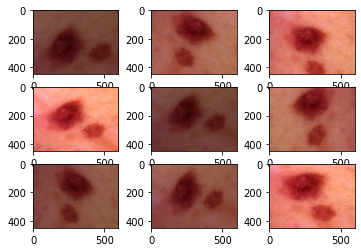

In [139]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

# load the image
img = load_img('Image_1.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(shear_range=0.2,featurewise_std_normalization=True,zoom_range=[0.8,1.0],brightness_range=[0.5,1.5],rotation_range=90,height_shift_range=0.1,horizontal_flip=True,width_shift_range=[-3,3])
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

## TRANSFER LEARNING ##

 We tried VGG16, VGG19, Inceptionv3, ResNet and Xception. VGG16 gave us the best results. All weigths imported from imagenet. 

In [24]:
import keras
model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(90, 90, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.


In [25]:
def create_features(dataset, pre_model, aug, k):
 
    x_scratch = []
    count = 0;
    # loop over the images
    for imagePath in dataset:
 
        # load the input image and image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(90, 90))
        image = img_to_array(image)
 
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        
        x_scratch.append(image)

        if(aug):
            datagen = ImageDataGenerator(shear_range=0.2,zoom_range=[0.8,1.0],brightness_range=[0.5,1.5],rotation_range=90,height_shift_range=0.1,horizontal_flip=True,width_shift_range=[-3,3])
            it = datagen.flow(image, batch_size=1)


            for i in range(k):

                # generate batch of images
                batch = it.next()
                # convert to unsigned integers for viewing
                image = batch[0].astype('uint8')

                image = np.expand_dims(image, axis=0)
                image = imagenet_utils.preprocess_input(image)
                x_scratch.append(image)
                
        #if(count==5):
        #    break
        #count+=1
        
 
    x = np.vstack(x_scratch)
    features = pre_model.predict(x, batch_size=32)
    #features_flatten = features.reshape((features.shape[0], 7 * 7 * 512))
    return x, features

## Feature Extraction with VGG16 ##

There is where we applied, data augmentation and reading images. Instead of merging the pre-trained model VGG16 and our model, we convert/reshapes images as outputs of pre-trained model. We splite the data to 0.9 train and 0.1 validation. 

In [26]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator

#train_x, train_features, train_features_flatten = create_features(trainpath[:9000], model,True,3)
#val_x, val_features, val_features_flatten = create_features(trainpath[9000:], model,True,3)
#test_x, test_features, test_features_flatten = create_features(testpath, model,False,-1)

train_x, train_features = create_features(trainpath[:9000], model,True,2)
val_x, val_features = create_features(trainpath[9000:], model,True,2)
test_x, test_features = create_features(testpath, model,False,-1)
 

print(train_x.shape, train_features.shape)
print(val_x.shape, val_features.shape)
print(test_x.shape, test_features.shape)

(27000, 90, 90, 3) (27000, 2, 2, 512)
(3000, 90, 90, 3) (3000, 2, 2, 512)
(5000, 90, 90, 3) (5000, 2, 2, 512)


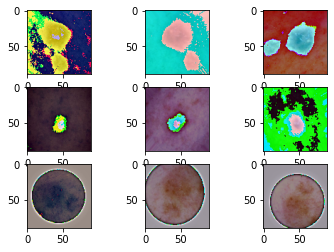

In [28]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = train_x[i].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)

### Labels ###

 We need to substract 1 from labels because there is inconsatants between target layers {0,1,2,3,4} and layers in csv {1,2,3,4,5}. Also, we used repeat function to sustain the shape with data augmented images.

In [29]:
trainlabel = df['Category'][:9000]
validlabel = df['Category'][9000:]

validlabel = validlabel -1
trainlabel = trainlabel -1
validlabel = np.array(validlabel)
trainlabel = np.array(trainlabel)

trainlabel = np.repeat(trainlabel,3)
validlabel = np.repeat(validlabel,3)


In [30]:
from keras.utils import to_categorical

validlabel = to_categorical(validlabel,num_classes=5)

trainlabel = to_categorical(trainlabel,num_classes=5)

trainlabel

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## Check Point ##

It is crucial to keep track of our best model. 

In [31]:
from keras.callbacks import ModelCheckpoint


checkpointer = ModelCheckpoint(filepath='vgg19.best.hdf5',
                               verbose=1,save_best_only=True)

## Our Model ##

In this part we manually tried hundreds of things as batch normalizers, poolings, dropouts and l2 regulizers. 

In [82]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import regularizers




model_transfer = Sequential()
model_transfer.add(GlobalAveragePooling2D(input_shape=(2,2,512)))
model_transfer.add(Dropout(0.3))
model_transfer.add(Dense(600, activation='relu'))
model_transfer.add(Dense(64, activation='relu'))
model_transfer.add(Dense(20, activation='relu'))
model_transfer.add(Dropout(0.3))
model_transfer.add(Dense(10, activation='relu'))

model_transfer.add(Dense(5, activation='softmax'))
model_transfer.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 600)               307800    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                38464     
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [36]:

model_transfer.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model_transfer.fit(train_features, trainlabel, batch_size=100, epochs=100,
          validation_data=(val_features, validlabel), callbacks=[checkpointer],
          verbose=1, shuffle = True)

Train on 27000 samples, validate on 3000 samples
Epoch 1/100
27000/27000 [==============================] - 1s 55us/step - loss: 0.8402 - accuracy: 0.6796 - val_loss: 1.0143 - val_accuracy: 0.6213

Epoch 00001: val_loss did not improve from 0.98426
Epoch 2/100
27000/27000 [==============================] - 1s 47us/step - loss: 0.8292 - accuracy: 0.6848 - val_loss: 1.0183 - val_accuracy: 0.6177

Epoch 00002: val_loss did not improve from 0.98426
Epoch 3/100
27000/27000 [==============================] - 1s 47us/step - loss: 0.8112 - accuracy: 0.6922 - val_loss: 1.0034 - val_accuracy: 0.6220

Epoch 00003: val_loss did not improve from 0.98426
Epoch 4/100
27000/27000 [==============================] - 1s 50us/step - loss: 0.8004 - accuracy: 0.6958 - val_loss: 1.0132 - val_accuracy: 0.6147

Epoch 00004: val_loss did not improve from 0.98426
Epoch 5/100
27000/27000 [==============================] - 1s 48us/step - loss: 0.7888 - accuracy: 0.6994 - val_loss: 1.0271 - val_accuracy: 0.6130

Ep


Epoch 00041: val_loss did not improve from 0.98426
Epoch 42/100
27000/27000 [==============================] - 1s 45us/step - loss: 0.5410 - accuracy: 0.8012 - val_loss: 1.1429 - val_accuracy: 0.6073

Epoch 00042: val_loss did not improve from 0.98426
Epoch 43/100
27000/27000 [==============================] - 2s 74us/step - loss: 0.5322 - accuracy: 0.8034 - val_loss: 1.1612 - val_accuracy: 0.6173

Epoch 00043: val_loss did not improve from 0.98426
Epoch 44/100
27000/27000 [==============================] - 1s 45us/step - loss: 0.5233 - accuracy: 0.8099 - val_loss: 1.2095 - val_accuracy: 0.5953

Epoch 00044: val_loss did not improve from 0.98426
Epoch 45/100
27000/27000 [==============================] - 1s 45us/step - loss: 0.5255 - accuracy: 0.8107 - val_loss: 1.1591 - val_accuracy: 0.6160

Epoch 00045: val_loss did not improve from 0.98426
Epoch 46/100
27000/27000 [==============================] - 1s 45us/step - loss: 0.5157 - accuracy: 0.8112 - val_loss: 1.1875 - val_accuracy: 0.

## Visualization ##

As you can see while our accuracy increases our validation stays stable. That means over-fitting and after we tried dropouts and regularizations, we eventually gave up...

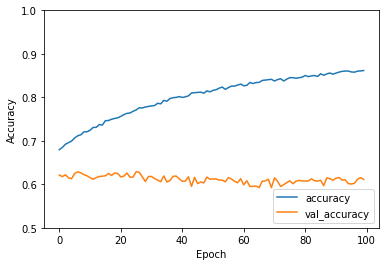

In [39]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_transfer.evaluate(train_features,  trainlabel, verbose=2)


## Best Model ##

This was the best model that we obtain with 0.82 val_loss. 

In [40]:
from keras.models import load_model

best_model = load_model('scratchmodel.best.hdf5')

In [41]:
best_model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_47  (None, 512)               0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 600)               307800    
_________________________________________________________________
dense_199 (Dense)            (None, 64)                38464     
_________________________________________________________________
dense_200 (Dense)            (None, 20)                1300      
_________________________________________________________________
dense_201 (Dense)            (None, 10)                210       
_________________________________________________________________
dropout_72 (Dropout)         (None, 10)              

# Hyper Tuning #

You can see the hyper-tuning of different parameters like dense nodes, dropout rates, learning rates and activation functions.

In [133]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

def build_model(hp):
    model = keras.Sequential()
    model.add(GlobalAveragePooling2D(input_shape=(2,2,512)))

    model.add(
        Dense(
            units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=132,
                    step=100,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'elu', 'sigmoid'],
                    default='relu'
                )
            )
        )
    model.add(
            Dense(
                units=hp.Int(
                    'units2',
                    min_value=32,
                    max_value=132,
                    step=100,
                    default=128
                ),
                activation=hp.Choice(
                    'dense_activation2',
                    values=['relu', 'elu', 'sigmoid'],
                    default='relu'
                )
            )
        )
    
    
    model.add(
        Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.25,
            ))
        )
    
    model.add(Dense(5, activation='softmax'))

    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [134]:
from kerastuner.tuners import Hyperband


tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    )

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [135]:
train_features.shape

(27000, 2, 2, 512)

In [136]:
tuner.search_space_summary()

In [138]:
N_EPOCH_SEARCH = 30

tuner.search(train_features, trainlabel, epochs=10, validation_split=0.1)

Epoch 11/30
760/760 [==============================] - ETA: 0s - loss: 1.7815 - accuracy: 0.25 - ETA: 1s - loss: 1.5020 - accuracy: 0.45 - ETA: 1s - loss: 1.4081 - accuracy: 0.47 - ETA: 1s - loss: 1.3507 - accuracy: 0.48 - ETA: 1s - loss: 1.3160 - accuracy: 0.49 - ETA: 1s - loss: 1.2904 - accuracy: 0.49 - ETA: 1s - loss: 1.2740 - accuracy: 0.50 - ETA: 1s - loss: 1.2636 - accuracy: 0.50 - ETA: 1s - loss: 1.2472 - accuracy: 0.50 - ETA: 1s - loss: 1.2382 - accuracy: 0.51 - ETA: 1s - loss: 1.2240 - accuracy: 0.51 - ETA: 1s - loss: 1.2144 - accuracy: 0.52 - ETA: 1s - loss: 1.2036 - accuracy: 0.52 - ETA: 1s - loss: 1.1976 - accuracy: 0.52 - ETA: 1s - loss: 1.1939 - accuracy: 0.52 - ETA: 1s - loss: 1.1897 - accuracy: 0.52 - ETA: 1s - loss: 1.1826 - accuracy: 0.53 - ETA: 1s - loss: 1.1774 - accuracy: 0.53 - ETA: 1s - loss: 1.1743 - accuracy: 0.53 - ETA: 1s - loss: 1.1715 - accuracy: 0.53 - ETA: 0s - loss: 1.1663 - accuracy: 0.53 - ETA: 0s - loss: 1.1634 - accuracy: 0.53 - ETA: 0s - loss: 1.159

760/760 [==============================] - ETA: 0s - loss: 0.5744 - accuracy: 0.75 - ETA: 1s - loss: 0.6588 - accuracy: 0.75 - ETA: 1s - loss: 0.6521 - accuracy: 0.74 - ETA: 1s - loss: 0.6579 - accuracy: 0.75 - ETA: 1s - loss: 0.6520 - accuracy: 0.75 - ETA: 1s - loss: 0.6438 - accuracy: 0.75 - ETA: 1s - loss: 0.6566 - accuracy: 0.75 - ETA: 1s - loss: 0.6496 - accuracy: 0.75 - ETA: 1s - loss: 0.6521 - accuracy: 0.75 - ETA: 1s - loss: 0.6553 - accuracy: 0.74 - ETA: 1s - loss: 0.6570 - accuracy: 0.74 - ETA: 1s - loss: 0.6555 - accuracy: 0.74 - ETA: 1s - loss: 0.6609 - accuracy: 0.74 - ETA: 1s - loss: 0.6617 - accuracy: 0.74 - ETA: 1s - loss: 0.6636 - accuracy: 0.74 - ETA: 1s - loss: 0.6632 - accuracy: 0.74 - ETA: 1s - loss: 0.6652 - accuracy: 0.74 - ETA: 1s - loss: 0.6668 - accuracy: 0.74 - ETA: 1s - loss: 0.6656 - accuracy: 0.74 - ETA: 1s - loss: 0.6654 - accuracy: 0.74 - ETA: 0s - loss: 0.6685 - accuracy: 0.74 - ETA: 0s - loss: 0.6706 - accuracy: 0.73 - ETA: 0s - loss: 0.6722 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 1.00 - ETA: 1s - loss: 0.3125 - accuracy: 0.87 - ETA: 2s - loss: 0.3235 - accuracy: 0.87 - ETA: 3s - loss: 0.3254 - accuracy: 0.87 - ETA: 3s - loss: 0.3228 - accuracy: 0.87 - ETA: 4s - loss: 0.3160 - accuracy: 0.87 - ETA: 5s - loss: 0.3145 - accuracy: 0.87 - ETA: 5s - loss: 0.3110 - accuracy: 0.88 - ETA: 6s - loss: 0.3139 - accuracy: 0.87 - ETA: 6s - loss: 0.3112 - accuracy: 0.87 - ETA: 6s - loss: 0.3077 - accuracy: 0.87 - ETA: 6s - loss: 0.3072 - accuracy: 0.88 - ETA: 7s - loss: 0.3026 - accuracy: 0.88 - ETA: 7s - loss: 0.2994 - accuracy: 0.88 - ETA: 7s - loss: 0.3038 - accuracy: 0.88 - ETA: 7s - loss: 0.3071 - accuracy: 0.88 - ETA: 7s - loss: 0.3077 - accuracy: 0.88 - ETA: 7s - loss: 0.3049 - accuracy: 0.88 - ETA: 8s - loss: 0.3047 - accuracy: 0.88 - ETA: 8s - loss: 0.3040 - accuracy: 0.88 - ETA: 8s - loss: 0.3060 - accuracy: 0.88 - ETA: 8s - loss: 0.3089 - accuracy: 0.88 - ETA: 8s - loss: 0.3101 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.96 - ETA: 1s - loss: 0.1814 - accuracy: 0.93 - ETA: 1s - loss: 0.1833 - accuracy: 0.93 - ETA: 1s - loss: 0.1955 - accuracy: 0.93 - ETA: 1s - loss: 0.1892 - accuracy: 0.93 - ETA: 1s - loss: 0.1858 - accuracy: 0.92 - ETA: 1s - loss: 0.1898 - accuracy: 0.92 - ETA: 1s - loss: 0.1895 - accuracy: 0.92 - ETA: 1s - loss: 0.1897 - accuracy: 0.93 - ETA: 1s - loss: 0.1927 - accuracy: 0.92 - ETA: 1s - loss: 0.1975 - accuracy: 0.92 - ETA: 1s - loss: 0.1990 - accuracy: 0.92 - ETA: 1s - loss: 0.1994 - accuracy: 0.92 - ETA: 1s - loss: 0.1999 - accuracy: 0.92 - ETA: 1s - loss: 0.2001 - accuracy: 0.92 - ETA: 1s - loss: 0.2009 - accuracy: 0.92 - ETA: 1s - loss: 0.1995 - accuracy: 0.92 - ETA: 1s - loss: 0.2007 - accuracy: 0.92 - ETA: 1s - loss: 0.2026 - accuracy: 0.92 - ETA: 1s - loss: 0.2055 - accuracy: 0.92 - ETA: 1s - loss: 0.2067 - accuracy: 0.92 - ETA: 0s - loss: 0.2082 - accuracy: 0.92 - ETA: 0s - loss: 0.2112 - accuracy

Epoch 1/10
760/760 [==============================] - ETA: 0s - loss: 5.8129 - accuracy: 0.25 - ETA: 7s - loss: 5.2578 - accuracy: 0.26 - ETA: 10s - loss: 4.8651 - accuracy: 0.257 - ETA: 11s - loss: 4.5904 - accuracy: 0.267 - ETA: 11s - loss: 4.5891 - accuracy: 0.272 - ETA: 10s - loss: 4.4852 - accuracy: 0.291 - ETA: 10s - loss: 4.3281 - accuracy: 0.312 - ETA: 10s - loss: 4.3154 - accuracy: 0.318 - ETA: 10s - loss: 4.2009 - accuracy: 0.323 - ETA: 10s - loss: 4.0513 - accuracy: 0.333 - ETA: 10s - loss: 4.0929 - accuracy: 0.330 - ETA: 10s - loss: 4.0803 - accuracy: 0.333 - ETA: 10s - loss: 4.0581 - accuracy: 0.332 - ETA: 10s - loss: 4.0988 - accuracy: 0.328 - ETA: 10s - loss: 4.0754 - accuracy: 0.330 - ETA: 10s - loss: 4.0481 - accuracy: 0.334 - ETA: 10s - loss: 3.9862 - accuracy: 0.336 - ETA: 10s - loss: 3.9592 - accuracy: 0.335 - ETA: 10s - loss: 3.9391 - accuracy: 0.338 - ETA: 10s - loss: 3.8851 - accuracy: 0.342 - ETA: 10s - loss: 3.8378 - accuracy: 0.342 - ETA: 10s - loss: 3.8169 - 

760/760 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.71 - ETA: 11s - loss: 0.7424 - accuracy: 0.703 - ETA: 15s - loss: 0.7131 - accuracy: 0.708 - ETA: 14s - loss: 0.6611 - accuracy: 0.743 - ETA: 13s - loss: 0.6800 - accuracy: 0.745 - ETA: 13s - loss: 0.6918 - accuracy: 0.728 - ETA: 13s - loss: 0.6763 - accuracy: 0.738 - ETA: 13s - loss: 0.6917 - accuracy: 0.734 - ETA: 13s - loss: 0.7070 - accuracy: 0.728 - ETA: 12s - loss: 0.7090 - accuracy: 0.728 - ETA: 13s - loss: 0.7067 - accuracy: 0.725 - ETA: 13s - loss: 0.7165 - accuracy: 0.721 - ETA: 12s - loss: 0.7195 - accuracy: 0.716 - ETA: 12s - loss: 0.7290 - accuracy: 0.714 - ETA: 13s - loss: 0.7380 - accuracy: 0.710 - ETA: 13s - loss: 0.7338 - accuracy: 0.713 - ETA: 13s - loss: 0.7346 - accuracy: 0.712 - ETA: 12s - loss: 0.7243 - accuracy: 0.713 - ETA: 12s - loss: 0.7241 - accuracy: 0.712 - ETA: 12s - loss: 0.7304 - accuracy: 0.710 - ETA: 12s - loss: 0.7368 - accuracy: 0.710 - ETA: 12s - loss: 0.7345 - accuracy:

Epoch 1/10
760/760 [==============================] - ETA: 0s - loss: 2.4851 - accuracy: 0.03 - ETA: 1s - loss: 1.6375 - accuracy: 0.35 - ETA: 1s - loss: 1.5147 - accuracy: 0.40 - ETA: 1s - loss: 1.4513 - accuracy: 0.43 - ETA: 1s - loss: 1.4137 - accuracy: 0.44 - ETA: 1s - loss: 1.3879 - accuracy: 0.44 - ETA: 0s - loss: 1.3627 - accuracy: 0.45 - ETA: 0s - loss: 1.3452 - accuracy: 0.46 - ETA: 0s - loss: 1.3264 - accuracy: 0.47 - ETA: 0s - loss: 1.3139 - accuracy: 0.47 - ETA: 0s - loss: 1.2968 - accuracy: 0.48 - ETA: 0s - loss: 1.2821 - accuracy: 0.49 - ETA: 0s - loss: 1.2708 - accuracy: 0.49 - ETA: 0s - loss: 1.2612 - accuracy: 0.50 - ETA: 0s - loss: 1.2523 - accuracy: 0.50 - ETA: 0s - loss: 1.2442 - accuracy: 0.50 - ETA: 0s - loss: 1.2347 - accuracy: 0.51 - ETA: 0s - loss: 1.2262 - accuracy: 0.51 - ETA: 0s - loss: 1.2193 - accuracy: 0.51 - ETA: 0s - loss: 1.2137 - accuracy: 0.51 - ETA: 0s - loss: 1.2088 - accuracy: 0.52 - ETA: 0s - loss: 1.2050 - accuracy: 0.52 - ETA: 0s - loss: 1.2002

760/760 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.71 - ETA: 1s - loss: 0.8075 - accuracy: 0.67 - ETA: 1s - loss: 0.8040 - accuracy: 0.68 - ETA: 1s - loss: 0.8102 - accuracy: 0.69 - ETA: 1s - loss: 0.8043 - accuracy: 0.69 - ETA: 0s - loss: 0.7985 - accuracy: 0.69 - ETA: 0s - loss: 0.7955 - accuracy: 0.69 - ETA: 0s - loss: 0.7991 - accuracy: 0.69 - ETA: 0s - loss: 0.7955 - accuracy: 0.69 - ETA: 0s - loss: 0.7922 - accuracy: 0.69 - ETA: 0s - loss: 0.7950 - accuracy: 0.69 - ETA: 0s - loss: 0.7975 - accuracy: 0.69 - ETA: 0s - loss: 0.7991 - accuracy: 0.69 - ETA: 0s - loss: 0.7984 - accuracy: 0.69 - ETA: 0s - loss: 0.7972 - accuracy: 0.69 - ETA: 0s - loss: 0.7973 - accuracy: 0.69 - ETA: 0s - loss: 0.7975 - accuracy: 0.69 - ETA: 0s - loss: 0.7961 - accuracy: 0.69 - ETA: 0s - loss: 0.7938 - accuracy: 0.69 - ETA: 0s - loss: 0.7947 - accuracy: 0.69 - ETA: 0s - loss: 0.7945 - accuracy: 0.69 - ETA: 0s - loss: 0.7961 - accuracy: 0.69 - ETA: 0s - loss: 0.7970 - accuracy

Epoch 1/10
760/760 [==============================] - ETA: 0s - loss: 11.0929 - accuracy: 0.343 - ETA: 1s - loss: 4.7108 - accuracy: 0.386 - ETA: 1s - loss: 3.1450 - accuracy: 0.42 - ETA: 1s - loss: 2.5682 - accuracy: 0.42 - ETA: 1s - loss: 2.3019 - accuracy: 0.42 - ETA: 1s - loss: 2.1048 - accuracy: 0.43 - ETA: 1s - loss: 1.9636 - accuracy: 0.43 - ETA: 1s - loss: 1.8779 - accuracy: 0.43 - ETA: 1s - loss: 1.8118 - accuracy: 0.43 - ETA: 1s - loss: 1.7575 - accuracy: 0.43 - ETA: 0s - loss: 1.7088 - accuracy: 0.44 - ETA: 0s - loss: 1.6738 - accuracy: 0.44 - ETA: 0s - loss: 1.6468 - accuracy: 0.44 - ETA: 0s - loss: 1.6212 - accuracy: 0.44 - ETA: 0s - loss: 1.5999 - accuracy: 0.44 - ETA: 0s - loss: 1.5806 - accuracy: 0.44 - ETA: 0s - loss: 1.5638 - accuracy: 0.44 - ETA: 0s - loss: 1.5501 - accuracy: 0.44 - ETA: 0s - loss: 1.5364 - accuracy: 0.44 - ETA: 0s - loss: 1.5244 - accuracy: 0.44 - ETA: 0s - loss: 1.5173 - accuracy: 0.44 - ETA: 0s - loss: 1.5118 - accuracy: 0.44 - ETA: 0s - loss: 1.5

Epoch 8/10
760/760 [==============================] - ETA: 0s - loss: 1.4002 - accuracy: 0.40 - ETA: 1s - loss: 1.4153 - accuracy: 0.43 - ETA: 1s - loss: 1.4115 - accuracy: 0.43 - ETA: 1s - loss: 1.4153 - accuracy: 0.43 - ETA: 1s - loss: 1.4137 - accuracy: 0.43 - ETA: 1s - loss: 1.4101 - accuracy: 0.43 - ETA: 1s - loss: 1.4089 - accuracy: 0.43 - ETA: 1s - loss: 1.4030 - accuracy: 0.43 - ETA: 1s - loss: 1.4007 - accuracy: 0.43 - ETA: 1s - loss: 1.3991 - accuracy: 0.43 - ETA: 0s - loss: 1.3971 - accuracy: 0.44 - ETA: 0s - loss: 1.3970 - accuracy: 0.44 - ETA: 0s - loss: 1.3958 - accuracy: 0.44 - ETA: 0s - loss: 1.3950 - accuracy: 0.44 - ETA: 0s - loss: 1.3916 - accuracy: 0.44 - ETA: 0s - loss: 1.3906 - accuracy: 0.44 - ETA: 0s - loss: 1.3886 - accuracy: 0.44 - ETA: 0s - loss: 1.3884 - accuracy: 0.44 - ETA: 0s - loss: 1.3860 - accuracy: 0.44 - ETA: 0s - loss: 1.3875 - accuracy: 0.44 - ETA: 0s - loss: 1.3876 - accuracy: 0.44 - ETA: 0s - loss: 1.3870 - accuracy: 0.44 - ETA: 0s - loss: 1.3872

Epoch 1/10
760/760 [==============================] - ETA: 0s - loss: 3.9342 - accuracy: 0.28 - ETA: 1s - loss: 2.8272 - accuracy: 0.35 - ETA: 1s - loss: 2.6249 - accuracy: 0.36 - ETA: 1s - loss: 2.4332 - accuracy: 0.38 - ETA: 1s - loss: 2.3013 - accuracy: 0.39 - ETA: 1s - loss: 2.1954 - accuracy: 0.41 - ETA: 1s - loss: 2.1001 - accuracy: 0.42 - ETA: 1s - loss: 2.0583 - accuracy: 0.43 - ETA: 0s - loss: 1.9943 - accuracy: 0.43 - ETA: 0s - loss: 1.9405 - accuracy: 0.44 - ETA: 0s - loss: 1.9017 - accuracy: 0.44 - ETA: 0s - loss: 1.8701 - accuracy: 0.45 - ETA: 0s - loss: 1.8462 - accuracy: 0.45 - ETA: 0s - loss: 1.8379 - accuracy: 0.45 - ETA: 0s - loss: 1.8324 - accuracy: 0.45 - ETA: 0s - loss: 1.8261 - accuracy: 0.45 - ETA: 0s - loss: 1.8202 - accuracy: 0.46 - ETA: 1s - loss: 1.8141 - accuracy: 0.46 - ETA: 1s - loss: 1.8135 - accuracy: 0.46 - ETA: 1s - loss: 1.8084 - accuracy: 0.46 - ETA: 1s - loss: 1.8048 - accuracy: 0.46 - ETA: 1s - loss: 1.8008 - accuracy: 0.46 - ETA: 1s - loss: 1.7991

760/760 [==============================] - ETA: 0s - loss: 0.4961 - accuracy: 0.81 - ETA: 1s - loss: 0.5321 - accuracy: 0.81 - ETA: 1s - loss: 0.5705 - accuracy: 0.79 - ETA: 1s - loss: 0.5782 - accuracy: 0.79 - ETA: 1s - loss: 0.5674 - accuracy: 0.80 - ETA: 1s - loss: 0.5743 - accuracy: 0.79 - ETA: 1s - loss: 0.5799 - accuracy: 0.79 - ETA: 1s - loss: 0.5848 - accuracy: 0.79 - ETA: 1s - loss: 0.5870 - accuracy: 0.78 - ETA: 1s - loss: 0.5955 - accuracy: 0.78 - ETA: 1s - loss: 0.5955 - accuracy: 0.78 - ETA: 1s - loss: 0.5961 - accuracy: 0.78 - ETA: 1s - loss: 0.5961 - accuracy: 0.78 - ETA: 1s - loss: 0.5969 - accuracy: 0.78 - ETA: 1s - loss: 0.5976 - accuracy: 0.78 - ETA: 1s - loss: 0.5970 - accuracy: 0.78 - ETA: 1s - loss: 0.5963 - accuracy: 0.78 - ETA: 1s - loss: 0.5953 - accuracy: 0.78 - ETA: 1s - loss: 0.5947 - accuracy: 0.78 - ETA: 1s - loss: 0.5949 - accuracy: 0.78 - ETA: 1s - loss: 0.5949 - accuracy: 0.78 - ETA: 1s - loss: 0.5943 - accuracy: 0.78 - ETA: 1s - loss: 0.5946 - accuracy

Epoch 1/10
760/760 [==============================] - ETA: 0s - loss: 1.5896 - accuracy: 0.34 - ETA: 1s - loss: 1.4621 - accuracy: 0.41 - ETA: 1s - loss: 1.4233 - accuracy: 0.41 - ETA: 1s - loss: 1.3852 - accuracy: 0.43 - ETA: 2s - loss: 1.3846 - accuracy: 0.44 - ETA: 2s - loss: 1.3750 - accuracy: 0.44 - ETA: 2s - loss: 1.3665 - accuracy: 0.45 - ETA: 3s - loss: 1.3668 - accuracy: 0.45 - ETA: 3s - loss: 1.3559 - accuracy: 0.45 - ETA: 3s - loss: 1.3489 - accuracy: 0.46 - ETA: 3s - loss: 1.3491 - accuracy: 0.45 - ETA: 4s - loss: 1.3468 - accuracy: 0.46 - ETA: 4s - loss: 1.3395 - accuracy: 0.46 - ETA: 4s - loss: 1.3383 - accuracy: 0.46 - ETA: 4s - loss: 1.3377 - accuracy: 0.46 - ETA: 5s - loss: 1.3317 - accuracy: 0.46 - ETA: 5s - loss: 1.3292 - accuracy: 0.46 - ETA: 5s - loss: 1.3311 - accuracy: 0.46 - ETA: 5s - loss: 1.3251 - accuracy: 0.47 - ETA: 5s - loss: 1.3274 - accuracy: 0.47 - ETA: 5s - loss: 1.3271 - accuracy: 0.47 - ETA: 5s - loss: 1.3207 - accuracy: 0.47 - ETA: 6s - loss: 1.3188

760/760 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.78 - ETA: 1s - loss: 0.8182 - accuracy: 0.70 - ETA: 1s - loss: 0.8119 - accuracy: 0.70 - ETA: 1s - loss: 0.8082 - accuracy: 0.71 - ETA: 1s - loss: 0.8027 - accuracy: 0.70 - ETA: 1s - loss: 0.8049 - accuracy: 0.70 - ETA: 1s - loss: 0.8082 - accuracy: 0.70 - ETA: 1s - loss: 0.8092 - accuracy: 0.70 - ETA: 1s - loss: 0.8164 - accuracy: 0.69 - ETA: 1s - loss: 0.8175 - accuracy: 0.69 - ETA: 1s - loss: 0.8168 - accuracy: 0.69 - ETA: 0s - loss: 0.8156 - accuracy: 0.69 - ETA: 0s - loss: 0.8193 - accuracy: 0.69 - ETA: 0s - loss: 0.8151 - accuracy: 0.69 - ETA: 0s - loss: 0.8183 - accuracy: 0.69 - ETA: 0s - loss: 0.8190 - accuracy: 0.69 - ETA: 0s - loss: 0.8204 - accuracy: 0.69 - ETA: 0s - loss: 0.8202 - accuracy: 0.69 - ETA: 0s - loss: 0.8179 - accuracy: 0.69 - ETA: 0s - loss: 0.8154 - accuracy: 0.69 - ETA: 0s - loss: 0.8176 - accuracy: 0.69 - ETA: 0s - loss: 0.8161 - accuracy: 0.69 - ETA: 0s - loss: 0.8167 - accuracy

Epoch 1/10
760/760 [==============================] - ETA: 0s - loss: 4.8641 - accuracy: 0.25 - ETA: 1s - loss: 3.0765 - accuracy: 0.39 - ETA: 1s - loss: 2.6295 - accuracy: 0.42 - ETA: 1s - loss: 2.3962 - accuracy: 0.43 - ETA: 1s - loss: 2.2306 - accuracy: 0.43 - ETA: 1s - loss: 2.0903 - accuracy: 0.44 - ETA: 1s - loss: 1.9582 - accuracy: 0.46 - ETA: 1s - loss: 1.8794 - accuracy: 0.47 - ETA: 1s - loss: 1.8167 - accuracy: 0.47 - ETA: 0s - loss: 1.7694 - accuracy: 0.47 - ETA: 0s - loss: 1.7251 - accuracy: 0.48 - ETA: 0s - loss: 1.6868 - accuracy: 0.48 - ETA: 0s - loss: 1.6536 - accuracy: 0.48 - ETA: 0s - loss: 1.6301 - accuracy: 0.48 - ETA: 0s - loss: 1.5989 - accuracy: 0.49 - ETA: 0s - loss: 1.5743 - accuracy: 0.50 - ETA: 0s - loss: 1.5542 - accuracy: 0.50 - ETA: 0s - loss: 1.5345 - accuracy: 0.50 - ETA: 0s - loss: 1.5207 - accuracy: 0.50 - ETA: 0s - loss: 1.4999 - accuracy: 0.50 - ETA: 0s - loss: 1.4819 - accuracy: 0.51 - ETA: 0s - loss: 1.4674 - accuracy: 0.51 - ETA: 0s - loss: 1.4535

760/760 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.87 - ETA: 1s - loss: 0.4869 - accuracy: 0.80 - ETA: 1s - loss: 0.4934 - accuracy: 0.80 - ETA: 1s - loss: 0.4774 - accuracy: 0.81 - ETA: 1s - loss: 0.4777 - accuracy: 0.81 - ETA: 1s - loss: 0.4718 - accuracy: 0.81 - ETA: 1s - loss: 0.4680 - accuracy: 0.81 - ETA: 1s - loss: 0.4675 - accuracy: 0.82 - ETA: 1s - loss: 0.4679 - accuracy: 0.82 - ETA: 1s - loss: 0.4706 - accuracy: 0.82 - ETA: 1s - loss: 0.4685 - accuracy: 0.82 - ETA: 1s - loss: 0.4732 - accuracy: 0.82 - ETA: 1s - loss: 0.4794 - accuracy: 0.81 - ETA: 0s - loss: 0.4881 - accuracy: 0.81 - ETA: 0s - loss: 0.4911 - accuracy: 0.81 - ETA: 0s - loss: 0.4877 - accuracy: 0.81 - ETA: 0s - loss: 0.4887 - accuracy: 0.81 - ETA: 0s - loss: 0.4903 - accuracy: 0.81 - ETA: 0s - loss: 0.4914 - accuracy: 0.81 - ETA: 0s - loss: 0.4905 - accuracy: 0.81 - ETA: 0s - loss: 0.4906 - accuracy: 0.81 - ETA: 0s - loss: 0.4913 - accuracy: 0.81 - ETA: 0s - loss: 0.4918 - accuracy

Epoch 1/10
760/760 [==============================] - ETA: 0s - loss: 2.2346 - accuracy: 0.03 - ETA: 1s - loss: 2.1172 - accuracy: 0.34 - ETA: 1s - loss: 1.7263 - accuracy: 0.42 - ETA: 1s - loss: 1.5564 - accuracy: 0.45 - ETA: 1s - loss: 1.4831 - accuracy: 0.46 - ETA: 1s - loss: 1.4147 - accuracy: 0.48 - ETA: 1s - loss: 1.3804 - accuracy: 0.49 - ETA: 1s - loss: 1.3449 - accuracy: 0.49 - ETA: 1s - loss: 1.3224 - accuracy: 0.50 - ETA: 1s - loss: 1.2960 - accuracy: 0.51 - ETA: 1s - loss: 1.2868 - accuracy: 0.51 - ETA: 1s - loss: 1.2761 - accuracy: 0.51 - ETA: 1s - loss: 1.2679 - accuracy: 0.51 - ETA: 1s - loss: 1.2522 - accuracy: 0.52 - ETA: 1s - loss: 1.2419 - accuracy: 0.52 - ETA: 1s - loss: 1.2341 - accuracy: 0.53 - ETA: 1s - loss: 1.2301 - accuracy: 0.53 - ETA: 1s - loss: 1.2222 - accuracy: 0.53 - ETA: 1s - loss: 1.2187 - accuracy: 0.53 - ETA: 1s - loss: 1.2133 - accuracy: 0.53 - ETA: 0s - loss: 1.2085 - accuracy: 0.53 - ETA: 0s - loss: 1.2046 - accuracy: 0.53 - ETA: 0s - loss: 1.2018

760/760 [==============================] - ETA: 0s - loss: 1.0789 - accuracy: 0.59 - ETA: 1s - loss: 1.1199 - accuracy: 0.56 - ETA: 1s - loss: 1.1260 - accuracy: 0.55 - ETA: 1s - loss: 1.1265 - accuracy: 0.54 - ETA: 1s - loss: 1.1102 - accuracy: 0.56 - ETA: 1s - loss: 1.0964 - accuracy: 0.56 - ETA: 1s - loss: 1.0917 - accuracy: 0.56 - ETA: 1s - loss: 1.0950 - accuracy: 0.56 - ETA: 1s - loss: 1.0963 - accuracy: 0.56 - ETA: 1s - loss: 1.0966 - accuracy: 0.56 - ETA: 1s - loss: 1.1006 - accuracy: 0.56 - ETA: 1s - loss: 1.1015 - accuracy: 0.56 - ETA: 1s - loss: 1.0993 - accuracy: 0.56 - ETA: 1s - loss: 1.0989 - accuracy: 0.56 - ETA: 1s - loss: 1.0972 - accuracy: 0.56 - ETA: 1s - loss: 1.0951 - accuracy: 0.56 - ETA: 1s - loss: 1.0945 - accuracy: 0.56 - ETA: 1s - loss: 1.0925 - accuracy: 0.56 - ETA: 1s - loss: 1.0906 - accuracy: 0.56 - ETA: 1s - loss: 1.0899 - accuracy: 0.56 - ETA: 0s - loss: 1.0909 - accuracy: 0.57 - ETA: 0s - loss: 1.0888 - accuracy: 0.57 - ETA: 0s - loss: 1.0867 - accuracy

Epoch 1/10
760/760 [==============================] - ETA: 0s - loss: 2.2650 - accuracy: 0.09 - ETA: 0s - loss: 1.3992 - accuracy: 0.42 - ETA: 0s - loss: 1.3286 - accuracy: 0.45 - ETA: 0s - loss: 1.3043 - accuracy: 0.47 - ETA: 0s - loss: 1.2767 - accuracy: 0.48 - ETA: 0s - loss: 1.2616 - accuracy: 0.49 - ETA: 0s - loss: 1.2458 - accuracy: 0.50 - ETA: 0s - loss: 1.2428 - accuracy: 0.50 - ETA: 0s - loss: 1.2359 - accuracy: 0.50 - ETA: 0s - loss: 1.2292 - accuracy: 0.50 - ETA: 0s - loss: 1.2230 - accuracy: 0.50 - ETA: 0s - loss: 1.2186 - accuracy: 0.51 - ETA: 0s - loss: 1.2147 - accuracy: 0.51 - ETA: 0s - loss: 1.2120 - accuracy: 0.51 - ETA: 0s - loss: 1.2098 - accuracy: 0.51 - ETA: 0s - loss: 1.2053 - accuracy: 0.51 - ETA: 0s - loss: 1.2005 - accuracy: 0.51 - ETA: 0s - loss: 1.1991 - accuracy: 0.52 - ETA: 0s - loss: 1.1976 - accuracy: 0.52 - ETA: 0s - loss: 1.1927 - accuracy: 0.52 - ETA: 0s - loss: 1.1911 - accuracy: 0.52 - 1s 2ms/step - loss: 1.1900 - accuracy: 0.5268 - val_loss: 1.1299

Epoch 11/30
760/760 [==============================] - ETA: 0s - loss: 2.4579 - accuracy: 0.03 - ETA: 1s - loss: 1.6302 - accuracy: 0.31 - ETA: 1s - loss: 1.5097 - accuracy: 0.37 - ETA: 1s - loss: 1.4868 - accuracy: 0.38 - ETA: 1s - loss: 1.4452 - accuracy: 0.39 - ETA: 1s - loss: 1.4200 - accuracy: 0.41 - ETA: 1s - loss: 1.3878 - accuracy: 0.42 - ETA: 1s - loss: 1.3708 - accuracy: 0.43 - ETA: 1s - loss: 1.3563 - accuracy: 0.44 - ETA: 1s - loss: 1.3399 - accuracy: 0.45 - ETA: 1s - loss: 1.3265 - accuracy: 0.46 - ETA: 1s - loss: 1.3154 - accuracy: 0.46 - ETA: 1s - loss: 1.3078 - accuracy: 0.47 - ETA: 1s - loss: 1.2963 - accuracy: 0.47 - ETA: 0s - loss: 1.2885 - accuracy: 0.48 - ETA: 0s - loss: 1.2836 - accuracy: 0.48 - ETA: 0s - loss: 1.2773 - accuracy: 0.48 - ETA: 0s - loss: 1.2708 - accuracy: 0.49 - ETA: 0s - loss: 1.2642 - accuracy: 0.49 - ETA: 0s - loss: 1.2609 - accuracy: 0.49 - ETA: 0s - loss: 1.2529 - accuracy: 0.49 - ETA: 0s - loss: 1.2470 - accuracy: 0.49 - ETA: 0s - loss: 1.242

760/760 [==============================] - ETA: 0s - loss: 0.9088 - accuracy: 0.68 - ETA: 1s - loss: 0.7915 - accuracy: 0.69 - ETA: 1s - loss: 0.7912 - accuracy: 0.68 - ETA: 1s - loss: 0.7917 - accuracy: 0.69 - ETA: 1s - loss: 0.8030 - accuracy: 0.68 - ETA: 1s - loss: 0.7997 - accuracy: 0.69 - ETA: 1s - loss: 0.7965 - accuracy: 0.69 - ETA: 1s - loss: 0.7970 - accuracy: 0.69 - ETA: 1s - loss: 0.8029 - accuracy: 0.68 - ETA: 1s - loss: 0.8043 - accuracy: 0.68 - ETA: 1s - loss: 0.8055 - accuracy: 0.68 - ETA: 1s - loss: 0.8086 - accuracy: 0.68 - ETA: 1s - loss: 0.8067 - accuracy: 0.68 - ETA: 1s - loss: 0.8071 - accuracy: 0.68 - ETA: 1s - loss: 0.8101 - accuracy: 0.68 - ETA: 0s - loss: 0.8114 - accuracy: 0.68 - ETA: 0s - loss: 0.8135 - accuracy: 0.68 - ETA: 0s - loss: 0.8145 - accuracy: 0.68 - ETA: 0s - loss: 0.8149 - accuracy: 0.68 - ETA: 0s - loss: 0.8155 - accuracy: 0.68 - ETA: 1s - loss: 0.8152 - accuracy: 0.68 - ETA: 1s - loss: 0.8148 - accuracy: 0.68 - ETA: 1s - loss: 0.8155 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.75 - ETA: 1s - loss: 0.5640 - accuracy: 0.79 - ETA: 1s - loss: 0.5659 - accuracy: 0.79 - ETA: 1s - loss: 0.5677 - accuracy: 0.79 - ETA: 1s - loss: 0.5693 - accuracy: 0.79 - ETA: 1s - loss: 0.5620 - accuracy: 0.80 - ETA: 1s - loss: 0.5628 - accuracy: 0.80 - ETA: 1s - loss: 0.5674 - accuracy: 0.80 - ETA: 1s - loss: 0.5728 - accuracy: 0.79 - ETA: 1s - loss: 0.5710 - accuracy: 0.79 - ETA: 1s - loss: 0.5733 - accuracy: 0.79 - ETA: 1s - loss: 0.5766 - accuracy: 0.79 - ETA: 1s - loss: 0.5776 - accuracy: 0.79 - ETA: 0s - loss: 0.5811 - accuracy: 0.79 - ETA: 0s - loss: 0.5828 - accuracy: 0.79 - ETA: 0s - loss: 0.5861 - accuracy: 0.78 - ETA: 0s - loss: 0.5876 - accuracy: 0.78 - ETA: 0s - loss: 0.5866 - accuracy: 0.78 - ETA: 0s - loss: 0.5891 - accuracy: 0.78 - ETA: 0s - loss: 0.5910 - accuracy: 0.78 - ETA: 0s - loss: 0.5887 - accuracy: 0.78 - ETA: 0s - loss: 0.5894 - accuracy: 0.78 - ETA: 0s - loss: 0.5899 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.84 - ETA: 1s - loss: 0.4245 - accuracy: 0.86 - ETA: 1s - loss: 0.4021 - accuracy: 0.86 - ETA: 1s - loss: 0.3846 - accuracy: 0.87 - ETA: 1s - loss: 0.3860 - accuracy: 0.87 - ETA: 1s - loss: 0.3762 - accuracy: 0.87 - ETA: 1s - loss: 0.3751 - accuracy: 0.88 - ETA: 1s - loss: 0.3761 - accuracy: 0.87 - ETA: 1s - loss: 0.3778 - accuracy: 0.87 - ETA: 1s - loss: 0.3743 - accuracy: 0.87 - ETA: 1s - loss: 0.3723 - accuracy: 0.87 - ETA: 1s - loss: 0.3768 - accuracy: 0.87 - ETA: 1s - loss: 0.3782 - accuracy: 0.87 - ETA: 1s - loss: 0.3750 - accuracy: 0.87 - ETA: 1s - loss: 0.3767 - accuracy: 0.87 - ETA: 0s - loss: 0.3766 - accuracy: 0.87 - ETA: 0s - loss: 0.3773 - accuracy: 0.87 - ETA: 0s - loss: 0.3783 - accuracy: 0.87 - ETA: 0s - loss: 0.3794 - accuracy: 0.87 - ETA: 0s - loss: 0.3798 - accuracy: 0.87 - ETA: 0s - loss: 0.3820 - accuracy: 0.87 - ETA: 0s - loss: 0.3826 - accuracy: 0.87 - ETA: 0s - loss: 0.3833 - accuracy

Epoch 11/30
760/760 [==============================] - ETA: 0s - loss: 1.9647 - accuracy: 0.21 - ETA: 1s - loss: 1.5817 - accuracy: 0.37 - ETA: 1s - loss: 1.4635 - accuracy: 0.42 - ETA: 1s - loss: 1.4149 - accuracy: 0.44 - ETA: 1s - loss: 1.3900 - accuracy: 0.45 - ETA: 1s - loss: 1.3619 - accuracy: 0.46 - ETA: 0s - loss: 1.3465 - accuracy: 0.46 - ETA: 0s - loss: 1.3239 - accuracy: 0.47 - ETA: 0s - loss: 1.3106 - accuracy: 0.47 - ETA: 0s - loss: 1.2983 - accuracy: 0.48 - ETA: 0s - loss: 1.2854 - accuracy: 0.49 - ETA: 0s - loss: 1.2759 - accuracy: 0.49 - ETA: 0s - loss: 1.2631 - accuracy: 0.50 - ETA: 0s - loss: 1.2540 - accuracy: 0.50 - ETA: 0s - loss: 1.2437 - accuracy: 0.50 - ETA: 0s - loss: 1.2343 - accuracy: 0.51 - ETA: 0s - loss: 1.2273 - accuracy: 0.51 - ETA: 0s - loss: 1.2234 - accuracy: 0.51 - ETA: 0s - loss: 1.2156 - accuracy: 0.52 - ETA: 0s - loss: 1.2104 - accuracy: 0.52 - ETA: 0s - loss: 1.2034 - accuracy: 0.52 - ETA: 0s - loss: 1.1971 - accuracy: 0.52 - ETA: 0s - loss: 1.191

760/760 [==============================] - ETA: 0s - loss: 0.7238 - accuracy: 0.71 - ETA: 1s - loss: 0.7753 - accuracy: 0.71 - ETA: 1s - loss: 0.7679 - accuracy: 0.71 - ETA: 1s - loss: 0.7787 - accuracy: 0.70 - ETA: 1s - loss: 0.7808 - accuracy: 0.70 - ETA: 1s - loss: 0.7846 - accuracy: 0.70 - ETA: 1s - loss: 0.7901 - accuracy: 0.69 - ETA: 1s - loss: 0.7906 - accuracy: 0.69 - ETA: 0s - loss: 0.7869 - accuracy: 0.70 - ETA: 0s - loss: 0.7864 - accuracy: 0.69 - ETA: 0s - loss: 0.7870 - accuracy: 0.69 - ETA: 0s - loss: 0.7917 - accuracy: 0.69 - ETA: 0s - loss: 0.7863 - accuracy: 0.69 - ETA: 0s - loss: 0.7881 - accuracy: 0.69 - ETA: 0s - loss: 0.7909 - accuracy: 0.69 - ETA: 0s - loss: 0.7921 - accuracy: 0.69 - ETA: 0s - loss: 0.7933 - accuracy: 0.69 - ETA: 0s - loss: 0.7937 - accuracy: 0.69 - ETA: 0s - loss: 0.7933 - accuracy: 0.69 - ETA: 0s - loss: 0.7932 - accuracy: 0.69 - ETA: 0s - loss: 0.7931 - accuracy: 0.69 - ETA: 0s - loss: 0.7937 - accuracy: 0.69 - ETA: 0s - loss: 0.7939 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.81 - ETA: 1s - loss: 0.6008 - accuracy: 0.80 - ETA: 1s - loss: 0.5904 - accuracy: 0.79 - ETA: 1s - loss: 0.6009 - accuracy: 0.78 - ETA: 1s - loss: 0.5935 - accuracy: 0.78 - ETA: 1s - loss: 0.5968 - accuracy: 0.78 - ETA: 1s - loss: 0.6037 - accuracy: 0.78 - ETA: 1s - loss: 0.6014 - accuracy: 0.78 - ETA: 1s - loss: 0.6008 - accuracy: 0.78 - ETA: 0s - loss: 0.5991 - accuracy: 0.78 - ETA: 0s - loss: 0.6021 - accuracy: 0.78 - ETA: 0s - loss: 0.6033 - accuracy: 0.78 - ETA: 0s - loss: 0.6025 - accuracy: 0.78 - ETA: 0s - loss: 0.6022 - accuracy: 0.78 - ETA: 0s - loss: 0.6024 - accuracy: 0.78 - ETA: 0s - loss: 0.6013 - accuracy: 0.78 - ETA: 0s - loss: 0.6014 - accuracy: 0.78 - ETA: 0s - loss: 0.5994 - accuracy: 0.78 - ETA: 0s - loss: 0.6001 - accuracy: 0.78 - ETA: 0s - loss: 0.6001 - accuracy: 0.78 - ETA: 0s - loss: 0.6017 - accuracy: 0.78 - ETA: 0s - loss: 0.6030 - accuracy: 0.78 - ETA: 0s - loss: 0.6032 - accuracy

Epoch 11/30
760/760 [==============================] - ETA: 0s - loss: 7.2572 - accuracy: 0.09 - ETA: 1s - loss: 3.4716 - accuracy: 0.36 - ETA: 1s - loss: 2.8619 - accuracy: 0.42 - ETA: 1s - loss: 2.5214 - accuracy: 0.44 - ETA: 1s - loss: 2.3136 - accuracy: 0.45 - ETA: 1s - loss: 2.1752 - accuracy: 0.46 - ETA: 1s - loss: 2.0572 - accuracy: 0.47 - ETA: 1s - loss: 1.9685 - accuracy: 0.48 - ETA: 1s - loss: 1.9003 - accuracy: 0.48 - ETA: 1s - loss: 1.8372 - accuracy: 0.48 - ETA: 1s - loss: 1.7826 - accuracy: 0.49 - ETA: 1s - loss: 1.7311 - accuracy: 0.49 - ETA: 1s - loss: 1.6945 - accuracy: 0.50 - ETA: 1s - loss: 1.6695 - accuracy: 0.50 - ETA: 0s - loss: 1.6340 - accuracy: 0.50 - ETA: 0s - loss: 1.6102 - accuracy: 0.50 - ETA: 0s - loss: 1.5829 - accuracy: 0.50 - ETA: 0s - loss: 1.5588 - accuracy: 0.51 - ETA: 0s - loss: 1.5398 - accuracy: 0.51 - ETA: 0s - loss: 1.5203 - accuracy: 0.51 - ETA: 0s - loss: 1.5034 - accuracy: 0.51 - ETA: 0s - loss: 1.4853 - accuracy: 0.52 - ETA: 0s - loss: 1.468

Epoch 18/30
760/760 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.71 - ETA: 1s - loss: 0.5217 - accuracy: 0.80 - ETA: 1s - loss: 0.5055 - accuracy: 0.80 - ETA: 1s - loss: 0.4957 - accuracy: 0.81 - ETA: 1s - loss: 0.4824 - accuracy: 0.81 - ETA: 1s - loss: 0.4654 - accuracy: 0.82 - ETA: 1s - loss: 0.4676 - accuracy: 0.82 - ETA: 1s - loss: 0.4705 - accuracy: 0.81 - ETA: 1s - loss: 0.4748 - accuracy: 0.81 - ETA: 1s - loss: 0.4741 - accuracy: 0.81 - ETA: 1s - loss: 0.4782 - accuracy: 0.81 - ETA: 0s - loss: 0.4720 - accuracy: 0.81 - ETA: 0s - loss: 0.4701 - accuracy: 0.81 - ETA: 0s - loss: 0.4725 - accuracy: 0.81 - ETA: 0s - loss: 0.4757 - accuracy: 0.81 - ETA: 0s - loss: 0.4770 - accuracy: 0.81 - ETA: 0s - loss: 0.4815 - accuracy: 0.81 - ETA: 0s - loss: 0.4852 - accuracy: 0.81 - ETA: 0s - loss: 0.4872 - accuracy: 0.81 - ETA: 0s - loss: 0.4892 - accuracy: 0.81 - ETA: 0s - loss: 0.4894 - accuracy: 0.81 - ETA: 0s - loss: 0.4904 - accuracy: 0.80 - ETA: 0s - loss: 0.493

760/760 [==============================] - ETA: 0s - loss: 0.4886 - accuracy: 0.84 - ETA: 1s - loss: 0.3069 - accuracy: 0.88 - ETA: 1s - loss: 0.2532 - accuracy: 0.90 - ETA: 1s - loss: 0.2530 - accuracy: 0.90 - ETA: 1s - loss: 0.2557 - accuracy: 0.90 - ETA: 1s - loss: 0.2442 - accuracy: 0.90 - ETA: 1s - loss: 0.2398 - accuracy: 0.91 - ETA: 1s - loss: 0.2380 - accuracy: 0.91 - ETA: 1s - loss: 0.2435 - accuracy: 0.90 - ETA: 1s - loss: 0.2469 - accuracy: 0.90 - ETA: 1s - loss: 0.2448 - accuracy: 0.90 - ETA: 1s - loss: 0.2442 - accuracy: 0.90 - ETA: 1s - loss: 0.2478 - accuracy: 0.90 - ETA: 1s - loss: 0.2491 - accuracy: 0.90 - ETA: 0s - loss: 0.2509 - accuracy: 0.90 - ETA: 0s - loss: 0.2490 - accuracy: 0.90 - ETA: 0s - loss: 0.2501 - accuracy: 0.90 - ETA: 0s - loss: 0.2498 - accuracy: 0.90 - ETA: 0s - loss: 0.2534 - accuracy: 0.90 - ETA: 0s - loss: 0.2536 - accuracy: 0.90 - ETA: 0s - loss: 0.2540 - accuracy: 0.90 - ETA: 0s - loss: 0.2551 - accuracy: 0.90 - ETA: 0s - loss: 0.2569 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 1.00 - ETA: 1s - loss: 0.1239 - accuracy: 0.95 - ETA: 1s - loss: 0.1235 - accuracy: 0.95 - ETA: 1s - loss: 0.1253 - accuracy: 0.95 - ETA: 1s - loss: 0.1451 - accuracy: 0.95 - ETA: 1s - loss: 0.1491 - accuracy: 0.94 - ETA: 1s - loss: 0.1446 - accuracy: 0.94 - ETA: 1s - loss: 0.1411 - accuracy: 0.94 - ETA: 1s - loss: 0.1398 - accuracy: 0.94 - ETA: 1s - loss: 0.1426 - accuracy: 0.94 - ETA: 1s - loss: 0.1442 - accuracy: 0.94 - ETA: 1s - loss: 0.1523 - accuracy: 0.94 - ETA: 1s - loss: 0.1556 - accuracy: 0.94 - ETA: 1s - loss: 0.1565 - accuracy: 0.94 - ETA: 0s - loss: 0.1578 - accuracy: 0.94 - ETA: 0s - loss: 0.1568 - accuracy: 0.94 - ETA: 0s - loss: 0.1566 - accuracy: 0.94 - ETA: 0s - loss: 0.1614 - accuracy: 0.94 - ETA: 0s - loss: 0.1627 - accuracy: 0.94 - ETA: 0s - loss: 0.1638 - accuracy: 0.94 - ETA: 0s - loss: 0.1646 - accuracy: 0.94 - ETA: 0s - loss: 0.1672 - accuracy: 0.94 - ETA: 0s - loss: 0.1669 - accuracy

Epoch 1/30
760/760 [==============================] - ETA: 0s - loss: 4.4442 - accuracy: 0.15 - ETA: 1s - loss: 4.2580 - accuracy: 0.40 - ETA: 1s - loss: 3.2202 - accuracy: 0.43 - ETA: 1s - loss: 2.6623 - accuracy: 0.44 - ETA: 1s - loss: 2.3278 - accuracy: 0.46 - ETA: 1s - loss: 2.1195 - accuracy: 0.47 - ETA: 1s - loss: 1.9874 - accuracy: 0.48 - ETA: 1s - loss: 1.8767 - accuracy: 0.49 - ETA: 1s - loss: 1.7929 - accuracy: 0.50 - ETA: 1s - loss: 1.7277 - accuracy: 0.51 - ETA: 1s - loss: 1.6734 - accuracy: 0.51 - ETA: 1s - loss: 1.6408 - accuracy: 0.51 - ETA: 1s - loss: 1.6038 - accuracy: 0.52 - ETA: 1s - loss: 1.5641 - accuracy: 0.52 - ETA: 1s - loss: 1.5326 - accuracy: 0.52 - ETA: 1s - loss: 1.5049 - accuracy: 0.52 - ETA: 1s - loss: 1.4774 - accuracy: 0.53 - ETA: 0s - loss: 1.4565 - accuracy: 0.53 - ETA: 0s - loss: 1.4401 - accuracy: 0.53 - ETA: 0s - loss: 1.4234 - accuracy: 0.53 - ETA: 0s - loss: 1.4143 - accuracy: 0.53 - ETA: 0s - loss: 1.3987 - accuracy: 0.53 - ETA: 0s - loss: 1.3841

760/760 [==============================] - ETA: 0s - loss: 0.3712 - accuracy: 0.87 - ETA: 10s - loss: 0.3212 - accuracy: 0.906 - ETA: 13s - loss: 0.3487 - accuracy: 0.875 - ETA: 13s - loss: 0.3683 - accuracy: 0.868 - ETA: 13s - loss: 0.3700 - accuracy: 0.860 - ETA: 12s - loss: 0.3663 - accuracy: 0.865 - ETA: 12s - loss: 0.3765 - accuracy: 0.860 - ETA: 12s - loss: 0.3715 - accuracy: 0.863 - ETA: 12s - loss: 0.3791 - accuracy: 0.860 - ETA: 12s - loss: 0.3649 - accuracy: 0.866 - ETA: 12s - loss: 0.3638 - accuracy: 0.867 - ETA: 12s - loss: 0.3615 - accuracy: 0.868 - ETA: 12s - loss: 0.3694 - accuracy: 0.865 - ETA: 12s - loss: 0.3663 - accuracy: 0.865 - ETA: 12s - loss: 0.3657 - accuracy: 0.864 - ETA: 12s - loss: 0.3584 - accuracy: 0.868 - ETA: 12s - loss: 0.3532 - accuracy: 0.871 - ETA: 12s - loss: 0.3569 - accuracy: 0.868 - ETA: 12s - loss: 0.3602 - accuracy: 0.867 - ETA: 12s - loss: 0.3573 - accuracy: 0.867 - ETA: 11s - loss: 0.3515 - accuracy: 0.868 - ETA: 11s - loss: 0.3499 - accuracy:

760/760 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.96 - ETA: 1s - loss: 0.1404 - accuracy: 0.95 - ETA: 1s - loss: 0.1500 - accuracy: 0.94 - ETA: 1s - loss: 0.1379 - accuracy: 0.95 - ETA: 1s - loss: 0.1351 - accuracy: 0.95 - ETA: 1s - loss: 0.1338 - accuracy: 0.95 - ETA: 1s - loss: 0.1319 - accuracy: 0.95 - ETA: 1s - loss: 0.1336 - accuracy: 0.95 - ETA: 1s - loss: 0.1373 - accuracy: 0.95 - ETA: 1s - loss: 0.1403 - accuracy: 0.95 - ETA: 1s - loss: 0.1400 - accuracy: 0.95 - ETA: 1s - loss: 0.1404 - accuracy: 0.95 - ETA: 1s - loss: 0.1387 - accuracy: 0.95 - ETA: 1s - loss: 0.1369 - accuracy: 0.95 - ETA: 1s - loss: 0.1376 - accuracy: 0.95 - ETA: 1s - loss: 0.1354 - accuracy: 0.95 - ETA: 1s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - ETA: 0s - loss: 0.1379 - accuracy: 0.95 - ETA: 0s - loss: 0.1387 - accuracy: 0.95 - ETA: 0s - loss: 0.1397 - accuracy: 0.95 - ETA: 0s - loss: 0.1439 - accuracy: 0.94 - ETA: 0s - loss: 0.1481 - accuracy

Epoch 20/30
760/760 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 1.00 - ETA: 1s - loss: 0.0917 - accuracy: 0.97 - ETA: 1s - loss: 0.0952 - accuracy: 0.97 - ETA: 1s - loss: 0.1014 - accuracy: 0.97 - ETA: 1s - loss: 0.0968 - accuracy: 0.97 - ETA: 1s - loss: 0.1043 - accuracy: 0.96 - ETA: 1s - loss: 0.1002 - accuracy: 0.96 - ETA: 1s - loss: 0.1029 - accuracy: 0.96 - ETA: 1s - loss: 0.1071 - accuracy: 0.96 - ETA: 1s - loss: 0.1084 - accuracy: 0.96 - ETA: 1s - loss: 0.1091 - accuracy: 0.96 - ETA: 1s - loss: 0.1112 - accuracy: 0.96 - ETA: 1s - loss: 0.1134 - accuracy: 0.96 - ETA: 1s - loss: 0.1153 - accuracy: 0.96 - ETA: 1s - loss: 0.1167 - accuracy: 0.96 - ETA: 1s - loss: 0.1166 - accuracy: 0.96 - ETA: 0s - loss: 0.1176 - accuracy: 0.96 - ETA: 0s - loss: 0.1213 - accuracy: 0.96 - ETA: 0s - loss: 0.1240 - accuracy: 0.96 - ETA: 0s - loss: 0.1235 - accuracy: 0.96 - ETA: 0s - loss: 0.1255 - accuracy: 0.96 - ETA: 0s - loss: 0.1258 - accuracy: 0.95 - ETA: 0s - loss: 0.124

760/760 [==============================] - ETA: 0s - loss: 0.0136 - accuracy: 1.00 - ETA: 1s - loss: 0.1079 - accuracy: 0.97 - ETA: 1s - loss: 0.0922 - accuracy: 0.97 - ETA: 1s - loss: 0.0931 - accuracy: 0.97 - ETA: 1s - loss: 0.0846 - accuracy: 0.97 - ETA: 1s - loss: 0.0825 - accuracy: 0.97 - ETA: 1s - loss: 0.0783 - accuracy: 0.97 - ETA: 1s - loss: 0.0776 - accuracy: 0.97 - ETA: 1s - loss: 0.0794 - accuracy: 0.97 - ETA: 1s - loss: 0.0809 - accuracy: 0.97 - ETA: 1s - loss: 0.0795 - accuracy: 0.97 - ETA: 1s - loss: 0.0816 - accuracy: 0.97 - ETA: 1s - loss: 0.0789 - accuracy: 0.97 - ETA: 1s - loss: 0.0820 - accuracy: 0.97 - ETA: 1s - loss: 0.0815 - accuracy: 0.97 - ETA: 1s - loss: 0.0829 - accuracy: 0.97 - ETA: 1s - loss: 0.0854 - accuracy: 0.97 - ETA: 0s - loss: 0.0853 - accuracy: 0.97 - ETA: 0s - loss: 0.0862 - accuracy: 0.97 - ETA: 0s - loss: 0.0882 - accuracy: 0.97 - ETA: 0s - loss: 0.0886 - accuracy: 0.97 - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - ETA: 0s - loss: 0.0927 - accuracy

Epoch 1/30
760/760 [==============================] - ETA: 0s - loss: 7.1749 - accuracy: 0.15 - ETA: 1s - loss: 3.3405 - accuracy: 0.39 - ETA: 1s - loss: 2.4909 - accuracy: 0.43 - ETA: 1s - loss: 2.1691 - accuracy: 0.44 - ETA: 1s - loss: 1.9390 - accuracy: 0.46 - ETA: 1s - loss: 1.8026 - accuracy: 0.47 - ETA: 1s - loss: 1.7130 - accuracy: 0.48 - ETA: 1s - loss: 1.6428 - accuracy: 0.48 - ETA: 1s - loss: 1.5896 - accuracy: 0.49 - ETA: 1s - loss: 1.5453 - accuracy: 0.50 - ETA: 1s - loss: 1.5147 - accuracy: 0.50 - ETA: 1s - loss: 1.4865 - accuracy: 0.50 - ETA: 1s - loss: 1.4652 - accuracy: 0.50 - ETA: 0s - loss: 1.4383 - accuracy: 0.51 - ETA: 0s - loss: 1.4151 - accuracy: 0.51 - ETA: 0s - loss: 1.3997 - accuracy: 0.51 - ETA: 0s - loss: 1.3823 - accuracy: 0.51 - ETA: 0s - loss: 1.3698 - accuracy: 0.52 - ETA: 0s - loss: 1.3564 - accuracy: 0.52 - ETA: 0s - loss: 1.3478 - accuracy: 0.52 - ETA: 0s - loss: 1.3385 - accuracy: 0.52 - ETA: 0s - loss: 1.3285 - accuracy: 0.52 - ETA: 0s - loss: 1.3195

760/760 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.71 - ETA: 1s - loss: 0.6554 - accuracy: 0.74 - ETA: 1s - loss: 0.6755 - accuracy: 0.72 - ETA: 1s - loss: 0.6579 - accuracy: 0.72 - ETA: 1s - loss: 0.6623 - accuracy: 0.72 - ETA: 1s - loss: 0.6712 - accuracy: 0.71 - ETA: 1s - loss: 0.6732 - accuracy: 0.72 - ETA: 1s - loss: 0.6832 - accuracy: 0.71 - ETA: 1s - loss: 0.6864 - accuracy: 0.71 - ETA: 1s - loss: 0.6886 - accuracy: 0.71 - ETA: 1s - loss: 0.6951 - accuracy: 0.71 - ETA: 1s - loss: 0.6963 - accuracy: 0.71 - ETA: 1s - loss: 0.6996 - accuracy: 0.71 - ETA: 1s - loss: 0.7028 - accuracy: 0.71 - ETA: 1s - loss: 0.7052 - accuracy: 0.71 - ETA: 0s - loss: 0.7074 - accuracy: 0.71 - ETA: 0s - loss: 0.7097 - accuracy: 0.71 - ETA: 0s - loss: 0.7120 - accuracy: 0.71 - ETA: 0s - loss: 0.7148 - accuracy: 0.71 - ETA: 0s - loss: 0.7168 - accuracy: 0.71 - ETA: 0s - loss: 0.7178 - accuracy: 0.71 - ETA: 0s - loss: 0.7175 - accuracy: 0.71 - ETA: 0s - loss: 0.7185 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.93 - ETA: 8s - loss: 0.3390 - accuracy: 0.89 - ETA: 9s - loss: 0.3835 - accuracy: 0.86 - ETA: 9s - loss: 0.3333 - accuracy: 0.88 - ETA: 9s - loss: 0.3360 - accuracy: 0.88 - ETA: 9s - loss: 0.3272 - accuracy: 0.88 - ETA: 9s - loss: 0.3055 - accuracy: 0.89 - ETA: 9s - loss: 0.3242 - accuracy: 0.89 - ETA: 9s - loss: 0.3243 - accuracy: 0.88 - ETA: 9s - loss: 0.3306 - accuracy: 0.88 - ETA: 9s - loss: 0.3302 - accuracy: 0.88 - ETA: 10s - loss: 0.3303 - accuracy: 0.881 - ETA: 9s - loss: 0.3375 - accuracy: 0.876 - ETA: 7s - loss: 0.3365 - accuracy: 0.87 - ETA: 5s - loss: 0.3407 - accuracy: 0.87 - ETA: 4s - loss: 0.3436 - accuracy: 0.87 - ETA: 3s - loss: 0.3398 - accuracy: 0.87 - ETA: 3s - loss: 0.3427 - accuracy: 0.87 - ETA: 2s - loss: 0.3453 - accuracy: 0.86 - ETA: 2s - loss: 0.3489 - accuracy: 0.86 - ETA: 2s - loss: 0.3476 - accuracy: 0.86 - ETA: 2s - loss: 0.3450 - accuracy: 0.86 - ETA: 1s - loss: 0.3503 - accur

760/760 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.93 - ETA: 1s - loss: 0.2103 - accuracy: 0.91 - ETA: 1s - loss: 0.2061 - accuracy: 0.92 - ETA: 1s - loss: 0.2095 - accuracy: 0.92 - ETA: 1s - loss: 0.2073 - accuracy: 0.92 - ETA: 2s - loss: 0.2121 - accuracy: 0.92 - ETA: 2s - loss: 0.2121 - accuracy: 0.92 - ETA: 2s - loss: 0.2112 - accuracy: 0.92 - ETA: 3s - loss: 0.2163 - accuracy: 0.92 - ETA: 3s - loss: 0.2181 - accuracy: 0.92 - ETA: 3s - loss: 0.2159 - accuracy: 0.92 - ETA: 3s - loss: 0.2181 - accuracy: 0.91 - ETA: 3s - loss: 0.2135 - accuracy: 0.92 - ETA: 4s - loss: 0.2110 - accuracy: 0.92 - ETA: 4s - loss: 0.2116 - accuracy: 0.92 - ETA: 4s - loss: 0.2098 - accuracy: 0.92 - ETA: 4s - loss: 0.2081 - accuracy: 0.92 - ETA: 4s - loss: 0.2068 - accuracy: 0.92 - ETA: 4s - loss: 0.2082 - accuracy: 0.92 - ETA: 5s - loss: 0.2052 - accuracy: 0.92 - ETA: 5s - loss: 0.2065 - accuracy: 0.92 - ETA: 5s - loss: 0.2051 - accuracy: 0.92 - ETA: 5s - loss: 0.2058 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.96 - ETA: 1s - loss: 0.1425 - accuracy: 0.95 - ETA: 1s - loss: 0.1432 - accuracy: 0.94 - ETA: 1s - loss: 0.1441 - accuracy: 0.94 - ETA: 1s - loss: 0.1518 - accuracy: 0.94 - ETA: 1s - loss: 0.1489 - accuracy: 0.94 - ETA: 1s - loss: 0.1544 - accuracy: 0.94 - ETA: 1s - loss: 0.1527 - accuracy: 0.94 - ETA: 1s - loss: 0.1534 - accuracy: 0.94 - ETA: 1s - loss: 0.1487 - accuracy: 0.94 - ETA: 1s - loss: 0.1475 - accuracy: 0.94 - ETA: 1s - loss: 0.1446 - accuracy: 0.94 - ETA: 1s - loss: 0.1450 - accuracy: 0.95 - ETA: 1s - loss: 0.1478 - accuracy: 0.94 - ETA: 0s - loss: 0.1515 - accuracy: 0.94 - ETA: 0s - loss: 0.1513 - accuracy: 0.94 - ETA: 0s - loss: 0.1507 - accuracy: 0.94 - ETA: 0s - loss: 0.1503 - accuracy: 0.94 - ETA: 0s - loss: 0.1516 - accuracy: 0.94 - ETA: 0s - loss: 0.1507 - accuracy: 0.94 - ETA: 0s - loss: 0.1497 - accuracy: 0.94 - ETA: 0s - loss: 0.1517 - accuracy: 0.94 - ETA: 0s - loss: 0.1528 - accuracy

Epoch 1/30
760/760 [==============================] - ETA: 0s - loss: 2.0967 - accuracy: 0.12 - ETA: 1s - loss: 1.6195 - accuracy: 0.29 - ETA: 1s - loss: 1.5116 - accuracy: 0.37 - ETA: 1s - loss: 1.4583 - accuracy: 0.40 - ETA: 1s - loss: 1.4335 - accuracy: 0.42 - ETA: 1s - loss: 1.4032 - accuracy: 0.43 - ETA: 1s - loss: 1.3849 - accuracy: 0.43 - ETA: 0s - loss: 1.3618 - accuracy: 0.44 - ETA: 0s - loss: 1.3478 - accuracy: 0.45 - ETA: 0s - loss: 1.3330 - accuracy: 0.46 - ETA: 0s - loss: 1.3209 - accuracy: 0.46 - ETA: 0s - loss: 1.3156 - accuracy: 0.47 - ETA: 0s - loss: 1.3052 - accuracy: 0.47 - ETA: 0s - loss: 1.2970 - accuracy: 0.47 - ETA: 0s - loss: 1.2889 - accuracy: 0.47 - ETA: 0s - loss: 1.2817 - accuracy: 0.48 - ETA: 0s - loss: 1.2758 - accuracy: 0.48 - ETA: 0s - loss: 1.2732 - accuracy: 0.48 - ETA: 0s - loss: 1.2714 - accuracy: 0.48 - ETA: 0s - loss: 1.2705 - accuracy: 0.48 - ETA: 0s - loss: 1.2693 - accuracy: 0.48 - ETA: 0s - loss: 1.2681 - accuracy: 0.48 - ETA: 0s - loss: 1.2678

760/760 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.56 - ETA: 1s - loss: 0.7802 - accuracy: 0.70 - ETA: 1s - loss: 0.7947 - accuracy: 0.69 - ETA: 1s - loss: 0.7807 - accuracy: 0.70 - ETA: 1s - loss: 0.7740 - accuracy: 0.71 - ETA: 1s - loss: 0.7748 - accuracy: 0.71 - ETA: 1s - loss: 0.7750 - accuracy: 0.71 - ETA: 1s - loss: 0.7738 - accuracy: 0.71 - ETA: 1s - loss: 0.7673 - accuracy: 0.71 - ETA: 1s - loss: 0.7665 - accuracy: 0.71 - ETA: 0s - loss: 0.7593 - accuracy: 0.71 - ETA: 0s - loss: 0.7597 - accuracy: 0.71 - ETA: 0s - loss: 0.7608 - accuracy: 0.71 - ETA: 0s - loss: 0.7591 - accuracy: 0.71 - ETA: 0s - loss: 0.7580 - accuracy: 0.71 - ETA: 0s - loss: 0.7577 - accuracy: 0.71 - ETA: 0s - loss: 0.7589 - accuracy: 0.71 - ETA: 0s - loss: 0.7558 - accuracy: 0.71 - ETA: 0s - loss: 0.7554 - accuracy: 0.71 - ETA: 0s - loss: 0.7548 - accuracy: 0.71 - ETA: 0s - loss: 0.7547 - accuracy: 0.71 - ETA: 0s - loss: 0.7552 - accuracy: 0.71 - ETA: 0s - loss: 0.7567 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.5855 - accuracy: 0.81 - ETA: 1s - loss: 0.4278 - accuracy: 0.85 - ETA: 1s - loss: 0.4383 - accuracy: 0.84 - ETA: 1s - loss: 0.4406 - accuracy: 0.84 - ETA: 1s - loss: 0.4400 - accuracy: 0.84 - ETA: 1s - loss: 0.4421 - accuracy: 0.84 - ETA: 1s - loss: 0.4424 - accuracy: 0.84 - ETA: 1s - loss: 0.4408 - accuracy: 0.84 - ETA: 1s - loss: 0.4392 - accuracy: 0.84 - ETA: 1s - loss: 0.4399 - accuracy: 0.84 - ETA: 2s - loss: 0.4384 - accuracy: 0.84 - ETA: 2s - loss: 0.4399 - accuracy: 0.84 - ETA: 2s - loss: 0.4413 - accuracy: 0.84 - ETA: 2s - loss: 0.4425 - accuracy: 0.84 - ETA: 2s - loss: 0.4443 - accuracy: 0.84 - ETA: 2s - loss: 0.4458 - accuracy: 0.84 - ETA: 2s - loss: 0.4474 - accuracy: 0.84 - ETA: 3s - loss: 0.4496 - accuracy: 0.84 - ETA: 3s - loss: 0.4499 - accuracy: 0.84 - ETA: 3s - loss: 0.4503 - accuracy: 0.84 - ETA: 3s - loss: 0.4501 - accuracy: 0.83 - ETA: 3s - loss: 0.4493 - accuracy: 0.83 - ETA: 3s - loss: 0.4494 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.93 - ETA: 1s - loss: 0.2182 - accuracy: 0.93 - ETA: 1s - loss: 0.2196 - accuracy: 0.93 - ETA: 1s - loss: 0.2143 - accuracy: 0.93 - ETA: 1s - loss: 0.2145 - accuracy: 0.93 - ETA: 1s - loss: 0.2169 - accuracy: 0.93 - ETA: 1s - loss: 0.2197 - accuracy: 0.93 - ETA: 1s - loss: 0.2238 - accuracy: 0.93 - ETA: 1s - loss: 0.2264 - accuracy: 0.93 - ETA: 1s - loss: 0.2267 - accuracy: 0.93 - ETA: 0s - loss: 0.2261 - accuracy: 0.93 - ETA: 0s - loss: 0.2250 - accuracy: 0.93 - ETA: 0s - loss: 0.2225 - accuracy: 0.93 - ETA: 0s - loss: 0.2241 - accuracy: 0.93 - ETA: 0s - loss: 0.2243 - accuracy: 0.93 - ETA: 0s - loss: 0.2244 - accuracy: 0.93 - ETA: 0s - loss: 0.2241 - accuracy: 0.93 - ETA: 0s - loss: 0.2251 - accuracy: 0.93 - ETA: 0s - loss: 0.2253 - accuracy: 0.93 - ETA: 0s - loss: 0.2247 - accuracy: 0.93 - ETA: 0s - loss: 0.2258 - accuracy: 0.93 - ETA: 0s - loss: 0.2268 - accuracy: 0.92 - ETA: 0s - loss: 0.2267 - accuracy

Epoch 1/30
760/760 [==============================] - ETA: 0s - loss: 1.6033 - accuracy: 0.40 - ETA: 1s - loss: 1.4561 - accuracy: 0.41 - ETA: 1s - loss: 1.3818 - accuracy: 0.43 - ETA: 1s - loss: 1.3222 - accuracy: 0.46 - ETA: 1s - loss: 1.2859 - accuracy: 0.48 - ETA: 1s - loss: 1.2524 - accuracy: 0.50 - ETA: 1s - loss: 1.2376 - accuracy: 0.50 - ETA: 0s - loss: 1.2241 - accuracy: 0.51 - ETA: 0s - loss: 1.2095 - accuracy: 0.51 - ETA: 0s - loss: 1.2016 - accuracy: 0.51 - ETA: 0s - loss: 1.1934 - accuracy: 0.52 - ETA: 0s - loss: 1.1849 - accuracy: 0.52 - ETA: 0s - loss: 1.1832 - accuracy: 0.52 - ETA: 0s - loss: 1.1780 - accuracy: 0.52 - ETA: 0s - loss: 1.1721 - accuracy: 0.53 - ETA: 0s - loss: 1.1678 - accuracy: 0.53 - ETA: 0s - loss: 1.1636 - accuracy: 0.53 - ETA: 0s - loss: 1.1603 - accuracy: 0.53 - ETA: 0s - loss: 1.1527 - accuracy: 0.54 - ETA: 0s - loss: 1.1494 - accuracy: 0.54 - ETA: 0s - loss: 1.1468 - accuracy: 0.54 - ETA: 0s - loss: 1.1409 - accuracy: 0.54 - ETA: 0s - loss: 1.1329

760/760 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.87 - ETA: 1s - loss: 0.3895 - accuracy: 0.85 - ETA: 1s - loss: 0.3944 - accuracy: 0.85 - ETA: 1s - loss: 0.4144 - accuracy: 0.84 - ETA: 1s - loss: 0.4006 - accuracy: 0.84 - ETA: 1s - loss: 0.4065 - accuracy: 0.84 - ETA: 0s - loss: 0.4218 - accuracy: 0.83 - ETA: 0s - loss: 0.4254 - accuracy: 0.83 - ETA: 0s - loss: 0.4284 - accuracy: 0.83 - ETA: 0s - loss: 0.4279 - accuracy: 0.83 - ETA: 0s - loss: 0.4300 - accuracy: 0.83 - ETA: 0s - loss: 0.4341 - accuracy: 0.83 - ETA: 0s - loss: 0.4352 - accuracy: 0.83 - ETA: 0s - loss: 0.4371 - accuracy: 0.83 - ETA: 0s - loss: 0.4387 - accuracy: 0.82 - ETA: 0s - loss: 0.4403 - accuracy: 0.82 - ETA: 0s - loss: 0.4396 - accuracy: 0.82 - ETA: 0s - loss: 0.4402 - accuracy: 0.82 - ETA: 0s - loss: 0.4401 - accuracy: 0.82 - ETA: 0s - loss: 0.4400 - accuracy: 0.82 - ETA: 0s - loss: 0.4398 - accuracy: 0.82 - ETA: 0s - loss: 0.4401 - accuracy: 0.82 - ETA: 0s - loss: 0.4408 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.1649 - accuracy: 0.93 - ETA: 1s - loss: 0.1520 - accuracy: 0.94 - ETA: 1s - loss: 0.1614 - accuracy: 0.93 - ETA: 1s - loss: 0.1632 - accuracy: 0.93 - ETA: 1s - loss: 0.1568 - accuracy: 0.94 - ETA: 1s - loss: 0.1572 - accuracy: 0.94 - ETA: 0s - loss: 0.1602 - accuracy: 0.94 - ETA: 0s - loss: 0.1652 - accuracy: 0.93 - ETA: 0s - loss: 0.1670 - accuracy: 0.93 - ETA: 0s - loss: 0.1675 - accuracy: 0.93 - ETA: 0s - loss: 0.1674 - accuracy: 0.93 - ETA: 0s - loss: 0.1677 - accuracy: 0.93 - ETA: 0s - loss: 0.1713 - accuracy: 0.93 - ETA: 0s - loss: 0.1704 - accuracy: 0.93 - ETA: 0s - loss: 0.1711 - accuracy: 0.93 - ETA: 0s - loss: 0.1744 - accuracy: 0.93 - ETA: 0s - loss: 0.1762 - accuracy: 0.93 - ETA: 0s - loss: 0.1774 - accuracy: 0.93 - ETA: 0s - loss: 0.1789 - accuracy: 0.93 - ETA: 0s - loss: 0.1812 - accuracy: 0.93 - ETA: 0s - loss: 0.1835 - accuracy: 0.92 - ETA: 0s - loss: 0.1841 - accuracy: 0.93 - ETA: 0s - loss: 0.1863 - accuracy

Epoch 1/30
760/760 [==============================] - ETA: 0s - loss: 2.0791 - accuracy: 0.25 - ETA: 1s - loss: 1.6627 - accuracy: 0.28 - ETA: 1s - loss: 1.5789 - accuracy: 0.35 - ETA: 1s - loss: 1.5230 - accuracy: 0.38 - ETA: 0s - loss: 1.4819 - accuracy: 0.39 - ETA: 0s - loss: 1.4519 - accuracy: 0.41 - ETA: 0s - loss: 1.4376 - accuracy: 0.41 - ETA: 0s - loss: 1.4191 - accuracy: 0.42 - ETA: 0s - loss: 1.4075 - accuracy: 0.43 - ETA: 0s - loss: 1.3935 - accuracy: 0.43 - ETA: 0s - loss: 1.3817 - accuracy: 0.44 - ETA: 0s - loss: 1.3720 - accuracy: 0.44 - ETA: 0s - loss: 1.3585 - accuracy: 0.45 - ETA: 0s - loss: 1.3479 - accuracy: 0.45 - ETA: 0s - loss: 1.3386 - accuracy: 0.46 - ETA: 0s - loss: 1.3299 - accuracy: 0.46 - ETA: 0s - loss: 1.3224 - accuracy: 0.46 - ETA: 0s - loss: 1.3125 - accuracy: 0.47 - ETA: 0s - loss: 1.3041 - accuracy: 0.47 - ETA: 0s - loss: 1.2933 - accuracy: 0.48 - ETA: 0s - loss: 1.2859 - accuracy: 0.48 - ETA: 0s - loss: 1.2812 - accuracy: 0.48 - ETA: 0s - loss: 1.2772

760/760 [==============================] - ETA: 0s - loss: 0.7052 - accuracy: 0.75 - ETA: 1s - loss: 0.8087 - accuracy: 0.70 - ETA: 1s - loss: 0.7709 - accuracy: 0.71 - ETA: 1s - loss: 0.7726 - accuracy: 0.70 - ETA: 1s - loss: 0.7841 - accuracy: 0.69 - ETA: 1s - loss: 0.7860 - accuracy: 0.69 - ETA: 0s - loss: 0.7821 - accuracy: 0.70 - ETA: 0s - loss: 0.7879 - accuracy: 0.69 - ETA: 0s - loss: 0.7872 - accuracy: 0.69 - ETA: 0s - loss: 0.7821 - accuracy: 0.70 - ETA: 0s - loss: 0.7824 - accuracy: 0.70 - ETA: 0s - loss: 0.7807 - accuracy: 0.70 - ETA: 0s - loss: 0.7804 - accuracy: 0.70 - ETA: 0s - loss: 0.7803 - accuracy: 0.70 - ETA: 0s - loss: 0.7816 - accuracy: 0.70 - ETA: 0s - loss: 0.7820 - accuracy: 0.69 - ETA: 0s - loss: 0.7852 - accuracy: 0.69 - ETA: 0s - loss: 0.7834 - accuracy: 0.69 - ETA: 0s - loss: 0.7853 - accuracy: 0.69 - ETA: 0s - loss: 0.7855 - accuracy: 0.69 - ETA: 0s - loss: 0.7868 - accuracy: 0.69 - ETA: 0s - loss: 0.7868 - accuracy: 0.69 - ETA: 0s - loss: 0.7875 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.78 - ETA: 1s - loss: 0.4989 - accuracy: 0.82 - ETA: 0s - loss: 0.4870 - accuracy: 0.82 - ETA: 0s - loss: 0.5004 - accuracy: 0.82 - ETA: 0s - loss: 0.4963 - accuracy: 0.82 - ETA: 0s - loss: 0.4907 - accuracy: 0.82 - ETA: 0s - loss: 0.4948 - accuracy: 0.82 - ETA: 0s - loss: 0.4940 - accuracy: 0.82 - ETA: 0s - loss: 0.4931 - accuracy: 0.82 - ETA: 0s - loss: 0.4966 - accuracy: 0.82 - ETA: 0s - loss: 0.4967 - accuracy: 0.82 - ETA: 0s - loss: 0.4975 - accuracy: 0.82 - ETA: 0s - loss: 0.4975 - accuracy: 0.82 - ETA: 0s - loss: 0.4972 - accuracy: 0.82 - ETA: 0s - loss: 0.5010 - accuracy: 0.82 - ETA: 0s - loss: 0.5007 - accuracy: 0.82 - ETA: 0s - loss: 0.4987 - accuracy: 0.82 - ETA: 0s - loss: 0.4987 - accuracy: 0.82 - ETA: 0s - loss: 0.4977 - accuracy: 0.82 - ETA: 0s - loss: 0.4976 - accuracy: 0.82 - ETA: 0s - loss: 0.4966 - accuracy: 0.82 - ETA: 0s - loss: 0.4946 - accuracy: 0.82 - 1s 2ms/step - loss: 0.4950 - accu

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 6.8411 - accuracy: 0.15 - ETA: 1s - loss: 4.3965 - accuracy: 0.24 - ETA: 1s - loss: 3.8032 - accuracy: 0.30 - ETA: 1s - loss: 3.4610 - accuracy: 0.32 - ETA: 1s - loss: 3.2664 - accuracy: 0.34 - ETA: 0s - loss: 3.0855 - accuracy: 0.35 - ETA: 0s - loss: 2.9590 - accuracy: 0.36 - ETA: 0s - loss: 2.8321 - accuracy: 0.37 - ETA: 0s - loss: 2.7383 - accuracy: 0.37 - ETA: 0s - loss: 2.6566 - accuracy: 0.38 - ETA: 0s - loss: 2.5898 - accuracy: 0.39 - ETA: 0s - loss: 2.5289 - accuracy: 0.39 - ETA: 0s - loss: 2.4739 - accuracy: 0.40 - ETA: 0s - loss: 2.4321 - accuracy: 0.40 - ETA: 0s - loss: 2.3883 - accuracy: 0.40 - ETA: 0s - loss: 2.3508 - accuracy: 0.41 - ETA: 0s - loss: 2.3011 - accuracy: 0.41 - ETA: 0s - loss: 2.2612 - accuracy: 0.42 - ETA: 0s - loss: 2.2335 - accuracy: 0.42 - ETA: 0s - loss: 2.2060 - accuracy: 0.42 - ETA: 0s - loss: 2.1806 - accuracy: 0.42 - ETA: 0s - loss: 2.1754 - accuracy: 0.42 - ETA: 0s - loss: 2.1688 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.6342 - accuracy: 0.18 - ETA: 0s - loss: 1.3464 - accuracy: 0.45 - ETA: 0s - loss: 1.2950 - accuracy: 0.47 - ETA: 0s - loss: 1.2563 - accuracy: 0.49 - ETA: 0s - loss: 1.2336 - accuracy: 0.50 - ETA: 0s - loss: 1.2101 - accuracy: 0.51 - ETA: 0s - loss: 1.1956 - accuracy: 0.52 - ETA: 0s - loss: 1.1885 - accuracy: 0.52 - ETA: 0s - loss: 1.1734 - accuracy: 0.53 - ETA: 0s - loss: 1.1661 - accuracy: 0.53 - ETA: 0s - loss: 1.1626 - accuracy: 0.53 - ETA: 0s - loss: 1.1574 - accuracy: 0.54 - ETA: 0s - loss: 1.1479 - accuracy: 0.54 - ETA: 0s - loss: 1.1434 - accuracy: 0.54 - ETA: 0s - loss: 1.1415 - accuracy: 0.54 - ETA: 0s - loss: 1.1402 - accuracy: 0.54 - ETA: 0s - loss: 1.1388 - accuracy: 0.54 - ETA: 0s - loss: 1.1377 - accuracy: 0.54 - ETA: 0s - loss: 1.1368 - accuracy: 0.54 - ETA: 0s - loss: 1.1361 - accuracy: 0.54 - ETA: 0s - loss: 1.1355 - accuracy: 0.54 - ETA: 0s - loss: 1.1344 - accuracy: 0.55 - ETA: 0s - loss: 1.1348 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.6701 - accuracy: 0.12 - ETA: 0s - loss: 1.4776 - accuracy: 0.37 - ETA: 0s - loss: 1.4321 - accuracy: 0.41 - ETA: 0s - loss: 1.4084 - accuracy: 0.42 - ETA: 0s - loss: 1.3884 - accuracy: 0.42 - ETA: 0s - loss: 1.3773 - accuracy: 0.43 - ETA: 0s - loss: 1.3595 - accuracy: 0.44 - ETA: 0s - loss: 1.3487 - accuracy: 0.44 - ETA: 0s - loss: 1.3402 - accuracy: 0.45 - ETA: 0s - loss: 1.3341 - accuracy: 0.45 - ETA: 0s - loss: 1.3275 - accuracy: 0.45 - ETA: 0s - loss: 1.3201 - accuracy: 0.45 - ETA: 0s - loss: 1.3131 - accuracy: 0.46 - ETA: 0s - loss: 1.3050 - accuracy: 0.46 - ETA: 0s - loss: 1.2973 - accuracy: 0.47 - ETA: 0s - loss: 1.2907 - accuracy: 0.47 - ETA: 0s - loss: 1.2852 - accuracy: 0.47 - ETA: 0s - loss: 1.2803 - accuracy: 0.48 - ETA: 0s - loss: 1.2754 - accuracy: 0.48 - ETA: 0s - loss: 1.2681 - accuracy: 0.48 - 1s 2ms/step - loss: 1.2633 - accuracy: 0.4880 - val_loss: 1.1656 - val_accuracy: 0.5393
Epoch 2/2
760/760 [

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.8464 - accuracy: 0.12 - ETA: 1s - loss: 1.6095 - accuracy: 0.31 - ETA: 1s - loss: 1.5557 - accuracy: 0.34 - ETA: 1s - loss: 1.5154 - accuracy: 0.38 - ETA: 1s - loss: 1.4838 - accuracy: 0.39 - ETA: 1s - loss: 1.4646 - accuracy: 0.40 - ETA: 1s - loss: 1.4518 - accuracy: 0.41 - ETA: 0s - loss: 1.4414 - accuracy: 0.41 - ETA: 0s - loss: 1.4258 - accuracy: 0.42 - ETA: 0s - loss: 1.4116 - accuracy: 0.42 - ETA: 0s - loss: 1.3997 - accuracy: 0.43 - ETA: 0s - loss: 1.3889 - accuracy: 0.43 - ETA: 0s - loss: 1.3748 - accuracy: 0.44 - ETA: 0s - loss: 1.3705 - accuracy: 0.44 - ETA: 0s - loss: 1.3613 - accuracy: 0.44 - ETA: 0s - loss: 1.3586 - accuracy: 0.45 - ETA: 0s - loss: 1.3484 - accuracy: 0.45 - ETA: 0s - loss: 1.3380 - accuracy: 0.45 - ETA: 0s - loss: 1.3308 - accuracy: 0.46 - ETA: 0s - loss: 1.3226 - accuracy: 0.46 - ETA: 0s - loss: 1.3175 - accuracy: 0.46 - ETA: 0s - loss: 1.3128 - accuracy: 0.47 - ETA: 0s - loss: 1.3060 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.7779 - accuracy: 0.09 - ETA: 0s - loss: 1.6318 - accuracy: 0.24 - ETA: 0s - loss: 1.5374 - accuracy: 0.32 - ETA: 0s - loss: 1.4945 - accuracy: 0.36 - ETA: 0s - loss: 1.4685 - accuracy: 0.38 - ETA: 0s - loss: 1.4496 - accuracy: 0.40 - ETA: 0s - loss: 1.4342 - accuracy: 0.40 - ETA: 0s - loss: 1.4199 - accuracy: 0.41 - ETA: 0s - loss: 1.4031 - accuracy: 0.42 - ETA: 0s - loss: 1.3969 - accuracy: 0.42 - ETA: 0s - loss: 1.3880 - accuracy: 0.43 - ETA: 0s - loss: 1.3819 - accuracy: 0.43 - ETA: 0s - loss: 1.3755 - accuracy: 0.44 - ETA: 0s - loss: 1.3680 - accuracy: 0.44 - ETA: 0s - loss: 1.3611 - accuracy: 0.45 - ETA: 0s - loss: 1.3551 - accuracy: 0.45 - ETA: 0s - loss: 1.3489 - accuracy: 0.45 - ETA: 0s - loss: 1.3409 - accuracy: 0.46 - ETA: 0s - loss: 1.3346 - accuracy: 0.46 - ETA: 0s - loss: 1.3307 - accuracy: 0.46 - 1s 2ms/step - loss: 1.3264 - accuracy: 0.4689 - val_loss: 1.1855 - val_accuracy: 0.5367
Epoch 2/2
760/760 [

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 6.1428 - accuracy: 0.28 - ETA: 1s - loss: 3.4095 - accuracy: 0.37 - ETA: 1s - loss: 2.7660 - accuracy: 0.40 - ETA: 1s - loss: 2.3728 - accuracy: 0.42 - ETA: 1s - loss: 2.1707 - accuracy: 0.44 - ETA: 1s - loss: 2.0389 - accuracy: 0.45 - ETA: 1s - loss: 1.9499 - accuracy: 0.45 - ETA: 1s - loss: 1.8592 - accuracy: 0.46 - ETA: 0s - loss: 1.7814 - accuracy: 0.46 - ETA: 0s - loss: 1.7221 - accuracy: 0.47 - ETA: 0s - loss: 1.6777 - accuracy: 0.47 - ETA: 0s - loss: 1.6318 - accuracy: 0.48 - ETA: 0s - loss: 1.6041 - accuracy: 0.49 - ETA: 0s - loss: 1.5766 - accuracy: 0.49 - ETA: 0s - loss: 1.5514 - accuracy: 0.49 - ETA: 0s - loss: 1.5291 - accuracy: 0.49 - ETA: 0s - loss: 1.5064 - accuracy: 0.49 - ETA: 0s - loss: 1.4793 - accuracy: 0.50 - ETA: 0s - loss: 1.4597 - accuracy: 0.50 - ETA: 0s - loss: 1.4446 - accuracy: 0.50 - ETA: 0s - loss: 1.4278 - accuracy: 0.50 - ETA: 0s - loss: 1.4137 - accuracy: 0.51 - ETA: 0s - loss: 1.3961 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.9400 - accuracy: 0.12 - ETA: 1s - loss: 1.4510 - accuracy: 0.41 - ETA: 1s - loss: 1.3209 - accuracy: 0.47 - ETA: 1s - loss: 1.2741 - accuracy: 0.49 - ETA: 1s - loss: 1.2404 - accuracy: 0.50 - ETA: 1s - loss: 1.2148 - accuracy: 0.51 - ETA: 1s - loss: 1.1916 - accuracy: 0.52 - ETA: 1s - loss: 1.1672 - accuracy: 0.53 - ETA: 1s - loss: 1.1694 - accuracy: 0.53 - ETA: 1s - loss: 1.1677 - accuracy: 0.54 - ETA: 1s - loss: 1.1568 - accuracy: 0.54 - ETA: 1s - loss: 1.1458 - accuracy: 0.54 - ETA: 1s - loss: 1.1361 - accuracy: 0.55 - ETA: 1s - loss: 1.1287 - accuracy: 0.55 - ETA: 1s - loss: 1.1226 - accuracy: 0.55 - ETA: 0s - loss: 1.1152 - accuracy: 0.56 - ETA: 0s - loss: 1.1119 - accuracy: 0.56 - ETA: 0s - loss: 1.1115 - accuracy: 0.56 - ETA: 0s - loss: 1.1081 - accuracy: 0.56 - ETA: 0s - loss: 1.1058 - accuracy: 0.56 - ETA: 0s - loss: 1.1038 - accuracy: 0.56 - ETA: 0s - loss: 1.0995 - accuracy: 0.56 - ETA: 0s - loss: 1.0993 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 5.7602 - accuracy: 0.06 - ETA: 1s - loss: 4.9582 - accuracy: 0.37 - ETA: 1s - loss: 3.2777 - accuracy: 0.41 - ETA: 1s - loss: 2.6355 - accuracy: 0.43 - ETA: 1s - loss: 2.3204 - accuracy: 0.44 - ETA: 1s - loss: 2.1191 - accuracy: 0.45 - ETA: 1s - loss: 1.9637 - accuracy: 0.46 - ETA: 1s - loss: 1.8676 - accuracy: 0.47 - ETA: 0s - loss: 1.8011 - accuracy: 0.48 - ETA: 0s - loss: 1.7482 - accuracy: 0.48 - ETA: 0s - loss: 1.7116 - accuracy: 0.48 - ETA: 0s - loss: 1.6798 - accuracy: 0.48 - ETA: 0s - loss: 1.6569 - accuracy: 0.48 - ETA: 0s - loss: 1.6521 - accuracy: 0.48 - ETA: 0s - loss: 1.6479 - accuracy: 0.48 - ETA: 0s - loss: 1.6434 - accuracy: 0.48 - ETA: 0s - loss: 1.6435 - accuracy: 0.48 - ETA: 1s - loss: 1.6419 - accuracy: 0.48 - ETA: 1s - loss: 1.6380 - accuracy: 0.48 - ETA: 1s - loss: 1.6347 - accuracy: 0.48 - ETA: 1s - loss: 1.6326 - accuracy: 0.48 - ETA: 1s - loss: 1.6320 - accuracy: 0.48 - ETA: 1s - loss: 1.6298 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 3.3072 - accuracy: 0.25 - ETA: 8s - loss: 16.0288 - accuracy: 0.331 - ETA: 10s - loss: 11.7622 - accuracy: 0.39 - ETA: 12s - loss: 10.3361 - accuracy: 0.37 - ETA: 12s - loss: 8.3797 - accuracy: 0.4014 - ETA: 12s - loss: 6.7817 - accuracy: 0.413 - ETA: 11s - loss: 5.8145 - accuracy: 0.395 - ETA: 11s - loss: 5.2654 - accuracy: 0.401 - ETA: 11s - loss: 4.8191 - accuracy: 0.413 - ETA: 12s - loss: 4.4794 - accuracy: 0.415 - ETA: 12s - loss: 4.2086 - accuracy: 0.416 - ETA: 12s - loss: 3.8874 - accuracy: 0.434 - ETA: 12s - loss: 3.6927 - accuracy: 0.443 - ETA: 12s - loss: 3.5216 - accuracy: 0.449 - ETA: 12s - loss: 3.3786 - accuracy: 0.457 - ETA: 12s - loss: 3.2420 - accuracy: 0.467 - ETA: 10s - loss: 2.8559 - accuracy: 0.469 - ETA: 7s - loss: 2.4659 - accuracy: 0.469 - ETA: 6s - loss: 2.1793 - accuracy: 0.47 - ETA: 5s - loss: 2.0221 - accuracy: 0.48 - ETA: 4s - loss: 1.8939 - accuracy: 0.49 - ETA: 3s - loss: 1.7887 - accura

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.9666 - accuracy: 0.18 - ETA: 1s - loss: 1.4465 - accuracy: 0.43 - ETA: 1s - loss: 1.3386 - accuracy: 0.46 - ETA: 1s - loss: 1.2943 - accuracy: 0.48 - ETA: 1s - loss: 1.2665 - accuracy: 0.49 - ETA: 1s - loss: 1.2469 - accuracy: 0.50 - ETA: 1s - loss: 1.2300 - accuracy: 0.50 - ETA: 1s - loss: 1.2194 - accuracy: 0.51 - ETA: 1s - loss: 1.2088 - accuracy: 0.51 - ETA: 1s - loss: 1.2064 - accuracy: 0.51 - ETA: 1s - loss: 1.1982 - accuracy: 0.52 - ETA: 1s - loss: 1.1961 - accuracy: 0.52 - ETA: 1s - loss: 1.1892 - accuracy: 0.52 - ETA: 0s - loss: 1.1846 - accuracy: 0.53 - ETA: 0s - loss: 1.1766 - accuracy: 0.53 - ETA: 0s - loss: 1.1740 - accuracy: 0.53 - ETA: 0s - loss: 1.1724 - accuracy: 0.53 - ETA: 1s - loss: 1.1720 - accuracy: 0.53 - ETA: 1s - loss: 1.1716 - accuracy: 0.53 - ETA: 1s - loss: 1.1708 - accuracy: 0.53 - ETA: 1s - loss: 1.1704 - accuracy: 0.53 - ETA: 1s - loss: 1.1695 - accuracy: 0.53 - ETA: 1s - loss: 1.1699 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 3.5279 - accuracy: 0.21 - ETA: 0s - loss: 3.2470 - accuracy: 0.23 - ETA: 0s - loss: 2.8735 - accuracy: 0.24 - ETA: 0s - loss: 2.6567 - accuracy: 0.26 - ETA: 0s - loss: 2.5213 - accuracy: 0.28 - ETA: 0s - loss: 2.4136 - accuracy: 0.29 - ETA: 0s - loss: 2.3288 - accuracy: 0.30 - ETA: 0s - loss: 2.2578 - accuracy: 0.31 - ETA: 0s - loss: 2.1995 - accuracy: 0.31 - ETA: 0s - loss: 2.1526 - accuracy: 0.32 - ETA: 0s - loss: 2.1077 - accuracy: 0.32 - ETA: 0s - loss: 2.0619 - accuracy: 0.33 - ETA: 0s - loss: 2.0189 - accuracy: 0.33 - ETA: 0s - loss: 1.9899 - accuracy: 0.34 - ETA: 0s - loss: 1.9872 - accuracy: 0.34 - ETA: 0s - loss: 1.9827 - accuracy: 0.34 - ETA: 0s - loss: 1.9774 - accuracy: 0.34 - ETA: 0s - loss: 1.9714 - accuracy: 0.34 - ETA: 0s - loss: 1.9678 - accuracy: 0.34 - ETA: 0s - loss: 1.9643 - accuracy: 0.34 - ETA: 0s - loss: 1.9612 - accuracy: 0.34 - ETA: 0s - loss: 1.9577 - accuracy: 0.34 - ETA: 0s - loss: 1.9546 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 5.4278 - accuracy: 0.31 - ETA: 1s - loss: 3.9903 - accuracy: 0.32 - ETA: 1s - loss: 3.5219 - accuracy: 0.34 - ETA: 1s - loss: 3.2479 - accuracy: 0.35 - ETA: 1s - loss: 3.0554 - accuracy: 0.37 - ETA: 1s - loss: 2.9000 - accuracy: 0.38 - ETA: 1s - loss: 2.7996 - accuracy: 0.39 - ETA: 1s - loss: 2.7146 - accuracy: 0.39 - ETA: 1s - loss: 2.6188 - accuracy: 0.40 - ETA: 1s - loss: 2.5504 - accuracy: 0.41 - ETA: 1s - loss: 2.4719 - accuracy: 0.41 - ETA: 1s - loss: 2.4192 - accuracy: 0.42 - ETA: 1s - loss: 2.3551 - accuracy: 0.42 - ETA: 1s - loss: 2.3027 - accuracy: 0.43 - ETA: 1s - loss: 2.2621 - accuracy: 0.43 - ETA: 1s - loss: 2.2097 - accuracy: 0.43 - ETA: 0s - loss: 2.1703 - accuracy: 0.44 - ETA: 0s - loss: 2.1342 - accuracy: 0.44 - ETA: 0s - loss: 2.1029 - accuracy: 0.44 - ETA: 0s - loss: 2.0730 - accuracy: 0.44 - ETA: 0s - loss: 2.0336 - accuracy: 0.45 - ETA: 0s - loss: 2.0037 - accuracy: 0.45 - ETA: 0s - loss: 1.9711 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 5.4101 - accuracy: 0.18 - ETA: 1s - loss: 3.7380 - accuracy: 0.31 - ETA: 1s - loss: 3.2651 - accuracy: 0.34 - ETA: 1s - loss: 3.1919 - accuracy: 0.34 - ETA: 1s - loss: 3.0716 - accuracy: 0.36 - ETA: 1s - loss: 2.9415 - accuracy: 0.37 - ETA: 1s - loss: 2.8386 - accuracy: 0.38 - ETA: 1s - loss: 2.7664 - accuracy: 0.39 - ETA: 1s - loss: 2.6675 - accuracy: 0.40 - ETA: 1s - loss: 2.6095 - accuracy: 0.40 - ETA: 1s - loss: 2.5395 - accuracy: 0.41 - ETA: 1s - loss: 2.4832 - accuracy: 0.41 - ETA: 1s - loss: 2.4397 - accuracy: 0.42 - ETA: 1s - loss: 2.3990 - accuracy: 0.42 - ETA: 1s - loss: 2.3466 - accuracy: 0.43 - ETA: 1s - loss: 2.3357 - accuracy: 0.43 - ETA: 1s - loss: 2.3320 - accuracy: 0.43 - ETA: 1s - loss: 2.3231 - accuracy: 0.43 - ETA: 1s - loss: 2.3195 - accuracy: 0.43 - ETA: 1s - loss: 2.3073 - accuracy: 0.43 - ETA: 1s - loss: 2.3013 - accuracy: 0.43 - ETA: 1s - loss: 2.2956 - accuracy: 0.43 - ETA: 1s - loss: 2.2949 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.8692 - accuracy: 0.15 - ETA: 1s - loss: 1.5625 - accuracy: 0.46 - ETA: 1s - loss: 1.4513 - accuracy: 0.46 - ETA: 1s - loss: 1.3875 - accuracy: 0.47 - ETA: 1s - loss: 1.3596 - accuracy: 0.48 - ETA: 1s - loss: 1.3271 - accuracy: 0.49 - ETA: 1s - loss: 1.3027 - accuracy: 0.49 - ETA: 1s - loss: 1.2912 - accuracy: 0.50 - ETA: 1s - loss: 1.2683 - accuracy: 0.50 - ETA: 1s - loss: 1.2614 - accuracy: 0.51 - ETA: 1s - loss: 1.2556 - accuracy: 0.51 - ETA: 1s - loss: 1.2477 - accuracy: 0.51 - ETA: 1s - loss: 1.2378 - accuracy: 0.51 - ETA: 1s - loss: 1.2346 - accuracy: 0.51 - ETA: 0s - loss: 1.2281 - accuracy: 0.51 - ETA: 0s - loss: 1.2201 - accuracy: 0.52 - ETA: 0s - loss: 1.2135 - accuracy: 0.52 - ETA: 0s - loss: 1.2105 - accuracy: 0.52 - ETA: 0s - loss: 1.2062 - accuracy: 0.52 - ETA: 0s - loss: 1.2038 - accuracy: 0.52 - ETA: 0s - loss: 1.2019 - accuracy: 0.52 - ETA: 0s - loss: 1.1984 - accuracy: 0.52 - ETA: 0s - loss: 1.1969 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.2187 - accuracy: 0.12 - ETA: 1s - loss: 1.5078 - accuracy: 0.41 - ETA: 1s - loss: 1.3805 - accuracy: 0.46 - ETA: 1s - loss: 1.3337 - accuracy: 0.48 - ETA: 1s - loss: 1.3027 - accuracy: 0.49 - ETA: 1s - loss: 1.2824 - accuracy: 0.49 - ETA: 1s - loss: 1.2558 - accuracy: 0.50 - ETA: 1s - loss: 1.2245 - accuracy: 0.51 - ETA: 1s - loss: 1.2213 - accuracy: 0.51 - ETA: 1s - loss: 1.2180 - accuracy: 0.52 - ETA: 1s - loss: 1.2101 - accuracy: 0.52 - ETA: 1s - loss: 1.2065 - accuracy: 0.52 - ETA: 1s - loss: 1.1965 - accuracy: 0.53 - ETA: 1s - loss: 1.1926 - accuracy: 0.53 - ETA: 1s - loss: 1.1878 - accuracy: 0.53 - ETA: 1s - loss: 1.1853 - accuracy: 0.53 - ETA: 1s - loss: 1.1808 - accuracy: 0.53 - ETA: 0s - loss: 1.1754 - accuracy: 0.53 - ETA: 0s - loss: 1.1720 - accuracy: 0.53 - ETA: 0s - loss: 1.1701 - accuracy: 0.53 - ETA: 0s - loss: 1.1665 - accuracy: 0.53 - ETA: 0s - loss: 1.1621 - accuracy: 0.54 - ETA: 0s - loss: 1.1561 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.8430 - accuracy: 0.21 - ETA: 1s - loss: 1.4867 - accuracy: 0.38 - ETA: 1s - loss: 1.3894 - accuracy: 0.43 - ETA: 1s - loss: 1.3419 - accuracy: 0.46 - ETA: 1s - loss: 1.3198 - accuracy: 0.47 - ETA: 1s - loss: 1.2976 - accuracy: 0.48 - ETA: 1s - loss: 1.2793 - accuracy: 0.49 - ETA: 1s - loss: 1.2573 - accuracy: 0.50 - ETA: 1s - loss: 1.2410 - accuracy: 0.50 - ETA: 1s - loss: 1.2229 - accuracy: 0.51 - ETA: 0s - loss: 1.2107 - accuracy: 0.52 - ETA: 0s - loss: 1.1994 - accuracy: 0.52 - ETA: 0s - loss: 1.1899 - accuracy: 0.53 - ETA: 0s - loss: 1.1792 - accuracy: 0.53 - ETA: 0s - loss: 1.1756 - accuracy: 0.53 - ETA: 0s - loss: 1.1697 - accuracy: 0.53 - ETA: 0s - loss: 1.1625 - accuracy: 0.54 - ETA: 0s - loss: 1.1592 - accuracy: 0.54 - ETA: 0s - loss: 1.1550 - accuracy: 0.54 - ETA: 0s - loss: 1.1510 - accuracy: 0.54 - ETA: 0s - loss: 1.1456 - accuracy: 0.54 - ETA: 0s - loss: 1.1426 - accuracy: 0.55 - ETA: 0s - loss: 1.1393 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.6306 - accuracy: 0.34 - ETA: 1s - loss: 2.6143 - accuracy: 0.40 - ETA: 1s - loss: 1.9597 - accuracy: 0.44 - ETA: 1s - loss: 1.6992 - accuracy: 0.46 - ETA: 1s - loss: 1.5845 - accuracy: 0.47 - ETA: 1s - loss: 1.5041 - accuracy: 0.48 - ETA: 1s - loss: 1.4452 - accuracy: 0.49 - ETA: 1s - loss: 1.4187 - accuracy: 0.49 - ETA: 1s - loss: 1.3915 - accuracy: 0.49 - ETA: 1s - loss: 1.3675 - accuracy: 0.50 - ETA: 1s - loss: 1.3541 - accuracy: 0.50 - ETA: 1s - loss: 1.3333 - accuracy: 0.50 - ETA: 1s - loss: 1.3206 - accuracy: 0.51 - ETA: 1s - loss: 1.3116 - accuracy: 0.51 - ETA: 1s - loss: 1.3006 - accuracy: 0.51 - ETA: 1s - loss: 1.2891 - accuracy: 0.51 - ETA: 1s - loss: 1.2818 - accuracy: 0.51 - ETA: 1s - loss: 1.2743 - accuracy: 0.51 - ETA: 1s - loss: 1.2661 - accuracy: 0.52 - ETA: 1s - loss: 1.2617 - accuracy: 0.52 - ETA: 1s - loss: 1.2561 - accuracy: 0.52 - ETA: 1s - loss: 1.2521 - accuracy: 0.52 - ETA: 1s - loss: 1.2469 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.5409 - accuracy: 0.09 - ETA: 1s - loss: 1.9055 - accuracy: 0.36 - ETA: 1s - loss: 1.7185 - accuracy: 0.38 - ETA: 1s - loss: 1.5935 - accuracy: 0.40 - ETA: 1s - loss: 1.5270 - accuracy: 0.42 - ETA: 1s - loss: 1.4711 - accuracy: 0.43 - ETA: 1s - loss: 1.4207 - accuracy: 0.45 - ETA: 1s - loss: 1.4116 - accuracy: 0.45 - ETA: 1s - loss: 1.4077 - accuracy: 0.46 - ETA: 1s - loss: 1.4046 - accuracy: 0.46 - ETA: 1s - loss: 1.3997 - accuracy: 0.46 - ETA: 1s - loss: 1.3961 - accuracy: 0.46 - ETA: 1s - loss: 1.3925 - accuracy: 0.46 - ETA: 1s - loss: 1.3897 - accuracy: 0.46 - ETA: 1s - loss: 1.3869 - accuracy: 0.46 - ETA: 1s - loss: 1.3841 - accuracy: 0.46 - ETA: 2s - loss: 1.3822 - accuracy: 0.46 - ETA: 2s - loss: 1.3802 - accuracy: 0.46 - ETA: 2s - loss: 1.3760 - accuracy: 0.46 - ETA: 2s - loss: 1.3739 - accuracy: 0.46 - ETA: 2s - loss: 1.3715 - accuracy: 0.46 - ETA: 2s - loss: 1.3686 - accuracy: 0.47 - ETA: 2s - loss: 1.3661 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 6.3782 - accuracy: 0.12 - ETA: 1s - loss: 4.9213 - accuracy: 0.34 - ETA: 1s - loss: 3.2283 - accuracy: 0.40 - ETA: 1s - loss: 2.5536 - accuracy: 0.43 - ETA: 1s - loss: 2.2522 - accuracy: 0.44 - ETA: 1s - loss: 2.0710 - accuracy: 0.45 - ETA: 1s - loss: 1.9448 - accuracy: 0.45 - ETA: 1s - loss: 1.8537 - accuracy: 0.45 - ETA: 1s - loss: 1.7848 - accuracy: 0.46 - ETA: 0s - loss: 1.7311 - accuracy: 0.46 - ETA: 0s - loss: 1.6796 - accuracy: 0.46 - ETA: 0s - loss: 1.6399 - accuracy: 0.47 - ETA: 0s - loss: 1.6018 - accuracy: 0.47 - ETA: 0s - loss: 1.5716 - accuracy: 0.47 - ETA: 0s - loss: 1.5464 - accuracy: 0.47 - ETA: 0s - loss: 1.5250 - accuracy: 0.48 - ETA: 0s - loss: 1.5104 - accuracy: 0.48 - ETA: 0s - loss: 1.4926 - accuracy: 0.48 - ETA: 0s - loss: 1.4797 - accuracy: 0.48 - ETA: 0s - loss: 1.4726 - accuracy: 0.48 - ETA: 0s - loss: 1.4701 - accuracy: 0.48 - ETA: 0s - loss: 1.4682 - accuracy: 0.48 - ETA: 0s - loss: 1.4666 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.4435 - accuracy: 0.12 - ETA: 1s - loss: 1.5780 - accuracy: 0.34 - ETA: 1s - loss: 1.5195 - accuracy: 0.37 - ETA: 1s - loss: 1.4738 - accuracy: 0.40 - ETA: 1s - loss: 1.4449 - accuracy: 0.41 - ETA: 1s - loss: 1.4113 - accuracy: 0.42 - ETA: 1s - loss: 1.3887 - accuracy: 0.44 - ETA: 1s - loss: 1.3727 - accuracy: 0.44 - ETA: 1s - loss: 1.3540 - accuracy: 0.45 - ETA: 1s - loss: 1.3444 - accuracy: 0.46 - ETA: 1s - loss: 1.3333 - accuracy: 0.47 - ETA: 0s - loss: 1.3235 - accuracy: 0.47 - ETA: 0s - loss: 1.3178 - accuracy: 0.47 - ETA: 0s - loss: 1.3083 - accuracy: 0.48 - ETA: 0s - loss: 1.2982 - accuracy: 0.48 - ETA: 0s - loss: 1.2936 - accuracy: 0.48 - ETA: 0s - loss: 1.2895 - accuracy: 0.49 - ETA: 0s - loss: 1.2840 - accuracy: 0.49 - ETA: 0s - loss: 1.2777 - accuracy: 0.49 - ETA: 0s - loss: 1.2729 - accuracy: 0.49 - ETA: 0s - loss: 1.2697 - accuracy: 0.50 - ETA: 0s - loss: 1.2654 - accuracy: 0.50 - ETA: 0s - loss: 1.2609 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.7218 - accuracy: 0.15 - ETA: 1s - loss: 1.6041 - accuracy: 0.36 - ETA: 1s - loss: 1.4830 - accuracy: 0.40 - ETA: 1s - loss: 1.4123 - accuracy: 0.43 - ETA: 1s - loss: 1.3720 - accuracy: 0.44 - ETA: 1s - loss: 1.3429 - accuracy: 0.46 - ETA: 1s - loss: 1.3112 - accuracy: 0.47 - ETA: 0s - loss: 1.2889 - accuracy: 0.48 - ETA: 0s - loss: 1.2698 - accuracy: 0.49 - ETA: 0s - loss: 1.2548 - accuracy: 0.49 - ETA: 0s - loss: 1.2436 - accuracy: 0.50 - ETA: 0s - loss: 1.2370 - accuracy: 0.50 - ETA: 0s - loss: 1.2267 - accuracy: 0.51 - ETA: 0s - loss: 1.2166 - accuracy: 0.51 - ETA: 0s - loss: 1.2093 - accuracy: 0.52 - ETA: 0s - loss: 1.2012 - accuracy: 0.52 - ETA: 0s - loss: 1.1939 - accuracy: 0.52 - ETA: 0s - loss: 1.1868 - accuracy: 0.52 - ETA: 0s - loss: 1.1819 - accuracy: 0.53 - ETA: 0s - loss: 1.1753 - accuracy: 0.53 - ETA: 0s - loss: 1.1706 - accuracy: 0.53 - ETA: 0s - loss: 1.1654 - accuracy: 0.53 - ETA: 0s - loss: 1.1629 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 4.3219 - accuracy: 0.28 - ETA: 1s - loss: 3.1261 - accuracy: 0.33 - ETA: 1s - loss: 2.7213 - accuracy: 0.37 - ETA: 1s - loss: 2.4941 - accuracy: 0.38 - ETA: 1s - loss: 2.3448 - accuracy: 0.40 - ETA: 1s - loss: 2.2271 - accuracy: 0.41 - ETA: 1s - loss: 2.1419 - accuracy: 0.42 - ETA: 0s - loss: 2.0816 - accuracy: 0.42 - ETA: 0s - loss: 2.0157 - accuracy: 0.43 - ETA: 0s - loss: 1.9611 - accuracy: 0.43 - ETA: 0s - loss: 1.9095 - accuracy: 0.44 - ETA: 0s - loss: 1.8626 - accuracy: 0.45 - ETA: 0s - loss: 1.8237 - accuracy: 0.45 - ETA: 0s - loss: 1.7907 - accuracy: 0.45 - ETA: 0s - loss: 1.7567 - accuracy: 0.45 - ETA: 0s - loss: 1.7250 - accuracy: 0.46 - ETA: 0s - loss: 1.7002 - accuracy: 0.46 - ETA: 0s - loss: 1.6716 - accuracy: 0.46 - ETA: 0s - loss: 1.6508 - accuracy: 0.47 - ETA: 0s - loss: 1.6320 - accuracy: 0.47 - ETA: 0s - loss: 1.6129 - accuracy: 0.47 - ETA: 0s - loss: 1.5964 - accuracy: 0.47 - ETA: 0s - loss: 1.5793 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.8016 - accuracy: 0.31 - ETA: 1s - loss: 1.4197 - accuracy: 0.43 - ETA: 1s - loss: 1.3049 - accuracy: 0.48 - ETA: 1s - loss: 1.2450 - accuracy: 0.51 - ETA: 1s - loss: 1.2364 - accuracy: 0.51 - ETA: 1s - loss: 1.2164 - accuracy: 0.51 - ETA: 1s - loss: 1.1923 - accuracy: 0.52 - ETA: 1s - loss: 1.1729 - accuracy: 0.53 - ETA: 0s - loss: 1.1649 - accuracy: 0.54 - ETA: 0s - loss: 1.1518 - accuracy: 0.54 - ETA: 0s - loss: 1.1440 - accuracy: 0.54 - ETA: 0s - loss: 1.1307 - accuracy: 0.55 - ETA: 0s - loss: 1.1294 - accuracy: 0.55 - ETA: 0s - loss: 1.1256 - accuracy: 0.55 - ETA: 0s - loss: 1.1204 - accuracy: 0.55 - ETA: 0s - loss: 1.1223 - accuracy: 0.55 - ETA: 0s - loss: 1.1175 - accuracy: 0.55 - ETA: 0s - loss: 1.1163 - accuracy: 0.56 - ETA: 0s - loss: 1.1133 - accuracy: 0.56 - ETA: 0s - loss: 1.1097 - accuracy: 0.56 - ETA: 0s - loss: 1.1098 - accuracy: 0.56 - ETA: 0s - loss: 1.1070 - accuracy: 0.56 - ETA: 0s - loss: 1.1052 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.1272 - accuracy: 0.0000e+ - ETA: 1s - loss: 1.7970 - accuracy: 0.0579   - ETA: 1s - loss: 1.6552 - accuracy: 0.22 - ETA: 0s - loss: 1.5663 - accuracy: 0.31 - ETA: 0s - loss: 1.5227 - accuracy: 0.33 - ETA: 0s - loss: 1.4858 - accuracy: 0.36 - ETA: 0s - loss: 1.4605 - accuracy: 0.37 - ETA: 0s - loss: 1.4389 - accuracy: 0.39 - ETA: 0s - loss: 1.4232 - accuracy: 0.40 - ETA: 0s - loss: 1.4072 - accuracy: 0.41 - ETA: 0s - loss: 1.3931 - accuracy: 0.41 - ETA: 0s - loss: 1.3830 - accuracy: 0.42 - ETA: 0s - loss: 1.3730 - accuracy: 0.43 - ETA: 0s - loss: 1.3633 - accuracy: 0.43 - ETA: 0s - loss: 1.3535 - accuracy: 0.44 - ETA: 0s - loss: 1.3437 - accuracy: 0.44 - ETA: 0s - loss: 1.3348 - accuracy: 0.45 - ETA: 0s - loss: 1.3256 - accuracy: 0.45 - ETA: 0s - loss: 1.3183 - accuracy: 0.46 - ETA: 0s - loss: 1.3104 - accuracy: 0.47 - ETA: 0s - loss: 1.3043 - accuracy: 0.47 - ETA: 0s - loss: 1.2994 - accuracy: 0.47 - ETA: 0s - loss:

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.7980 - accuracy: 0.12 - ETA: 1s - loss: 1.4325 - accuracy: 0.41 - ETA: 1s - loss: 1.3130 - accuracy: 0.47 - ETA: 1s - loss: 1.2790 - accuracy: 0.48 - ETA: 1s - loss: 1.2575 - accuracy: 0.49 - ETA: 1s - loss: 1.2389 - accuracy: 0.50 - ETA: 1s - loss: 1.2248 - accuracy: 0.50 - ETA: 1s - loss: 1.2128 - accuracy: 0.51 - ETA: 1s - loss: 1.1941 - accuracy: 0.52 - ETA: 1s - loss: 1.1861 - accuracy: 0.52 - ETA: 1s - loss: 1.1854 - accuracy: 0.52 - ETA: 0s - loss: 1.1808 - accuracy: 0.52 - ETA: 0s - loss: 1.1745 - accuracy: 0.52 - ETA: 0s - loss: 1.1657 - accuracy: 0.53 - ETA: 0s - loss: 1.1602 - accuracy: 0.53 - ETA: 0s - loss: 1.1589 - accuracy: 0.53 - ETA: 0s - loss: 1.1547 - accuracy: 0.53 - ETA: 0s - loss: 1.1493 - accuracy: 0.54 - ETA: 0s - loss: 1.1418 - accuracy: 0.54 - ETA: 0s - loss: 1.1387 - accuracy: 0.54 - ETA: 0s - loss: 1.1319 - accuracy: 0.54 - ETA: 0s - loss: 1.1273 - accuracy: 0.54 - ETA: 0s - loss: 1.1230 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.2185 - accuracy: 0.06 - ETA: 1s - loss: 1.5535 - accuracy: 0.41 - ETA: 1s - loss: 1.4958 - accuracy: 0.40 - ETA: 1s - loss: 1.4541 - accuracy: 0.41 - ETA: 1s - loss: 1.4133 - accuracy: 0.42 - ETA: 1s - loss: 1.4005 - accuracy: 0.42 - ETA: 1s - loss: 1.3786 - accuracy: 0.43 - ETA: 1s - loss: 1.3703 - accuracy: 0.43 - ETA: 1s - loss: 1.3670 - accuracy: 0.43 - ETA: 1s - loss: 1.3579 - accuracy: 0.43 - ETA: 0s - loss: 1.3554 - accuracy: 0.44 - ETA: 0s - loss: 1.3610 - accuracy: 0.43 - ETA: 0s - loss: 1.3654 - accuracy: 0.44 - ETA: 0s - loss: 1.3646 - accuracy: 0.44 - ETA: 0s - loss: 1.3637 - accuracy: 0.44 - ETA: 0s - loss: 1.3632 - accuracy: 0.44 - ETA: 0s - loss: 1.3631 - accuracy: 0.44 - ETA: 0s - loss: 1.3647 - accuracy: 0.44 - ETA: 0s - loss: 1.3590 - accuracy: 0.44 - ETA: 0s - loss: 1.3586 - accuracy: 0.44 - ETA: 0s - loss: 1.3549 - accuracy: 0.44 - ETA: 0s - loss: 1.3544 - accuracy: 0.44 - ETA: 0s - loss: 1.3532 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.0226 - accuracy: 0.15 - ETA: 1s - loss: 1.9511 - accuracy: 0.33 - ETA: 1s - loss: 1.7649 - accuracy: 0.36 - ETA: 1s - loss: 1.6540 - accuracy: 0.38 - ETA: 1s - loss: 1.5957 - accuracy: 0.39 - ETA: 1s - loss: 1.5479 - accuracy: 0.40 - ETA: 1s - loss: 1.5143 - accuracy: 0.42 - ETA: 1s - loss: 1.4868 - accuracy: 0.42 - ETA: 1s - loss: 1.4783 - accuracy: 0.43 - ETA: 1s - loss: 1.4659 - accuracy: 0.43 - ETA: 1s - loss: 1.4568 - accuracy: 0.43 - ETA: 1s - loss: 1.4552 - accuracy: 0.43 - ETA: 1s - loss: 1.4537 - accuracy: 0.43 - ETA: 1s - loss: 1.4536 - accuracy: 0.44 - ETA: 1s - loss: 1.4568 - accuracy: 0.44 - ETA: 1s - loss: 1.4534 - accuracy: 0.44 - ETA: 1s - loss: 1.4504 - accuracy: 0.44 - ETA: 1s - loss: 1.4502 - accuracy: 0.44 - ETA: 1s - loss: 1.4463 - accuracy: 0.44 - ETA: 1s - loss: 1.4456 - accuracy: 0.44 - ETA: 1s - loss: 1.4470 - accuracy: 0.44 - ETA: 1s - loss: 1.4469 - accuracy: 0.44 - ETA: 1s - loss: 1.4442 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.5386 - accuracy: 0.31 - ETA: 6s - loss: 3.6743 - accuracy: 0.35 - ETA: 8s - loss: 3.7565 - accuracy: 0.36 - ETA: 9s - loss: 3.3377 - accuracy: 0.40 - ETA: 9s - loss: 3.1266 - accuracy: 0.43 - ETA: 9s - loss: 2.9391 - accuracy: 0.43 - ETA: 9s - loss: 2.8819 - accuracy: 0.44 - ETA: 9s - loss: 2.7769 - accuracy: 0.45 - ETA: 9s - loss: 2.6506 - accuracy: 0.46 - ETA: 9s - loss: 2.5563 - accuracy: 0.46 - ETA: 6s - loss: 2.2392 - accuracy: 0.46 - ETA: 4s - loss: 2.0264 - accuracy: 0.48 - ETA: 3s - loss: 1.9145 - accuracy: 0.49 - ETA: 3s - loss: 1.8213 - accuracy: 0.49 - ETA: 2s - loss: 1.7489 - accuracy: 0.50 - ETA: 2s - loss: 1.6938 - accuracy: 0.50 - ETA: 2s - loss: 1.6449 - accuracy: 0.50 - ETA: 1s - loss: 1.6070 - accuracy: 0.50 - ETA: 1s - loss: 1.5695 - accuracy: 0.51 - ETA: 1s - loss: 1.5348 - accuracy: 0.51 - ETA: 1s - loss: 1.5067 - accuracy: 0.51 - ETA: 1s - loss: 1.4819 - accuracy: 0.52 - ETA: 1s - loss: 1.4607 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.0264 - accuracy: 0.28 - ETA: 10s - loss: 2.0217 - accuracy: 0.226 - ETA: 11s - loss: 1.9599 - accuracy: 0.236 - ETA: 13s - loss: 1.9006 - accuracy: 0.246 - ETA: 13s - loss: 1.8859 - accuracy: 0.244 - ETA: 13s - loss: 1.8151 - accuracy: 0.267 - ETA: 13s - loss: 1.7870 - accuracy: 0.279 - ETA: 13s - loss: 1.7630 - accuracy: 0.288 - ETA: 12s - loss: 1.7271 - accuracy: 0.307 - ETA: 12s - loss: 1.7237 - accuracy: 0.306 - ETA: 11s - loss: 1.7001 - accuracy: 0.310 - ETA: 12s - loss: 1.6919 - accuracy: 0.313 - ETA: 12s - loss: 1.6827 - accuracy: 0.322 - ETA: 12s - loss: 1.6775 - accuracy: 0.326 - ETA: 11s - loss: 1.6671 - accuracy: 0.334 - ETA: 8s - loss: 1.6493 - accuracy: 0.341 - ETA: 6s - loss: 1.6083 - accuracy: 0.35 - ETA: 5s - loss: 1.5640 - accuracy: 0.37 - ETA: 4s - loss: 1.5401 - accuracy: 0.38 - ETA: 3s - loss: 1.5034 - accuracy: 0.39 - ETA: 3s - loss: 1.4835 - accuracy: 0.40 - ETA: 2s - loss: 1.4610 - accuracy: 0

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.2542 - accuracy: 0.06 - ETA: 2s - loss: 1.6212 - accuracy: 0.31 - ETA: 2s - loss: 1.5125 - accuracy: 0.37 - ETA: 2s - loss: 1.4302 - accuracy: 0.42 - ETA: 2s - loss: 1.3779 - accuracy: 0.44 - ETA: 2s - loss: 1.3425 - accuracy: 0.45 - ETA: 2s - loss: 1.3117 - accuracy: 0.47 - ETA: 1s - loss: 1.2858 - accuracy: 0.48 - ETA: 1s - loss: 1.2735 - accuracy: 0.49 - ETA: 1s - loss: 1.2507 - accuracy: 0.50 - ETA: 1s - loss: 1.2418 - accuracy: 0.50 - ETA: 1s - loss: 1.2291 - accuracy: 0.51 - ETA: 1s - loss: 1.2164 - accuracy: 0.51 - ETA: 1s - loss: 1.2048 - accuracy: 0.52 - ETA: 1s - loss: 1.1998 - accuracy: 0.52 - ETA: 1s - loss: 1.1929 - accuracy: 0.53 - ETA: 1s - loss: 1.1857 - accuracy: 0.53 - ETA: 1s - loss: 1.1819 - accuracy: 0.53 - ETA: 1s - loss: 1.1769 - accuracy: 0.53 - ETA: 1s - loss: 1.1738 - accuracy: 0.53 - ETA: 1s - loss: 1.1710 - accuracy: 0.53 - ETA: 0s - loss: 1.1644 - accuracy: 0.54 - ETA: 0s - loss: 1.1608 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 2.4688 - accuracy: 0.09 - ETA: 1s - loss: 1.7415 - accuracy: 0.25 - ETA: 1s - loss: 1.5687 - accuracy: 0.35 - ETA: 1s - loss: 1.5128 - accuracy: 0.38 - ETA: 1s - loss: 1.4663 - accuracy: 0.41 - ETA: 1s - loss: 1.4360 - accuracy: 0.42 - ETA: 1s - loss: 1.4061 - accuracy: 0.43 - ETA: 1s - loss: 1.3904 - accuracy: 0.44 - ETA: 1s - loss: 1.3753 - accuracy: 0.44 - ETA: 1s - loss: 1.3578 - accuracy: 0.45 - ETA: 1s - loss: 1.3579 - accuracy: 0.45 - ETA: 1s - loss: 1.3555 - accuracy: 0.45 - ETA: 1s - loss: 1.3536 - accuracy: 0.45 - ETA: 1s - loss: 1.3535 - accuracy: 0.45 - ETA: 1s - loss: 1.3526 - accuracy: 0.45 - ETA: 1s - loss: 1.3525 - accuracy: 0.45 - ETA: 1s - loss: 1.3516 - accuracy: 0.45 - ETA: 1s - loss: 1.3514 - accuracy: 0.45 - ETA: 1s - loss: 1.3492 - accuracy: 0.45 - ETA: 1s - loss: 1.3496 - accuracy: 0.45 - ETA: 1s - loss: 1.3484 - accuracy: 0.46 - ETA: 1s - loss: 1.3461 - accuracy: 0.46 - ETA: 1s - loss: 1.3444 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 3.9268 - accuracy: 0.40 - ETA: 1s - loss: 4.0969 - accuracy: 0.36 - ETA: 1s - loss: 3.3450 - accuracy: 0.39 - ETA: 1s - loss: 2.8829 - accuracy: 0.40 - ETA: 1s - loss: 2.5542 - accuracy: 0.42 - ETA: 1s - loss: 2.3298 - accuracy: 0.43 - ETA: 1s - loss: 2.1552 - accuracy: 0.44 - ETA: 1s - loss: 2.0314 - accuracy: 0.45 - ETA: 1s - loss: 1.9426 - accuracy: 0.45 - ETA: 1s - loss: 1.8587 - accuracy: 0.46 - ETA: 1s - loss: 1.8035 - accuracy: 0.46 - ETA: 1s - loss: 1.7477 - accuracy: 0.47 - ETA: 1s - loss: 1.7081 - accuracy: 0.47 - ETA: 1s - loss: 1.6721 - accuracy: 0.47 - ETA: 1s - loss: 1.6410 - accuracy: 0.47 - ETA: 1s - loss: 1.6121 - accuracy: 0.48 - ETA: 1s - loss: 1.5812 - accuracy: 0.48 - ETA: 0s - loss: 1.5580 - accuracy: 0.48 - ETA: 0s - loss: 1.5360 - accuracy: 0.49 - ETA: 0s - loss: 1.5143 - accuracy: 0.49 - ETA: 0s - loss: 1.4961 - accuracy: 0.49 - ETA: 0s - loss: 1.4814 - accuracy: 0.50 - ETA: 0s - loss: 1.4641 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 6.7106 - accuracy: 0.18 - ETA: 1s - loss: 6.1849 - accuracy: 0.24 - ETA: 1s - loss: 5.4897 - accuracy: 0.29 - ETA: 1s - loss: 5.1015 - accuracy: 0.30 - ETA: 1s - loss: 4.8273 - accuracy: 0.31 - ETA: 0s - loss: 4.5875 - accuracy: 0.31 - ETA: 0s - loss: 4.4021 - accuracy: 0.32 - ETA: 0s - loss: 4.2234 - accuracy: 0.33 - ETA: 0s - loss: 4.0627 - accuracy: 0.34 - ETA: 0s - loss: 3.9119 - accuracy: 0.34 - ETA: 0s - loss: 3.7863 - accuracy: 0.35 - ETA: 0s - loss: 3.6716 - accuracy: 0.35 - ETA: 0s - loss: 3.5656 - accuracy: 0.35 - ETA: 0s - loss: 3.4535 - accuracy: 0.36 - ETA: 0s - loss: 3.3625 - accuracy: 0.36 - ETA: 0s - loss: 3.2794 - accuracy: 0.36 - ETA: 0s - loss: 3.1955 - accuracy: 0.37 - ETA: 0s - loss: 3.1274 - accuracy: 0.37 - ETA: 0s - loss: 3.0525 - accuracy: 0.37 - ETA: 0s - loss: 2.9856 - accuracy: 0.38 - ETA: 0s - loss: 2.9247 - accuracy: 0.38 - ETA: 0s - loss: 2.8736 - accuracy: 0.38 - ETA: 0s - loss: 2.8145 

Epoch 1/2
760/760 [==============================] - ETA: 0s - loss: 1.9659 - accuracy: 0.12 - ETA: 1s - loss: 1.5221 - accuracy: 0.36 - ETA: 1s - loss: 1.4450 - accuracy: 0.39 - ETA: 1s - loss: 1.4035 - accuracy: 0.41 - ETA: 1s - loss: 1.3705 - accuracy: 0.43 - ETA: 1s - loss: 1.3507 - accuracy: 0.44 - ETA: 1s - loss: 1.3285 - accuracy: 0.45 - ETA: 1s - loss: 1.3170 - accuracy: 0.46 - ETA: 1s - loss: 1.3045 - accuracy: 0.46 - ETA: 0s - loss: 1.2905 - accuracy: 0.47 - ETA: 0s - loss: 1.2800 - accuracy: 0.48 - ETA: 0s - loss: 1.2733 - accuracy: 0.48 - ETA: 0s - loss: 1.2665 - accuracy: 0.49 - ETA: 0s - loss: 1.2585 - accuracy: 0.49 - ETA: 0s - loss: 1.2501 - accuracy: 0.50 - ETA: 0s - loss: 1.2414 - accuracy: 0.50 - ETA: 0s - loss: 1.2355 - accuracy: 0.50 - ETA: 0s - loss: 1.2305 - accuracy: 0.50 - ETA: 0s - loss: 1.2238 - accuracy: 0.50 - ETA: 0s - loss: 1.2171 - accuracy: 0.51 - ETA: 0s - loss: 1.2135 - accuracy: 0.51 - ETA: 0s - loss: 1.2067 - accuracy: 0.51 - ETA: 0s - loss: 1.2037 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 1.7717 - accuracy: 0.12 - ETA: 1s - loss: 1.3837 - accuracy: 0.42 - ETA: 1s - loss: 1.3430 - accuracy: 0.46 - ETA: 1s - loss: 1.2997 - accuracy: 0.48 - ETA: 1s - loss: 1.2729 - accuracy: 0.50 - ETA: 1s - loss: 1.2415 - accuracy: 0.51 - ETA: 1s - loss: 1.2351 - accuracy: 0.51 - ETA: 1s - loss: 1.2244 - accuracy: 0.52 - ETA: 1s - loss: 1.2134 - accuracy: 0.52 - ETA: 0s - loss: 1.2001 - accuracy: 0.53 - ETA: 0s - loss: 1.1899 - accuracy: 0.53 - ETA: 0s - loss: 1.1759 - accuracy: 0.54 - ETA: 0s - loss: 1.1700 - accuracy: 0.54 - ETA: 0s - loss: 1.1645 - accuracy: 0.54 - ETA: 0s - loss: 1.1584 - accuracy: 0.54 - ETA: 0s - loss: 1.1528 - accuracy: 0.55 - ETA: 0s - loss: 1.1505 - accuracy: 0.55 - ETA: 0s - loss: 1.1465 - accuracy: 0.55 - ETA: 0s - loss: 1.1446 - accuracy: 0.55 - ETA: 0s - loss: 1.1426 - accuracy: 0.55 - ETA: 0s - loss: 1.1394 - accuracy: 0.55 - ETA: 0s - loss: 1.1357 - accuracy: 0.55 - ETA: 0s - loss: 1.1330 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 1.4370 - accuracy: 0.40 - ETA: 1s - loss: 1.4177 - accuracy: 0.42 - ETA: 1s - loss: 1.3588 - accuracy: 0.45 - ETA: 1s - loss: 1.2981 - accuracy: 0.47 - ETA: 1s - loss: 1.2781 - accuracy: 0.48 - ETA: 1s - loss: 1.2456 - accuracy: 0.50 - ETA: 1s - loss: 1.2257 - accuracy: 0.51 - ETA: 1s - loss: 1.2033 - accuracy: 0.51 - ETA: 1s - loss: 1.1944 - accuracy: 0.52 - ETA: 1s - loss: 1.1862 - accuracy: 0.52 - ETA: 0s - loss: 1.1809 - accuracy: 0.52 - ETA: 0s - loss: 1.1730 - accuracy: 0.53 - ETA: 0s - loss: 1.1637 - accuracy: 0.53 - ETA: 0s - loss: 1.1585 - accuracy: 0.53 - ETA: 0s - loss: 1.1498 - accuracy: 0.54 - ETA: 0s - loss: 1.1393 - accuracy: 0.54 - ETA: 0s - loss: 1.1334 - accuracy: 0.55 - ETA: 0s - loss: 1.1301 - accuracy: 0.55 - ETA: 0s - loss: 1.1263 - accuracy: 0.55 - ETA: 0s - loss: 1.1226 - accuracy: 0.55 - ETA: 0s - loss: 1.1170 - accuracy: 0.55 - ETA: 0s - loss: 1.1154 - accuracy: 0.55 - ETA: 0s - loss: 1.1149 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 1.9772 - accuracy: 0.18 - ETA: 1s - loss: 1.4322 - accuracy: 0.44 - ETA: 1s - loss: 1.3423 - accuracy: 0.47 - ETA: 1s - loss: 1.3022 - accuracy: 0.48 - ETA: 1s - loss: 1.2646 - accuracy: 0.50 - ETA: 1s - loss: 1.2457 - accuracy: 0.50 - ETA: 1s - loss: 1.2311 - accuracy: 0.51 - ETA: 1s - loss: 1.2123 - accuracy: 0.52 - ETA: 1s - loss: 1.2084 - accuracy: 0.52 - ETA: 1s - loss: 1.2018 - accuracy: 0.52 - ETA: 1s - loss: 1.1930 - accuracy: 0.53 - ETA: 1s - loss: 1.1823 - accuracy: 0.53 - ETA: 1s - loss: 1.1781 - accuracy: 0.53 - ETA: 1s - loss: 1.1693 - accuracy: 0.53 - ETA: 1s - loss: 1.1669 - accuracy: 0.53 - ETA: 1s - loss: 1.1633 - accuracy: 0.54 - ETA: 0s - loss: 1.1597 - accuracy: 0.54 - ETA: 0s - loss: 1.1526 - accuracy: 0.54 - ETA: 0s - loss: 1.1457 - accuracy: 0.55 - ETA: 0s - loss: 1.1440 - accuracy: 0.54 - ETA: 0s - loss: 1.1416 - accuracy: 0.55 - ETA: 0s - loss: 1.1363 - accuracy: 0.55 - ETA: 0s - loss: 1.1344 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 1.7284 - accuracy: 0.21 - ETA: 1s - loss: 1.4374 - accuracy: 0.42 - ETA: 1s - loss: 1.3596 - accuracy: 0.45 - ETA: 1s - loss: 1.3083 - accuracy: 0.47 - ETA: 1s - loss: 1.3066 - accuracy: 0.47 - ETA: 2s - loss: 1.3039 - accuracy: 0.47 - ETA: 2s - loss: 1.3011 - accuracy: 0.47 - ETA: 2s - loss: 1.2988 - accuracy: 0.47 - ETA: 3s - loss: 1.2923 - accuracy: 0.47 - ETA: 3s - loss: 1.2900 - accuracy: 0.47 - ETA: 3s - loss: 1.2879 - accuracy: 0.48 - ETA: 3s - loss: 1.2808 - accuracy: 0.48 - ETA: 3s - loss: 1.2785 - accuracy: 0.48 - ETA: 4s - loss: 1.2713 - accuracy: 0.48 - ETA: 4s - loss: 1.2674 - accuracy: 0.49 - ETA: 4s - loss: 1.2618 - accuracy: 0.49 - ETA: 4s - loss: 1.2603 - accuracy: 0.49 - ETA: 4s - loss: 1.2564 - accuracy: 0.49 - ETA: 4s - loss: 1.2484 - accuracy: 0.49 - ETA: 5s - loss: 1.2457 - accuracy: 0.49 - ETA: 5s - loss: 1.2431 - accuracy: 0.50 - ETA: 5s - loss: 1.2429 - accuracy: 0.50 - ETA: 5s - loss: 1.2421 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 7.0457 - accuracy: 0.03 - ETA: 1s - loss: 3.6759 - accuracy: 0.40 - ETA: 1s - loss: 3.0562 - accuracy: 0.41 - ETA: 1s - loss: 2.6847 - accuracy: 0.41 - ETA: 1s - loss: 2.4569 - accuracy: 0.42 - ETA: 1s - loss: 2.2486 - accuracy: 0.42 - ETA: 1s - loss: 2.0937 - accuracy: 0.43 - ETA: 1s - loss: 1.9738 - accuracy: 0.44 - ETA: 1s - loss: 1.8867 - accuracy: 0.45 - ETA: 1s - loss: 1.8201 - accuracy: 0.45 - ETA: 1s - loss: 1.7615 - accuracy: 0.46 - ETA: 1s - loss: 1.6988 - accuracy: 0.47 - ETA: 1s - loss: 1.6509 - accuracy: 0.47 - ETA: 1s - loss: 1.6125 - accuracy: 0.48 - ETA: 1s - loss: 1.5796 - accuracy: 0.48 - ETA: 1s - loss: 1.5533 - accuracy: 0.48 - ETA: 1s - loss: 1.5290 - accuracy: 0.49 - ETA: 1s - loss: 1.5060 - accuracy: 0.49 - ETA: 0s - loss: 1.4848 - accuracy: 0.49 - ETA: 0s - loss: 1.4637 - accuracy: 0.49 - ETA: 0s - loss: 1.4472 - accuracy: 0.50 - ETA: 0s - loss: 1.4285 - accuracy: 0.50 - ETA: 0s - loss: 1.4121 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 2.0598 - accuracy: 0.31 - ETA: 1s - loss: 1.5795 - accuracy: 0.35 - ETA: 1s - loss: 1.4619 - accuracy: 0.42 - ETA: 1s - loss: 1.3920 - accuracy: 0.44 - ETA: 1s - loss: 1.3525 - accuracy: 0.46 - ETA: 1s - loss: 1.3228 - accuracy: 0.47 - ETA: 1s - loss: 1.3013 - accuracy: 0.48 - ETA: 0s - loss: 1.2825 - accuracy: 0.49 - ETA: 0s - loss: 1.2619 - accuracy: 0.50 - ETA: 0s - loss: 1.2468 - accuracy: 0.50 - ETA: 0s - loss: 1.2315 - accuracy: 0.51 - ETA: 0s - loss: 1.2167 - accuracy: 0.52 - ETA: 0s - loss: 1.2086 - accuracy: 0.52 - ETA: 0s - loss: 1.1979 - accuracy: 0.52 - ETA: 0s - loss: 1.1885 - accuracy: 0.53 - ETA: 0s - loss: 1.1778 - accuracy: 0.53 - ETA: 0s - loss: 1.1724 - accuracy: 0.53 - ETA: 0s - loss: 1.1708 - accuracy: 0.53 - ETA: 0s - loss: 1.1670 - accuracy: 0.53 - ETA: 0s - loss: 1.1634 - accuracy: 0.53 - ETA: 0s - loss: 1.1631 - accuracy: 0.53 - ETA: 0s - loss: 1.1627 - accuracy: 0.54 - ETA: 0s - loss: 1.1629 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 1.9811 - accuracy: 0.0000e+ - ETA: 1s - loss: 1.4791 - accuracy: 0.4315   - ETA: 1s - loss: 1.3762 - accuracy: 0.46 - ETA: 1s - loss: 1.2979 - accuracy: 0.49 - ETA: 1s - loss: 1.2732 - accuracy: 0.50 - ETA: 1s - loss: 1.2420 - accuracy: 0.51 - ETA: 1s - loss: 1.2183 - accuracy: 0.52 - ETA: 1s - loss: 1.1990 - accuracy: 0.53 - ETA: 0s - loss: 1.1858 - accuracy: 0.53 - ETA: 0s - loss: 1.1753 - accuracy: 0.53 - ETA: 0s - loss: 1.1724 - accuracy: 0.53 - ETA: 0s - loss: 1.1711 - accuracy: 0.53 - ETA: 0s - loss: 1.1726 - accuracy: 0.53 - ETA: 0s - loss: 1.1718 - accuracy: 0.53 - ETA: 1s - loss: 1.1703 - accuracy: 0.53 - ETA: 1s - loss: 1.1676 - accuracy: 0.53 - ETA: 1s - loss: 1.1667 - accuracy: 0.53 - ETA: 1s - loss: 1.1655 - accuracy: 0.53 - ETA: 1s - loss: 1.1644 - accuracy: 0.53 - ETA: 1s - loss: 1.1623 - accuracy: 0.54 - ETA: 1s - loss: 1.1623 - accuracy: 0.54 - ETA: 1s - loss: 1.1592 - accuracy: 0.54 - ETA: 1s - loss:

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 2.2935 - accuracy: 0.06 - ETA: 6s - loss: 1.8090 - accuracy: 0.24 - ETA: 8s - loss: 1.7460 - accuracy: 0.26 - ETA: 10s - loss: 1.7250 - accuracy: 0.281 - ETA: 10s - loss: 1.6890 - accuracy: 0.304 - ETA: 11s - loss: 1.6618 - accuracy: 0.324 - ETA: 11s - loss: 1.6325 - accuracy: 0.339 - ETA: 10s - loss: 1.6057 - accuracy: 0.353 - ETA: 10s - loss: 1.5856 - accuracy: 0.358 - ETA: 10s - loss: 1.5620 - accuracy: 0.367 - ETA: 10s - loss: 1.5422 - accuracy: 0.372 - ETA: 10s - loss: 1.5384 - accuracy: 0.381 - ETA: 10s - loss: 1.5246 - accuracy: 0.385 - ETA: 10s - loss: 1.5295 - accuracy: 0.385 - ETA: 10s - loss: 1.5189 - accuracy: 0.389 - ETA: 10s - loss: 1.5171 - accuracy: 0.387 - ETA: 10s - loss: 1.5158 - accuracy: 0.388 - ETA: 10s - loss: 1.5054 - accuracy: 0.391 - ETA: 10s - loss: 1.5038 - accuracy: 0.391 - ETA: 10s - loss: 1.5001 - accuracy: 0.394 - ETA: 10s - loss: 1.4878 - accuracy: 0.397 - ETA: 10s - loss: 1.4763 - acc

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 1.4770 - accuracy: 0.31 - ETA: 1s - loss: 1.4027 - accuracy: 0.42 - ETA: 1s - loss: 1.3479 - accuracy: 0.44 - ETA: 1s - loss: 1.3023 - accuracy: 0.46 - ETA: 1s - loss: 1.2728 - accuracy: 0.48 - ETA: 1s - loss: 1.2510 - accuracy: 0.50 - ETA: 1s - loss: 1.2413 - accuracy: 0.50 - ETA: 1s - loss: 1.2340 - accuracy: 0.50 - ETA: 1s - loss: 1.2235 - accuracy: 0.50 - ETA: 1s - loss: 1.2228 - accuracy: 0.50 - ETA: 1s - loss: 1.2084 - accuracy: 0.51 - ETA: 1s - loss: 1.1995 - accuracy: 0.52 - ETA: 1s - loss: 1.1927 - accuracy: 0.52 - ETA: 1s - loss: 1.1841 - accuracy: 0.52 - ETA: 1s - loss: 1.1796 - accuracy: 0.53 - ETA: 0s - loss: 1.1743 - accuracy: 0.53 - ETA: 0s - loss: 1.1672 - accuracy: 0.53 - ETA: 0s - loss: 1.1601 - accuracy: 0.53 - ETA: 0s - loss: 1.1591 - accuracy: 0.54 - ETA: 0s - loss: 1.1541 - accuracy: 0.54 - ETA: 0s - loss: 1.1486 - accuracy: 0.54 - ETA: 0s - loss: 1.1428 - accuracy: 0.54 - ETA: 0s - loss: 1.1410 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 2.0415 - accuracy: 0.09 - ETA: 1s - loss: 1.3895 - accuracy: 0.44 - ETA: 1s - loss: 1.2953 - accuracy: 0.47 - ETA: 1s - loss: 1.2564 - accuracy: 0.49 - ETA: 1s - loss: 1.2223 - accuracy: 0.50 - ETA: 1s - loss: 1.1948 - accuracy: 0.52 - ETA: 1s - loss: 1.1843 - accuracy: 0.52 - ETA: 1s - loss: 1.1728 - accuracy: 0.53 - ETA: 1s - loss: 1.1575 - accuracy: 0.53 - ETA: 1s - loss: 1.1460 - accuracy: 0.54 - ETA: 1s - loss: 1.1371 - accuracy: 0.54 - ETA: 1s - loss: 1.1311 - accuracy: 0.55 - ETA: 0s - loss: 1.1226 - accuracy: 0.55 - ETA: 0s - loss: 1.1173 - accuracy: 0.55 - ETA: 0s - loss: 1.1141 - accuracy: 0.55 - ETA: 0s - loss: 1.1098 - accuracy: 0.55 - ETA: 0s - loss: 1.1060 - accuracy: 0.55 - ETA: 0s - loss: 1.1014 - accuracy: 0.56 - ETA: 0s - loss: 1.1015 - accuracy: 0.56 - ETA: 0s - loss: 1.0955 - accuracy: 0.56 - ETA: 0s - loss: 1.0953 - accuracy: 0.56 - ETA: 0s - loss: 1.0931 - accuracy: 0.56 - ETA: 0s - loss: 1.0897 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 1.7436 - accuracy: 0.15 - ETA: 0s - loss: 1.3826 - accuracy: 0.43 - ETA: 0s - loss: 1.3206 - accuracy: 0.46 - ETA: 0s - loss: 1.2807 - accuracy: 0.47 - ETA: 0s - loss: 1.2524 - accuracy: 0.49 - ETA: 0s - loss: 1.2310 - accuracy: 0.50 - ETA: 0s - loss: 1.2089 - accuracy: 0.51 - ETA: 0s - loss: 1.1989 - accuracy: 0.51 - ETA: 0s - loss: 1.1881 - accuracy: 0.52 - ETA: 0s - loss: 1.1765 - accuracy: 0.52 - ETA: 0s - loss: 1.1672 - accuracy: 0.53 - ETA: 0s - loss: 1.1620 - accuracy: 0.53 - ETA: 0s - loss: 1.1586 - accuracy: 0.53 - ETA: 0s - loss: 1.1581 - accuracy: 0.53 - ETA: 0s - loss: 1.1572 - accuracy: 0.53 - ETA: 0s - loss: 1.1559 - accuracy: 0.54 - ETA: 0s - loss: 1.1543 - accuracy: 0.54 - ETA: 0s - loss: 1.1534 - accuracy: 0.54 - ETA: 0s - loss: 1.1518 - accuracy: 0.54 - ETA: 0s - loss: 1.1502 - accuracy: 0.54 - ETA: 0s - loss: 1.1491 - accuracy: 0.54 - ETA: 0s - loss: 1.1475 - accuracy: 0.54 - ETA: 0s - loss: 1.1483 

Epoch 3/4
760/760 [==============================] - ETA: 0s - loss: 1.9569 - accuracy: 0.28 - ETA: 1s - loss: 1.5514 - accuracy: 0.35 - ETA: 1s - loss: 1.4904 - accuracy: 0.38 - ETA: 1s - loss: 1.4277 - accuracy: 0.41 - ETA: 1s - loss: 1.3953 - accuracy: 0.42 - ETA: 1s - loss: 1.3642 - accuracy: 0.44 - ETA: 1s - loss: 1.3420 - accuracy: 0.45 - ETA: 0s - loss: 1.3304 - accuracy: 0.46 - ETA: 0s - loss: 1.3174 - accuracy: 0.47 - ETA: 0s - loss: 1.3029 - accuracy: 0.47 - ETA: 0s - loss: 1.2908 - accuracy: 0.48 - ETA: 0s - loss: 1.2813 - accuracy: 0.48 - ETA: 0s - loss: 1.2705 - accuracy: 0.49 - ETA: 0s - loss: 1.2616 - accuracy: 0.49 - ETA: 0s - loss: 1.2563 - accuracy: 0.49 - ETA: 0s - loss: 1.2506 - accuracy: 0.50 - ETA: 0s - loss: 1.2464 - accuracy: 0.50 - ETA: 0s - loss: 1.2417 - accuracy: 0.50 - ETA: 0s - loss: 1.2369 - accuracy: 0.50 - ETA: 0s - loss: 1.2356 - accuracy: 0.50 - ETA: 0s - loss: 1.2357 - accuracy: 0.50 - ETA: 0s - loss: 1.2351 - accuracy: 0.50 - ETA: 0s - loss: 1.2339 

Epoch 5/10
760/760 [==============================] - ETA: 0s - loss: 1.6473 - accuracy: 0.09 - ETA: 1s - loss: 1.3755 - accuracy: 0.43 - ETA: 1s - loss: 1.3044 - accuracy: 0.47 - ETA: 1s - loss: 1.2715 - accuracy: 0.49 - ETA: 1s - loss: 1.2456 - accuracy: 0.50 - ETA: 1s - loss: 1.2182 - accuracy: 0.51 - ETA: 1s - loss: 1.1931 - accuracy: 0.52 - ETA: 1s - loss: 1.1857 - accuracy: 0.53 - ETA: 1s - loss: 1.1816 - accuracy: 0.53 - ETA: 1s - loss: 1.1785 - accuracy: 0.53 - ETA: 1s - loss: 1.1777 - accuracy: 0.53 - ETA: 1s - loss: 1.1752 - accuracy: 0.53 - ETA: 1s - loss: 1.1730 - accuracy: 0.53 - ETA: 1s - loss: 1.1731 - accuracy: 0.53 - ETA: 1s - loss: 1.1693 - accuracy: 0.54 - ETA: 1s - loss: 1.1684 - accuracy: 0.54 - ETA: 1s - loss: 1.1701 - accuracy: 0.53 - ETA: 2s - loss: 1.1699 - accuracy: 0.53 - ETA: 2s - loss: 1.1687 - accuracy: 0.54 - ETA: 2s - loss: 1.1674 - accuracy: 0.54 - ETA: 2s - loss: 1.1647 - accuracy: 0.54 - ETA: 2s - loss: 1.1630 - accuracy: 0.54 - ETA: 2s - loss: 1.1618

Epoch 5/10
760/760 [==============================] - ETA: 0s - loss: 2.1759 - accuracy: 0.15 - ETA: 1s - loss: 1.2837 - accuracy: 0.49 - ETA: 1s - loss: 1.2297 - accuracy: 0.51 - ETA: 1s - loss: 1.1942 - accuracy: 0.53 - ETA: 1s - loss: 1.1894 - accuracy: 0.53 - ETA: 1s - loss: 1.1786 - accuracy: 0.53 - ETA: 1s - loss: 1.1721 - accuracy: 0.53 - ETA: 1s - loss: 1.1592 - accuracy: 0.54 - ETA: 1s - loss: 1.1524 - accuracy: 0.54 - ETA: 1s - loss: 1.1431 - accuracy: 0.54 - ETA: 1s - loss: 1.1366 - accuracy: 0.54 - ETA: 1s - loss: 1.1339 - accuracy: 0.54 - ETA: 0s - loss: 1.1300 - accuracy: 0.55 - ETA: 0s - loss: 1.1259 - accuracy: 0.55 - ETA: 0s - loss: 1.1225 - accuracy: 0.55 - ETA: 0s - loss: 1.1176 - accuracy: 0.55 - ETA: 0s - loss: 1.1135 - accuracy: 0.55 - ETA: 0s - loss: 1.1094 - accuracy: 0.56 - ETA: 0s - loss: 1.1036 - accuracy: 0.56 - ETA: 0s - loss: 1.1010 - accuracy: 0.56 - ETA: 0s - loss: 1.0986 - accuracy: 0.56 - ETA: 0s - loss: 1.0980 - accuracy: 0.56 - ETA: 0s - loss: 1.0961

Epoch 5/10
760/760 [==============================] - ETA: 0s - loss: 1.7216 - accuracy: 0.25 - ETA: 1s - loss: 1.4461 - accuracy: 0.42 - ETA: 1s - loss: 1.3633 - accuracy: 0.47 - ETA: 1s - loss: 1.3344 - accuracy: 0.48 - ETA: 1s - loss: 1.2844 - accuracy: 0.50 - ETA: 1s - loss: 1.2622 - accuracy: 0.51 - ETA: 1s - loss: 1.2431 - accuracy: 0.51 - ETA: 1s - loss: 1.2281 - accuracy: 0.52 - ETA: 1s - loss: 1.2241 - accuracy: 0.52 - ETA: 1s - loss: 1.2181 - accuracy: 0.52 - ETA: 1s - loss: 1.2060 - accuracy: 0.53 - ETA: 1s - loss: 1.1930 - accuracy: 0.53 - ETA: 1s - loss: 1.1890 - accuracy: 0.53 - ETA: 1s - loss: 1.1832 - accuracy: 0.53 - ETA: 1s - loss: 1.1777 - accuracy: 0.54 - ETA: 1s - loss: 1.1703 - accuracy: 0.54 - ETA: 1s - loss: 1.1656 - accuracy: 0.54 - ETA: 0s - loss: 1.1638 - accuracy: 0.54 - ETA: 0s - loss: 1.1645 - accuracy: 0.54 - ETA: 0s - loss: 1.1633 - accuracy: 0.54 - ETA: 0s - loss: 1.1594 - accuracy: 0.54 - ETA: 0s - loss: 1.1552 - accuracy: 0.54 - ETA: 0s - loss: 1.1509

Epoch 9/10
760/760 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.71 - ETA: 1s - loss: 0.7163 - accuracy: 0.70 - ETA: 1s - loss: 0.6990 - accuracy: 0.71 - ETA: 1s - loss: 0.6935 - accuracy: 0.70 - ETA: 1s - loss: 0.7111 - accuracy: 0.70 - ETA: 1s - loss: 0.7176 - accuracy: 0.70 - ETA: 1s - loss: 0.7167 - accuracy: 0.70 - ETA: 1s - loss: 0.7163 - accuracy: 0.71 - ETA: 1s - loss: 0.7197 - accuracy: 0.71 - ETA: 1s - loss: 0.7217 - accuracy: 0.71 - ETA: 1s - loss: 0.7187 - accuracy: 0.71 - ETA: 1s - loss: 0.7245 - accuracy: 0.71 - ETA: 1s - loss: 0.7223 - accuracy: 0.71 - ETA: 1s - loss: 0.7212 - accuracy: 0.71 - ETA: 1s - loss: 0.7223 - accuracy: 0.72 - ETA: 1s - loss: 0.7202 - accuracy: 0.72 - ETA: 1s - loss: 0.7210 - accuracy: 0.72 - ETA: 1s - loss: 0.7203 - accuracy: 0.72 - ETA: 1s - loss: 0.7221 - accuracy: 0.72 - ETA: 0s - loss: 0.7256 - accuracy: 0.72 - ETA: 0s - loss: 0.7270 - accuracy: 0.71 - ETA: 0s - loss: 0.7285 - accuracy: 0.71 - ETA: 0s - loss: 0.7294

Epoch 5/10
760/760 [==============================] - ETA: 0s - loss: 1.7613 - accuracy: 0.06 - ETA: 1s - loss: 1.4019 - accuracy: 0.43 - ETA: 1s - loss: 1.3507 - accuracy: 0.46 - ETA: 1s - loss: 1.3188 - accuracy: 0.47 - ETA: 1s - loss: 1.2849 - accuracy: 0.48 - ETA: 1s - loss: 1.2648 - accuracy: 0.49 - ETA: 1s - loss: 1.2484 - accuracy: 0.50 - ETA: 1s - loss: 1.2346 - accuracy: 0.51 - ETA: 1s - loss: 1.2169 - accuracy: 0.51 - ETA: 1s - loss: 1.2038 - accuracy: 0.52 - ETA: 1s - loss: 1.1927 - accuracy: 0.52 - ETA: 0s - loss: 1.1792 - accuracy: 0.53 - ETA: 0s - loss: 1.1649 - accuracy: 0.53 - ETA: 0s - loss: 1.1629 - accuracy: 0.53 - ETA: 0s - loss: 1.1593 - accuracy: 0.54 - ETA: 0s - loss: 1.1528 - accuracy: 0.54 - ETA: 0s - loss: 1.1464 - accuracy: 0.54 - ETA: 0s - loss: 1.1395 - accuracy: 0.54 - ETA: 0s - loss: 1.1349 - accuracy: 0.55 - ETA: 0s - loss: 1.1295 - accuracy: 0.55 - ETA: 0s - loss: 1.1276 - accuracy: 0.55 - ETA: 0s - loss: 1.1216 - accuracy: 0.55 - ETA: 0s - loss: 1.1182

Epoch 11/30
760/760 [==============================] - ETA: 0s - loss: 1.7127 - accuracy: 0.21 - ETA: 1s - loss: 1.4258 - accuracy: 0.39 - ETA: 1s - loss: 1.3335 - accuracy: 0.45 - ETA: 1s - loss: 1.3144 - accuracy: 0.46 - ETA: 1s - loss: 1.2740 - accuracy: 0.48 - ETA: 1s - loss: 1.2460 - accuracy: 0.50 - ETA: 1s - loss: 1.2285 - accuracy: 0.51 - ETA: 1s - loss: 1.2172 - accuracy: 0.51 - ETA: 1s - loss: 1.2072 - accuracy: 0.52 - ETA: 0s - loss: 1.1979 - accuracy: 0.52 - ETA: 0s - loss: 1.1848 - accuracy: 0.53 - ETA: 0s - loss: 1.1749 - accuracy: 0.53 - ETA: 0s - loss: 1.1711 - accuracy: 0.53 - ETA: 0s - loss: 1.1628 - accuracy: 0.53 - ETA: 0s - loss: 1.1554 - accuracy: 0.54 - ETA: 0s - loss: 1.1512 - accuracy: 0.54 - ETA: 0s - loss: 1.1487 - accuracy: 0.54 - ETA: 0s - loss: 1.1434 - accuracy: 0.54 - ETA: 0s - loss: 1.1368 - accuracy: 0.55 - ETA: 0s - loss: 1.1320 - accuracy: 0.55 - ETA: 0s - loss: 1.1303 - accuracy: 0.55 - ETA: 0s - loss: 1.1277 - accuracy: 0.55 - ETA: 0s - loss: 1.123

760/760 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.71 - ETA: 1s - loss: 0.5035 - accuracy: 0.80 - ETA: 1s - loss: 0.5102 - accuracy: 0.81 - ETA: 1s - loss: 0.4960 - accuracy: 0.81 - ETA: 1s - loss: 0.4902 - accuracy: 0.82 - ETA: 1s - loss: 0.4989 - accuracy: 0.81 - ETA: 1s - loss: 0.5007 - accuracy: 0.81 - ETA: 1s - loss: 0.5015 - accuracy: 0.81 - ETA: 0s - loss: 0.5033 - accuracy: 0.81 - ETA: 0s - loss: 0.5077 - accuracy: 0.80 - ETA: 0s - loss: 0.5070 - accuracy: 0.80 - ETA: 0s - loss: 0.5061 - accuracy: 0.81 - ETA: 0s - loss: 0.5071 - accuracy: 0.81 - ETA: 0s - loss: 0.5073 - accuracy: 0.81 - ETA: 0s - loss: 0.5100 - accuracy: 0.80 - ETA: 0s - loss: 0.5136 - accuracy: 0.80 - ETA: 0s - loss: 0.5125 - accuracy: 0.80 - ETA: 0s - loss: 0.5131 - accuracy: 0.80 - ETA: 0s - loss: 0.5125 - accuracy: 0.80 - ETA: 0s - loss: 0.5144 - accuracy: 0.80 - ETA: 0s - loss: 0.5145 - accuracy: 0.80 - ETA: 0s - loss: 0.5152 - accuracy: 0.80 - ETA: 0s - loss: 0.5193 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.90 - ETA: 1s - loss: 0.1488 - accuracy: 0.95 - ETA: 1s - loss: 0.1570 - accuracy: 0.94 - ETA: 1s - loss: 0.1520 - accuracy: 0.94 - ETA: 1s - loss: 0.1470 - accuracy: 0.94 - ETA: 1s - loss: 0.1528 - accuracy: 0.94 - ETA: 1s - loss: 0.1535 - accuracy: 0.94 - ETA: 1s - loss: 0.1540 - accuracy: 0.94 - ETA: 1s - loss: 0.1502 - accuracy: 0.94 - ETA: 0s - loss: 0.1502 - accuracy: 0.94 - ETA: 0s - loss: 0.1517 - accuracy: 0.94 - ETA: 0s - loss: 0.1534 - accuracy: 0.94 - ETA: 0s - loss: 0.1573 - accuracy: 0.94 - ETA: 0s - loss: 0.1611 - accuracy: 0.94 - ETA: 0s - loss: 0.1622 - accuracy: 0.94 - ETA: 0s - loss: 0.1627 - accuracy: 0.94 - ETA: 0s - loss: 0.1667 - accuracy: 0.93 - ETA: 0s - loss: 0.1685 - accuracy: 0.93 - ETA: 0s - loss: 0.1702 - accuracy: 0.93 - ETA: 0s - loss: 0.1736 - accuracy: 0.93 - ETA: 0s - loss: 0.1746 - accuracy: 0.93 - ETA: 0s - loss: 0.1762 - accuracy: 0.93 - ETA: 0s - loss: 0.1780 - accuracy

Epoch 11/30
760/760 [==============================] - ETA: 0s - loss: 1.6917 - accuracy: 0.31 - ETA: 1s - loss: 1.4133 - accuracy: 0.42 - ETA: 1s - loss: 1.3411 - accuracy: 0.45 - ETA: 1s - loss: 1.2952 - accuracy: 0.47 - ETA: 1s - loss: 1.2780 - accuracy: 0.48 - ETA: 1s - loss: 1.2572 - accuracy: 0.49 - ETA: 1s - loss: 1.2273 - accuracy: 0.50 - ETA: 1s - loss: 1.2220 - accuracy: 0.51 - ETA: 1s - loss: 1.2186 - accuracy: 0.51 - ETA: 1s - loss: 1.2148 - accuracy: 0.51 - ETA: 1s - loss: 1.2132 - accuracy: 0.51 - ETA: 1s - loss: 1.2118 - accuracy: 0.51 - ETA: 1s - loss: 1.2107 - accuracy: 0.51 - ETA: 2s - loss: 1.2074 - accuracy: 0.51 - ETA: 2s - loss: 1.2049 - accuracy: 0.51 - ETA: 2s - loss: 1.2018 - accuracy: 0.52 - ETA: 2s - loss: 1.2001 - accuracy: 0.52 - ETA: 2s - loss: 1.1962 - accuracy: 0.52 - ETA: 2s - loss: 1.1939 - accuracy: 0.52 - ETA: 2s - loss: 1.1926 - accuracy: 0.52 - ETA: 2s - loss: 1.1897 - accuracy: 0.52 - ETA: 2s - loss: 1.1870 - accuracy: 0.53 - ETA: 2s - loss: 1.186

760/760 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.71 - ETA: 1s - loss: 0.5716 - accuracy: 0.77 - ETA: 1s - loss: 0.5533 - accuracy: 0.78 - ETA: 1s - loss: 0.5605 - accuracy: 0.78 - ETA: 1s - loss: 0.5464 - accuracy: 0.79 - ETA: 1s - loss: 0.5448 - accuracy: 0.79 - ETA: 1s - loss: 0.5468 - accuracy: 0.79 - ETA: 1s - loss: 0.5426 - accuracy: 0.79 - ETA: 1s - loss: 0.5395 - accuracy: 0.79 - ETA: 1s - loss: 0.5393 - accuracy: 0.79 - ETA: 1s - loss: 0.5458 - accuracy: 0.79 - ETA: 0s - loss: 0.5443 - accuracy: 0.79 - ETA: 0s - loss: 0.5463 - accuracy: 0.79 - ETA: 0s - loss: 0.5437 - accuracy: 0.79 - ETA: 0s - loss: 0.5425 - accuracy: 0.79 - ETA: 0s - loss: 0.5439 - accuracy: 0.79 - ETA: 0s - loss: 0.5443 - accuracy: 0.79 - ETA: 0s - loss: 0.5471 - accuracy: 0.79 - ETA: 0s - loss: 0.5465 - accuracy: 0.79 - ETA: 0s - loss: 0.5488 - accuracy: 0.79 - ETA: 0s - loss: 0.5520 - accuracy: 0.79 - ETA: 0s - loss: 0.5537 - accuracy: 0.79 - ETA: 0s - loss: 0.5541 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.90 - ETA: 1s - loss: 0.1684 - accuracy: 0.93 - ETA: 1s - loss: 0.1767 - accuracy: 0.93 - ETA: 1s - loss: 0.1800 - accuracy: 0.93 - ETA: 1s - loss: 0.1786 - accuracy: 0.93 - ETA: 1s - loss: 0.1828 - accuracy: 0.93 - ETA: 1s - loss: 0.1890 - accuracy: 0.93 - ETA: 1s - loss: 0.1891 - accuracy: 0.93 - ETA: 1s - loss: 0.1904 - accuracy: 0.93 - ETA: 1s - loss: 0.1905 - accuracy: 0.93 - ETA: 0s - loss: 0.1934 - accuracy: 0.93 - ETA: 0s - loss: 0.1960 - accuracy: 0.93 - ETA: 0s - loss: 0.1965 - accuracy: 0.93 - ETA: 0s - loss: 0.1962 - accuracy: 0.93 - ETA: 0s - loss: 0.1940 - accuracy: 0.93 - ETA: 0s - loss: 0.1943 - accuracy: 0.93 - ETA: 0s - loss: 0.1945 - accuracy: 0.93 - ETA: 0s - loss: 0.1955 - accuracy: 0.93 - ETA: 0s - loss: 0.1959 - accuracy: 0.93 - ETA: 0s - loss: 0.1958 - accuracy: 0.93 - ETA: 0s - loss: 0.1963 - accuracy: 0.92 - ETA: 1s - loss: 0.1967 - accuracy: 0.92 - ETA: 1s - loss: 0.1971 - accuracy

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 1.7991 - accuracy: 0.43 - ETA: 6s - loss: 2.9022 - accuracy: 0.36 - ETA: 8s - loss: 2.3070 - accuracy: 0.38 - ETA: 9s - loss: 2.1013 - accuracy: 0.39 - ETA: 10s - loss: 1.9593 - accuracy: 0.412 - ETA: 10s - loss: 1.8533 - accuracy: 0.416 - ETA: 11s - loss: 1.7789 - accuracy: 0.423 - ETA: 11s - loss: 1.7065 - accuracy: 0.432 - ETA: 11s - loss: 1.6513 - accuracy: 0.447 - ETA: 11s - loss: 1.6122 - accuracy: 0.447 - ETA: 10s - loss: 1.5558 - accuracy: 0.460 - ETA: 10s - loss: 1.5335 - accuracy: 0.459 - ETA: 10s - loss: 1.5130 - accuracy: 0.457 - ETA: 10s - loss: 1.4730 - accuracy: 0.468 - ETA: 10s - loss: 1.4586 - accuracy: 0.474 - ETA: 11s - loss: 1.4338 - accuracy: 0.482 - ETA: 11s - loss: 1.4213 - accuracy: 0.484 - ETA: 11s - loss: 1.4103 - accuracy: 0.484 - ETA: 11s - loss: 1.3954 - accuracy: 0.487 - ETA: 11s - loss: 1.3809 - accuracy: 0.489 - ETA: 10s - loss: 1.3764 - accuracy: 0.490 - ETA: 11s - loss: 1.3650 - accur

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 5.1788 - accuracy: 0.09 - ETA: 1s - loss: 3.0380 - accuracy: 0.30 - ETA: 1s - loss: 2.6301 - accuracy: 0.34 - ETA: 1s - loss: 2.3896 - accuracy: 0.36 - ETA: 1s - loss: 2.2530 - accuracy: 0.38 - ETA: 1s - loss: 2.1348 - accuracy: 0.39 - ETA: 1s - loss: 2.0260 - accuracy: 0.41 - ETA: 1s - loss: 1.9455 - accuracy: 0.42 - ETA: 1s - loss: 1.8785 - accuracy: 0.43 - ETA: 1s - loss: 1.8246 - accuracy: 0.44 - ETA: 0s - loss: 1.7856 - accuracy: 0.44 - ETA: 0s - loss: 1.7562 - accuracy: 0.45 - ETA: 0s - loss: 1.7245 - accuracy: 0.45 - ETA: 0s - loss: 1.6959 - accuracy: 0.45 - ETA: 0s - loss: 1.6720 - accuracy: 0.46 - ETA: 0s - loss: 1.6492 - accuracy: 0.46 - ETA: 0s - loss: 1.6360 - accuracy: 0.46 - ETA: 0s - loss: 1.6188 - accuracy: 0.47 - ETA: 0s - loss: 1.6069 - accuracy: 0.47 - ETA: 0s - loss: 1.5953 - accuracy: 0.47 - ETA: 0s - loss: 1.5848 - accuracy: 0.47 - ETA: 0s - loss: 1.5683 - accuracy: 0.47 - ETA: 0s - loss: 1.5540 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 2.9362 - accuracy: 0.21 - ETA: 1s - loss: 1.7330 - accuracy: 0.40 - ETA: 1s - loss: 1.5738 - accuracy: 0.43 - ETA: 1s - loss: 1.4816 - accuracy: 0.45 - ETA: 0s - loss: 1.4329 - accuracy: 0.46 - ETA: 0s - loss: 1.3973 - accuracy: 0.46 - ETA: 0s - loss: 1.3548 - accuracy: 0.47 - ETA: 0s - loss: 1.3259 - accuracy: 0.48 - ETA: 0s - loss: 1.3037 - accuracy: 0.49 - ETA: 0s - loss: 1.2895 - accuracy: 0.50 - ETA: 0s - loss: 1.2844 - accuracy: 0.50 - ETA: 0s - loss: 1.2768 - accuracy: 0.50 - ETA: 0s - loss: 1.2651 - accuracy: 0.50 - ETA: 0s - loss: 1.2598 - accuracy: 0.51 - ETA: 0s - loss: 1.2549 - accuracy: 0.51 - ETA: 0s - loss: 1.2458 - accuracy: 0.51 - ETA: 0s - loss: 1.2382 - accuracy: 0.51 - ETA: 0s - loss: 1.2289 - accuracy: 0.52 - ETA: 0s - loss: 1.2236 - accuracy: 0.52 - ETA: 0s - loss: 1.2167 - accuracy: 0.52 - ETA: 0s - loss: 1.2105 - accuracy: 0.52 - ETA: 0s - loss: 1.2070 - accuracy: 0.52 - 1s 2ms/step - loss: 1.2

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 1.5825 - accuracy: 0.21 - ETA: 1s - loss: 1.4138 - accuracy: 0.46 - ETA: 1s - loss: 1.3489 - accuracy: 0.47 - ETA: 1s - loss: 1.2893 - accuracy: 0.49 - ETA: 1s - loss: 1.2715 - accuracy: 0.50 - ETA: 1s - loss: 1.2427 - accuracy: 0.50 - ETA: 0s - loss: 1.2210 - accuracy: 0.51 - ETA: 0s - loss: 1.2083 - accuracy: 0.52 - ETA: 0s - loss: 1.1983 - accuracy: 0.52 - ETA: 0s - loss: 1.1885 - accuracy: 0.53 - ETA: 0s - loss: 1.1867 - accuracy: 0.53 - ETA: 0s - loss: 1.1783 - accuracy: 0.53 - ETA: 0s - loss: 1.1732 - accuracy: 0.53 - ETA: 0s - loss: 1.1709 - accuracy: 0.53 - ETA: 0s - loss: 1.1653 - accuracy: 0.53 - ETA: 0s - loss: 1.1588 - accuracy: 0.53 - ETA: 0s - loss: 1.1581 - accuracy: 0.54 - ETA: 0s - loss: 1.1566 - accuracy: 0.54 - ETA: 0s - loss: 1.1516 - accuracy: 0.54 - ETA: 0s - loss: 1.1494 - accuracy: 0.54 - ETA: 0s - loss: 1.1442 - accuracy: 0.54 - ETA: 0s - loss: 1.1442 - accuracy: 0.54 - ETA: 0s - loss: 1.1414 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 9.1682 - accuracy: 0.18 - ETA: 1s - loss: 3.0143 - accuracy: 0.41 - ETA: 1s - loss: 2.3302 - accuracy: 0.42 - ETA: 1s - loss: 2.0309 - accuracy: 0.43 - ETA: 1s - loss: 1.8841 - accuracy: 0.44 - ETA: 1s - loss: 1.7874 - accuracy: 0.44 - ETA: 1s - loss: 1.7218 - accuracy: 0.44 - ETA: 1s - loss: 1.6736 - accuracy: 0.44 - ETA: 1s - loss: 1.6361 - accuracy: 0.44 - ETA: 1s - loss: 1.6068 - accuracy: 0.44 - ETA: 1s - loss: 1.5831 - accuracy: 0.44 - ETA: 0s - loss: 1.5634 - accuracy: 0.44 - ETA: 0s - loss: 1.5499 - accuracy: 0.44 - ETA: 0s - loss: 1.5360 - accuracy: 0.44 - ETA: 0s - loss: 1.5241 - accuracy: 0.44 - ETA: 0s - loss: 1.5157 - accuracy: 0.44 - ETA: 0s - loss: 1.5058 - accuracy: 0.44 - ETA: 0s - loss: 1.4981 - accuracy: 0.44 - ETA: 0s - loss: 1.4923 - accuracy: 0.44 - ETA: 0s - loss: 1.4870 - accuracy: 0.44 - ETA: 0s - loss: 1.4809 - accuracy: 0.44 - ETA: 0s - loss: 1.4775 - accuracy: 0.44 - ETA: 0s - loss: 1.4743 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 7.4352 - accuracy: 0.09 - ETA: 1s - loss: 3.9985 - accuracy: 0.25 - ETA: 1s - loss: 3.4345 - accuracy: 0.29 - ETA: 1s - loss: 3.0334 - accuracy: 0.33 - ETA: 1s - loss: 2.7806 - accuracy: 0.35 - ETA: 1s - loss: 2.6561 - accuracy: 0.37 - ETA: 1s - loss: 2.5364 - accuracy: 0.38 - ETA: 1s - loss: 2.4551 - accuracy: 0.39 - ETA: 1s - loss: 2.3709 - accuracy: 0.40 - ETA: 1s - loss: 2.2942 - accuracy: 0.41 - ETA: 1s - loss: 2.2332 - accuracy: 0.42 - ETA: 0s - loss: 2.1782 - accuracy: 0.42 - ETA: 0s - loss: 2.1239 - accuracy: 0.43 - ETA: 0s - loss: 2.0874 - accuracy: 0.43 - ETA: 0s - loss: 2.0558 - accuracy: 0.43 - ETA: 0s - loss: 2.0234 - accuracy: 0.43 - ETA: 0s - loss: 1.9902 - accuracy: 0.44 - ETA: 0s - loss: 1.9639 - accuracy: 0.44 - ETA: 0s - loss: 1.9365 - accuracy: 0.45 - ETA: 0s - loss: 1.9122 - accuracy: 0.45 - ETA: 0s - loss: 1.8902 - accuracy: 0.45 - ETA: 0s - loss: 1.8685 - accuracy: 0.46 - ETA: 0s - loss: 1.8442 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 1.9288 - accuracy: 0.06 - ETA: 1s - loss: 1.4958 - accuracy: 0.44 - ETA: 1s - loss: 1.4008 - accuracy: 0.46 - ETA: 1s - loss: 1.3349 - accuracy: 0.48 - ETA: 1s - loss: 1.3027 - accuracy: 0.49 - ETA: 1s - loss: 1.2831 - accuracy: 0.50 - ETA: 1s - loss: 1.2492 - accuracy: 0.51 - ETA: 1s - loss: 1.2366 - accuracy: 0.51 - ETA: 1s - loss: 1.2201 - accuracy: 0.52 - ETA: 1s - loss: 1.2116 - accuracy: 0.52 - ETA: 1s - loss: 1.1995 - accuracy: 0.53 - ETA: 1s - loss: 1.1889 - accuracy: 0.53 - ETA: 1s - loss: 1.1889 - accuracy: 0.53 - ETA: 0s - loss: 1.1816 - accuracy: 0.53 - ETA: 1s - loss: 1.1804 - accuracy: 0.53 - ETA: 1s - loss: 1.1805 - accuracy: 0.53 - ETA: 1s - loss: 1.1787 - accuracy: 0.53 - ETA: 1s - loss: 1.1784 - accuracy: 0.53 - ETA: 1s - loss: 1.1774 - accuracy: 0.54 - ETA: 1s - loss: 1.1773 - accuracy: 0.54 - ETA: 1s - loss: 1.1772 - accuracy: 0.54 - ETA: 1s - loss: 1.1782 - accuracy: 0.54 - ETA: 1s - loss: 1.1783 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 1.8036 - accuracy: 0.15 - ETA: 1s - loss: 1.5152 - accuracy: 0.36 - ETA: 1s - loss: 1.4382 - accuracy: 0.40 - ETA: 1s - loss: 1.4189 - accuracy: 0.41 - ETA: 1s - loss: 1.3904 - accuracy: 0.42 - ETA: 1s - loss: 1.3694 - accuracy: 0.43 - ETA: 1s - loss: 1.3587 - accuracy: 0.43 - ETA: 1s - loss: 1.3510 - accuracy: 0.44 - ETA: 1s - loss: 1.3453 - accuracy: 0.44 - ETA: 1s - loss: 1.3353 - accuracy: 0.45 - ETA: 1s - loss: 1.3264 - accuracy: 0.45 - ETA: 1s - loss: 1.3153 - accuracy: 0.46 - ETA: 0s - loss: 1.3022 - accuracy: 0.46 - ETA: 0s - loss: 1.2934 - accuracy: 0.47 - ETA: 0s - loss: 1.2929 - accuracy: 0.47 - ETA: 0s - loss: 1.2908 - accuracy: 0.47 - ETA: 0s - loss: 1.2897 - accuracy: 0.47 - ETA: 1s - loss: 1.2888 - accuracy: 0.47 - ETA: 1s - loss: 1.2875 - accuracy: 0.47 - ETA: 1s - loss: 1.2860 - accuracy: 0.47 - ETA: 1s - loss: 1.2839 - accuracy: 0.47 - ETA: 1s - loss: 1.2837 - accuracy: 0.47 - ETA: 1s - loss: 1.2827 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 2.2614 - accuracy: 0.09 - ETA: 1s - loss: 1.6403 - accuracy: 0.31 - ETA: 1s - loss: 1.5693 - accuracy: 0.35 - ETA: 1s - loss: 1.5297 - accuracy: 0.37 - ETA: 1s - loss: 1.4965 - accuracy: 0.39 - ETA: 1s - loss: 1.4867 - accuracy: 0.40 - ETA: 1s - loss: 1.4787 - accuracy: 0.40 - ETA: 1s - loss: 1.4736 - accuracy: 0.40 - ETA: 0s - loss: 1.4654 - accuracy: 0.41 - ETA: 0s - loss: 1.4619 - accuracy: 0.41 - ETA: 0s - loss: 1.4539 - accuracy: 0.41 - ETA: 0s - loss: 1.4489 - accuracy: 0.42 - ETA: 0s - loss: 1.4454 - accuracy: 0.42 - ETA: 0s - loss: 1.4447 - accuracy: 0.42 - ETA: 0s - loss: 1.4405 - accuracy: 0.42 - ETA: 0s - loss: 1.4375 - accuracy: 0.42 - ETA: 0s - loss: 1.4361 - accuracy: 0.42 - ETA: 0s - loss: 1.4351 - accuracy: 0.42 - ETA: 0s - loss: 1.4341 - accuracy: 0.42 - ETA: 0s - loss: 1.4315 - accuracy: 0.42 - ETA: 0s - loss: 1.4299 - accuracy: 0.43 - ETA: 0s - loss: 1.4277 - accuracy: 0.43 - ETA: 0s - loss: 1.4252 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 4.6175 - accuracy: 0.18 - ETA: 1s - loss: 3.7112 - accuracy: 0.34 - ETA: 1s - loss: 3.4107 - accuracy: 0.36 - ETA: 1s - loss: 3.2729 - accuracy: 0.38 - ETA: 1s - loss: 3.1256 - accuracy: 0.38 - ETA: 1s - loss: 3.0040 - accuracy: 0.39 - ETA: 1s - loss: 2.9248 - accuracy: 0.40 - ETA: 1s - loss: 2.8361 - accuracy: 0.41 - ETA: 1s - loss: 2.7565 - accuracy: 0.42 - ETA: 1s - loss: 2.6969 - accuracy: 0.42 - ETA: 1s - loss: 2.6389 - accuracy: 0.42 - ETA: 0s - loss: 2.5918 - accuracy: 0.43 - ETA: 0s - loss: 2.5603 - accuracy: 0.43 - ETA: 0s - loss: 2.5301 - accuracy: 0.43 - ETA: 0s - loss: 2.4854 - accuracy: 0.43 - ETA: 0s - loss: 2.4576 - accuracy: 0.43 - ETA: 0s - loss: 2.4241 - accuracy: 0.43 - ETA: 0s - loss: 2.3855 - accuracy: 0.44 - ETA: 0s - loss: 2.3517 - accuracy: 0.44 - ETA: 0s - loss: 2.3229 - accuracy: 0.44 - ETA: 0s - loss: 2.2968 - accuracy: 0.44 - ETA: 0s - loss: 2.2666 - accuracy: 0.45 - ETA: 0s - loss: 2.2456 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 2.1241 - accuracy: 0.12 - ETA: 1s - loss: 2.6523 - accuracy: 0.36 - ETA: 1s - loss: 1.9744 - accuracy: 0.42 - ETA: 1s - loss: 1.7270 - accuracy: 0.44 - ETA: 1s - loss: 1.6027 - accuracy: 0.46 - ETA: 1s - loss: 1.5262 - accuracy: 0.47 - ETA: 1s - loss: 1.4700 - accuracy: 0.48 - ETA: 1s - loss: 1.4377 - accuracy: 0.49 - ETA: 1s - loss: 1.4178 - accuracy: 0.49 - ETA: 1s - loss: 1.4106 - accuracy: 0.49 - ETA: 1s - loss: 1.4032 - accuracy: 0.49 - ETA: 1s - loss: 1.4002 - accuracy: 0.49 - ETA: 1s - loss: 1.3971 - accuracy: 0.49 - ETA: 1s - loss: 1.3951 - accuracy: 0.49 - ETA: 2s - loss: 1.3927 - accuracy: 0.49 - ETA: 2s - loss: 1.3859 - accuracy: 0.49 - ETA: 2s - loss: 1.3830 - accuracy: 0.49 - ETA: 2s - loss: 1.3805 - accuracy: 0.49 - ETA: 2s - loss: 1.3746 - accuracy: 0.49 - ETA: 2s - loss: 1.3722 - accuracy: 0.49 - ETA: 2s - loss: 1.3698 - accuracy: 0.49 - ETA: 2s - loss: 1.3652 - accuracy: 0.49 - ETA: 2s - loss: 1.3594 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 1.4608 - accuracy: 0.50 - ETA: 0s - loss: 1.3179 - accuracy: 0.47 - ETA: 0s - loss: 1.2727 - accuracy: 0.48 - ETA: 0s - loss: 1.2328 - accuracy: 0.50 - ETA: 0s - loss: 1.2135 - accuracy: 0.51 - ETA: 0s - loss: 1.2027 - accuracy: 0.51 - ETA: 0s - loss: 1.1907 - accuracy: 0.52 - ETA: 0s - loss: 1.1903 - accuracy: 0.52 - ETA: 0s - loss: 1.1914 - accuracy: 0.52 - ETA: 0s - loss: 1.1927 - accuracy: 0.52 - ETA: 0s - loss: 1.1869 - accuracy: 0.52 - ETA: 0s - loss: 1.1818 - accuracy: 0.52 - ETA: 0s - loss: 1.1813 - accuracy: 0.52 - ETA: 0s - loss: 1.1773 - accuracy: 0.53 - ETA: 0s - loss: 1.1705 - accuracy: 0.53 - ETA: 0s - loss: 1.1678 - accuracy: 0.53 - ETA: 0s - loss: 1.1682 - accuracy: 0.53 - ETA: 0s - loss: 1.1645 - accuracy: 0.53 - ETA: 0s - loss: 1.1646 - accuracy: 0.53 - ETA: 0s - loss: 1.1612 - accuracy: 0.53 - 1s 2ms/step - loss: 1.1589 - accuracy: 0.5412 - val_loss: 1.1442 - val_accuracy: 0.5556
Epoch 2/4
760/760 [

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 4.3810 - accuracy: 0.28 - ETA: 6s - loss: 5.2101 - accuracy: 0.21 - ETA: 7s - loss: 5.2122 - accuracy: 0.20 - ETA: 7s - loss: 5.2977 - accuracy: 0.20 - ETA: 7s - loss: 5.2151 - accuracy: 0.20 - ETA: 7s - loss: 5.1005 - accuracy: 0.19 - ETA: 7s - loss: 5.0159 - accuracy: 0.19 - ETA: 7s - loss: 4.8883 - accuracy: 0.20 - ETA: 7s - loss: 4.8045 - accuracy: 0.21 - ETA: 7s - loss: 4.6840 - accuracy: 0.21 - ETA: 7s - loss: 4.6121 - accuracy: 0.21 - ETA: 7s - loss: 4.5532 - accuracy: 0.22 - ETA: 7s - loss: 4.4618 - accuracy: 0.22 - ETA: 7s - loss: 4.4065 - accuracy: 0.23 - ETA: 7s - loss: 4.3527 - accuracy: 0.23 - ETA: 7s - loss: 4.2927 - accuracy: 0.24 - ETA: 7s - loss: 4.2455 - accuracy: 0.24 - ETA: 7s - loss: 4.2150 - accuracy: 0.24 - ETA: 7s - loss: 4.1849 - accuracy: 0.25 - ETA: 7s - loss: 4.1368 - accuracy: 0.25 - ETA: 7s - loss: 4.0995 - accuracy: 0.25 - ETA: 7s - loss: 4.0548 - accuracy: 0.26 - ETA: 7s - loss: 4.0090 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 6.0646 - accuracy: 0.21 - ETA: 1s - loss: 6.6103 - accuracy: 0.41 - ETA: 1s - loss: 4.1304 - accuracy: 0.43 - ETA: 1s - loss: 3.1200 - accuracy: 0.44 - ETA: 1s - loss: 2.6512 - accuracy: 0.44 - ETA: 1s - loss: 2.3841 - accuracy: 0.46 - ETA: 1s - loss: 2.1950 - accuracy: 0.46 - ETA: 1s - loss: 2.0748 - accuracy: 0.46 - ETA: 1s - loss: 1.9773 - accuracy: 0.47 - ETA: 1s - loss: 1.9035 - accuracy: 0.47 - ETA: 1s - loss: 1.8390 - accuracy: 0.47 - ETA: 1s - loss: 1.7828 - accuracy: 0.47 - ETA: 1s - loss: 1.7395 - accuracy: 0.48 - ETA: 1s - loss: 1.7033 - accuracy: 0.48 - ETA: 1s - loss: 1.6782 - accuracy: 0.47 - ETA: 1s - loss: 1.6510 - accuracy: 0.47 - ETA: 1s - loss: 1.6271 - accuracy: 0.47 - ETA: 0s - loss: 1.6000 - accuracy: 0.47 - ETA: 0s - loss: 1.5809 - accuracy: 0.48 - ETA: 0s - loss: 1.5621 - accuracy: 0.48 - ETA: 0s - loss: 1.5478 - accuracy: 0.48 - ETA: 0s - loss: 1.5326 - accuracy: 0.48 - ETA: 0s - loss: 1.5216 

Epoch 1/4
760/760 [==============================] - ETA: 0s - loss: 2.1517 - accuracy: 0.06 - ETA: 1s - loss: 1.7458 - accuracy: 0.38 - ETA: 1s - loss: 1.5059 - accuracy: 0.42 - ETA: 1s - loss: 1.4150 - accuracy: 0.44 - ETA: 1s - loss: 1.3611 - accuracy: 0.45 - ETA: 1s - loss: 1.3372 - accuracy: 0.47 - ETA: 1s - loss: 1.3139 - accuracy: 0.47 - ETA: 1s - loss: 1.3006 - accuracy: 0.48 - ETA: 1s - loss: 1.2896 - accuracy: 0.49 - ETA: 1s - loss: 1.2782 - accuracy: 0.49 - ETA: 1s - loss: 1.2632 - accuracy: 0.49 - ETA: 1s - loss: 1.2564 - accuracy: 0.50 - ETA: 0s - loss: 1.2490 - accuracy: 0.50 - ETA: 0s - loss: 1.2426 - accuracy: 0.50 - ETA: 0s - loss: 1.2399 - accuracy: 0.50 - ETA: 0s - loss: 1.2361 - accuracy: 0.50 - ETA: 0s - loss: 1.2356 - accuracy: 0.50 - ETA: 0s - loss: 1.2327 - accuracy: 0.50 - ETA: 0s - loss: 1.2308 - accuracy: 0.50 - ETA: 0s - loss: 1.2228 - accuracy: 0.51 - ETA: 0s - loss: 1.2202 - accuracy: 0.51 - ETA: 0s - loss: 1.2194 - accuracy: 0.51 - ETA: 0s - loss: 1.2162 

Epoch 5/10
760/760 [==============================] - ETA: 0s - loss: 2.1409 - accuracy: 0.12 - ETA: 1s - loss: 1.6867 - accuracy: 0.27 - ETA: 1s - loss: 1.5446 - accuracy: 0.35 - ETA: 1s - loss: 1.4840 - accuracy: 0.38 - ETA: 1s - loss: 1.4552 - accuracy: 0.39 - ETA: 1s - loss: 1.4287 - accuracy: 0.41 - ETA: 1s - loss: 1.4100 - accuracy: 0.41 - ETA: 1s - loss: 1.3960 - accuracy: 0.42 - ETA: 1s - loss: 1.3793 - accuracy: 0.43 - ETA: 1s - loss: 1.3666 - accuracy: 0.43 - ETA: 1s - loss: 1.3554 - accuracy: 0.44 - ETA: 1s - loss: 1.3433 - accuracy: 0.44 - ETA: 1s - loss: 1.3332 - accuracy: 0.45 - ETA: 0s - loss: 1.3237 - accuracy: 0.45 - ETA: 0s - loss: 1.3117 - accuracy: 0.46 - ETA: 0s - loss: 1.2994 - accuracy: 0.47 - ETA: 0s - loss: 1.2984 - accuracy: 0.47 - ETA: 0s - loss: 1.2980 - accuracy: 0.47 - ETA: 0s - loss: 1.2962 - accuracy: 0.47 - ETA: 0s - loss: 1.2951 - accuracy: 0.47 - ETA: 1s - loss: 1.2937 - accuracy: 0.47 - ETA: 1s - loss: 1.2918 - accuracy: 0.47 - ETA: 1s - loss: 1.2898

Epoch 5/10
760/760 [==============================] - ETA: 0s - loss: 1.9771 - accuracy: 0.15 - ETA: 6s - loss: 1.7626 - accuracy: 0.31 - ETA: 7s - loss: 1.6280 - accuracy: 0.39 - ETA: 7s - loss: 1.5209 - accuracy: 0.42 - ETA: 7s - loss: 1.5209 - accuracy: 0.42 - ETA: 9s - loss: 1.4899 - accuracy: 0.43 - ETA: 9s - loss: 1.4514 - accuracy: 0.44 - ETA: 9s - loss: 1.4416 - accuracy: 0.44 - ETA: 9s - loss: 1.4180 - accuracy: 0.45 - ETA: 9s - loss: 1.4004 - accuracy: 0.45 - ETA: 9s - loss: 1.3818 - accuracy: 0.46 - ETA: 8s - loss: 1.3502 - accuracy: 0.47 - ETA: 8s - loss: 1.3484 - accuracy: 0.47 - ETA: 8s - loss: 1.3358 - accuracy: 0.48 - ETA: 8s - loss: 1.3334 - accuracy: 0.48 - ETA: 8s - loss: 1.3275 - accuracy: 0.48 - ETA: 8s - loss: 1.3181 - accuracy: 0.48 - ETA: 9s - loss: 1.3110 - accuracy: 0.48 - ETA: 9s - loss: 1.3034 - accuracy: 0.49 - ETA: 9s - loss: 1.2975 - accuracy: 0.49 - ETA: 8s - loss: 1.2903 - accuracy: 0.49 - ETA: 7s - loss: 1.2752 - accuracy: 0.50 - ETA: 5s - loss: 1.2520

Epoch 5/10
760/760 [==============================] - ETA: 0s - loss: 3.1146 - accuracy: 0.25 - ETA: 5s - loss: 2.2742 - accuracy: 0.35 - ETA: 6s - loss: 2.1029 - accuracy: 0.39 - ETA: 6s - loss: 2.0027 - accuracy: 0.41 - ETA: 6s - loss: 1.9004 - accuracy: 0.42 - ETA: 7s - loss: 1.8464 - accuracy: 0.42 - ETA: 7s - loss: 1.8141 - accuracy: 0.42 - ETA: 7s - loss: 1.7920 - accuracy: 0.42 - ETA: 7s - loss: 1.7692 - accuracy: 0.42 - ETA: 7s - loss: 1.7425 - accuracy: 0.42 - ETA: 7s - loss: 1.7148 - accuracy: 0.43 - ETA: 7s - loss: 1.6920 - accuracy: 0.43 - ETA: 7s - loss: 1.6635 - accuracy: 0.44 - ETA: 7s - loss: 1.6492 - accuracy: 0.43 - ETA: 7s - loss: 1.6336 - accuracy: 0.43 - ETA: 7s - loss: 1.6148 - accuracy: 0.43 - ETA: 7s - loss: 1.6042 - accuracy: 0.43 - ETA: 7s - loss: 1.5892 - accuracy: 0.43 - ETA: 7s - loss: 1.5761 - accuracy: 0.44 - ETA: 7s - loss: 1.5696 - accuracy: 0.44 - ETA: 7s - loss: 1.5590 - accuracy: 0.44 - ETA: 7s - loss: 1.5425 - accuracy: 0.44 - ETA: 7s - loss: 1.5351

Epoch 5/10
760/760 [==============================] - ETA: 0s - loss: 1.5444 - accuracy: 0.18 - ETA: 1s - loss: 1.4914 - accuracy: 0.42 - ETA: 1s - loss: 1.3757 - accuracy: 0.46 - ETA: 1s - loss: 1.3289 - accuracy: 0.48 - ETA: 1s - loss: 1.2968 - accuracy: 0.49 - ETA: 1s - loss: 1.2698 - accuracy: 0.50 - ETA: 1s - loss: 1.2443 - accuracy: 0.51 - ETA: 1s - loss: 1.2300 - accuracy: 0.51 - ETA: 1s - loss: 1.2188 - accuracy: 0.52 - ETA: 0s - loss: 1.2070 - accuracy: 0.52 - ETA: 0s - loss: 1.2042 - accuracy: 0.52 - ETA: 0s - loss: 1.2030 - accuracy: 0.52 - ETA: 0s - loss: 1.1956 - accuracy: 0.52 - ETA: 0s - loss: 1.1919 - accuracy: 0.52 - ETA: 0s - loss: 1.1871 - accuracy: 0.53 - ETA: 0s - loss: 1.1832 - accuracy: 0.53 - ETA: 0s - loss: 1.1772 - accuracy: 0.53 - ETA: 0s - loss: 1.1728 - accuracy: 0.53 - ETA: 0s - loss: 1.1694 - accuracy: 0.53 - ETA: 0s - loss: 1.1652 - accuracy: 0.54 - ETA: 0s - loss: 1.1637 - accuracy: 0.54 - ETA: 0s - loss: 1.1591 - accuracy: 0.54 - ETA: 0s - loss: 1.1561

Epoch 5/10
760/760 [==============================] - ETA: 0s - loss: 6.5005 - accuracy: 0.25 - ETA: 1s - loss: 4.4899 - accuracy: 0.28 - ETA: 1s - loss: 3.9819 - accuracy: 0.30 - ETA: 1s - loss: 3.6378 - accuracy: 0.32 - ETA: 1s - loss: 3.4877 - accuracy: 0.33 - ETA: 1s - loss: 3.3020 - accuracy: 0.35 - ETA: 1s - loss: 3.1932 - accuracy: 0.37 - ETA: 1s - loss: 3.1598 - accuracy: 0.37 - ETA: 1s - loss: 3.0610 - accuracy: 0.38 - ETA: 1s - loss: 2.9795 - accuracy: 0.39 - ETA: 1s - loss: 2.9098 - accuracy: 0.39 - ETA: 1s - loss: 2.8524 - accuracy: 0.40 - ETA: 1s - loss: 2.8086 - accuracy: 0.40 - ETA: 1s - loss: 2.7674 - accuracy: 0.40 - ETA: 1s - loss: 2.7175 - accuracy: 0.41 - ETA: 1s - loss: 2.6598 - accuracy: 0.41 - ETA: 1s - loss: 2.6166 - accuracy: 0.41 - ETA: 0s - loss: 2.5696 - accuracy: 0.42 - ETA: 0s - loss: 2.5359 - accuracy: 0.42 - ETA: 0s - loss: 2.5016 - accuracy: 0.42 - ETA: 0s - loss: 2.4706 - accuracy: 0.42 - ETA: 0s - loss: 2.4416 - accuracy: 0.43 - ETA: 0s - loss: 2.4166

760/760 [==============================] - ETA: 0s - loss: 0.8770 - accuracy: 0.68 - ETA: 1s - loss: 1.0144 - accuracy: 0.61 - ETA: 1s - loss: 0.9972 - accuracy: 0.61 - ETA: 1s - loss: 0.9968 - accuracy: 0.61 - ETA: 1s - loss: 1.0066 - accuracy: 0.60 - ETA: 1s - loss: 1.0130 - accuracy: 0.60 - ETA: 1s - loss: 1.0023 - accuracy: 0.61 - ETA: 2s - loss: 0.9968 - accuracy: 0.61 - ETA: 2s - loss: 0.9931 - accuracy: 0.61 - ETA: 2s - loss: 0.9950 - accuracy: 0.61 - ETA: 2s - loss: 0.9895 - accuracy: 0.61 - ETA: 2s - loss: 0.9862 - accuracy: 0.61 - ETA: 2s - loss: 0.9856 - accuracy: 0.61 - ETA: 2s - loss: 0.9823 - accuracy: 0.61 - ETA: 2s - loss: 0.9866 - accuracy: 0.61 - ETA: 2s - loss: 0.9872 - accuracy: 0.61 - ETA: 3s - loss: 0.9876 - accuracy: 0.61 - ETA: 3s - loss: 0.9872 - accuracy: 0.61 - ETA: 3s - loss: 0.9855 - accuracy: 0.61 - ETA: 3s - loss: 0.9874 - accuracy: 0.61 - ETA: 3s - loss: 0.9865 - accuracy: 0.61 - ETA: 3s - loss: 0.9852 - accuracy: 0.61 - ETA: 3s - loss: 0.9825 - accuracy

Epoch 11/30
760/760 [==============================] - ETA: 0s - loss: 4.9339 - accuracy: 0.21 - ETA: 4s - loss: 2.8272 - accuracy: 0.31 - ETA: 5s - loss: 2.3738 - accuracy: 0.39 - ETA: 4s - loss: 2.0371 - accuracy: 0.39 - ETA: 4s - loss: 1.8891 - accuracy: 0.39 - ETA: 4s - loss: 1.8150 - accuracy: 0.40 - ETA: 3s - loss: 1.7508 - accuracy: 0.40 - ETA: 3s - loss: 1.7111 - accuracy: 0.40 - ETA: 3s - loss: 1.6758 - accuracy: 0.40 - ETA: 3s - loss: 1.6497 - accuracy: 0.41 - ETA: 3s - loss: 1.6193 - accuracy: 0.41 - ETA: 3s - loss: 1.5981 - accuracy: 0.41 - ETA: 3s - loss: 1.5690 - accuracy: 0.42 - ETA: 3s - loss: 1.5532 - accuracy: 0.42 - ETA: 3s - loss: 1.5451 - accuracy: 0.42 - ETA: 3s - loss: 1.5238 - accuracy: 0.43 - ETA: 3s - loss: 1.5025 - accuracy: 0.43 - ETA: 3s - loss: 1.4780 - accuracy: 0.44 - ETA: 3s - loss: 1.4659 - accuracy: 0.44 - ETA: 3s - loss: 1.4585 - accuracy: 0.44 - ETA: 3s - loss: 1.4540 - accuracy: 0.45 - ETA: 3s - loss: 1.4436 - accuracy: 0.45 - ETA: 3s - loss: 1.437

760/760 [==============================] - ETA: 0s - loss: 1.0935 - accuracy: 0.53 - ETA: 3s - loss: 1.0105 - accuracy: 0.58 - ETA: 3s - loss: 0.9761 - accuracy: 0.60 - ETA: 3s - loss: 0.9593 - accuracy: 0.61 - ETA: 3s - loss: 0.9477 - accuracy: 0.62 - ETA: 3s - loss: 0.9760 - accuracy: 0.62 - ETA: 3s - loss: 0.9715 - accuracy: 0.62 - ETA: 2s - loss: 0.9710 - accuracy: 0.62 - ETA: 2s - loss: 0.9740 - accuracy: 0.62 - ETA: 3s - loss: 0.9676 - accuracy: 0.62 - ETA: 3s - loss: 0.9709 - accuracy: 0.62 - ETA: 3s - loss: 0.9757 - accuracy: 0.62 - ETA: 3s - loss: 0.9771 - accuracy: 0.62 - ETA: 3s - loss: 0.9753 - accuracy: 0.62 - ETA: 3s - loss: 0.9749 - accuracy: 0.62 - ETA: 3s - loss: 0.9760 - accuracy: 0.62 - ETA: 3s - loss: 0.9767 - accuracy: 0.62 - ETA: 4s - loss: 0.9759 - accuracy: 0.62 - ETA: 4s - loss: 0.9733 - accuracy: 0.62 - ETA: 4s - loss: 0.9717 - accuracy: 0.62 - ETA: 4s - loss: 0.9686 - accuracy: 0.62 - ETA: 4s - loss: 0.9686 - accuracy: 0.62 - ETA: 5s - loss: 0.9692 - accuracy

760/760 [==============================] - ETA: 0s - loss: 1.0964 - accuracy: 0.53 - ETA: 3s - loss: 0.8979 - accuracy: 0.62 - ETA: 4s - loss: 0.8953 - accuracy: 0.62 - ETA: 4s - loss: 0.9036 - accuracy: 0.64 - ETA: 3s - loss: 0.9012 - accuracy: 0.64 - ETA: 3s - loss: 0.8781 - accuracy: 0.65 - ETA: 3s - loss: 0.8820 - accuracy: 0.65 - ETA: 3s - loss: 0.8791 - accuracy: 0.65 - ETA: 3s - loss: 0.8858 - accuracy: 0.65 - ETA: 3s - loss: 0.8835 - accuracy: 0.65 - ETA: 3s - loss: 0.8776 - accuracy: 0.65 - ETA: 3s - loss: 0.8815 - accuracy: 0.65 - ETA: 3s - loss: 0.8844 - accuracy: 0.65 - ETA: 3s - loss: 0.8872 - accuracy: 0.64 - ETA: 3s - loss: 0.8879 - accuracy: 0.64 - ETA: 3s - loss: 0.8856 - accuracy: 0.64 - ETA: 3s - loss: 0.8830 - accuracy: 0.65 - ETA: 3s - loss: 0.8876 - accuracy: 0.64 - ETA: 3s - loss: 0.8861 - accuracy: 0.64 - ETA: 3s - loss: 0.8875 - accuracy: 0.64 - ETA: 2s - loss: 0.8840 - accuracy: 0.64 - ETA: 2s - loss: 0.8823 - accuracy: 0.64 - ETA: 2s - loss: 0.8828 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.9829 - accuracy: 0.62 - ETA: 8s - loss: 0.7959 - accuracy: 0.68 - ETA: 9s - loss: 0.8000 - accuracy: 0.69 - ETA: 9s - loss: 0.7721 - accuracy: 0.70 - ETA: 9s - loss: 0.7777 - accuracy: 0.69 - ETA: 9s - loss: 0.7973 - accuracy: 0.68 - ETA: 9s - loss: 0.7900 - accuracy: 0.69 - ETA: 9s - loss: 0.7833 - accuracy: 0.69 - ETA: 9s - loss: 0.7928 - accuracy: 0.68 - ETA: 10s - loss: 0.7994 - accuracy: 0.690 - ETA: 10s - loss: 0.8045 - accuracy: 0.691 - ETA: 9s - loss: 0.8054 - accuracy: 0.691 - ETA: 9s - loss: 0.8093 - accuracy: 0.68 - ETA: 9s - loss: 0.8020 - accuracy: 0.69 - ETA: 10s - loss: 0.8021 - accuracy: 0.692 - ETA: 10s - loss: 0.8025 - accuracy: 0.690 - ETA: 10s - loss: 0.7962 - accuracy: 0.692 - ETA: 10s - loss: 0.7990 - accuracy: 0.691 - ETA: 10s - loss: 0.8018 - accuracy: 0.693 - ETA: 10s - loss: 0.8022 - accuracy: 0.692 - ETA: 10s - loss: 0.8035 - accuracy: 0.693 - ETA: 10s - loss: 0.7987 - accuracy: 0.695 - ETA: 10s - l

760/760 [==============================] - ETA: 0s - loss: 1.0055 - accuracy: 0.53 - ETA: 3s - loss: 0.8453 - accuracy: 0.65 - ETA: 3s - loss: 0.7923 - accuracy: 0.68 - ETA: 3s - loss: 0.7611 - accuracy: 0.70 - ETA: 3s - loss: 0.7496 - accuracy: 0.71 - ETA: 3s - loss: 0.7427 - accuracy: 0.71 - ETA: 3s - loss: 0.7420 - accuracy: 0.71 - ETA: 4s - loss: 0.7461 - accuracy: 0.71 - ETA: 4s - loss: 0.7473 - accuracy: 0.71 - ETA: 4s - loss: 0.7504 - accuracy: 0.71 - ETA: 3s - loss: 0.7517 - accuracy: 0.71 - ETA: 3s - loss: 0.7576 - accuracy: 0.70 - ETA: 3s - loss: 0.7505 - accuracy: 0.71 - ETA: 3s - loss: 0.7495 - accuracy: 0.71 - ETA: 3s - loss: 0.7510 - accuracy: 0.71 - ETA: 3s - loss: 0.7500 - accuracy: 0.71 - ETA: 3s - loss: 0.7545 - accuracy: 0.70 - ETA: 3s - loss: 0.7566 - accuracy: 0.70 - ETA: 3s - loss: 0.7577 - accuracy: 0.70 - ETA: 3s - loss: 0.7590 - accuracy: 0.70 - ETA: 3s - loss: 0.7559 - accuracy: 0.70 - ETA: 3s - loss: 0.7544 - accuracy: 0.70 - ETA: 3s - loss: 0.7542 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.71 - ETA: 4s - loss: 0.6820 - accuracy: 0.74 - ETA: 4s - loss: 0.6936 - accuracy: 0.72 - ETA: 3s - loss: 0.6723 - accuracy: 0.73 - ETA: 3s - loss: 0.6849 - accuracy: 0.73 - ETA: 3s - loss: 0.6965 - accuracy: 0.72 - ETA: 3s - loss: 0.6871 - accuracy: 0.72 - ETA: 3s - loss: 0.6897 - accuracy: 0.72 - ETA: 3s - loss: 0.6995 - accuracy: 0.72 - ETA: 3s - loss: 0.7041 - accuracy: 0.72 - ETA: 3s - loss: 0.7017 - accuracy: 0.72 - ETA: 3s - loss: 0.7022 - accuracy: 0.72 - ETA: 3s - loss: 0.6983 - accuracy: 0.72 - ETA: 3s - loss: 0.7009 - accuracy: 0.72 - ETA: 3s - loss: 0.7069 - accuracy: 0.72 - ETA: 3s - loss: 0.7090 - accuracy: 0.72 - ETA: 3s - loss: 0.7113 - accuracy: 0.72 - ETA: 3s - loss: 0.7128 - accuracy: 0.72 - ETA: 3s - loss: 0.7148 - accuracy: 0.72 - ETA: 2s - loss: 0.7129 - accuracy: 0.72 - ETA: 2s - loss: 0.7141 - accuracy: 0.71 - ETA: 2s - loss: 0.7167 - accuracy: 0.71 - ETA: 2s - loss: 0.7174 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.78 - ETA: 2s - loss: 0.7180 - accuracy: 0.71 - ETA: 2s - loss: 0.6914 - accuracy: 0.73 - ETA: 3s - loss: 0.6801 - accuracy: 0.73 - ETA: 3s - loss: 0.6761 - accuracy: 0.73 - ETA: 3s - loss: 0.6751 - accuracy: 0.73 - ETA: 3s - loss: 0.6713 - accuracy: 0.73 - ETA: 3s - loss: 0.6633 - accuracy: 0.74 - ETA: 3s - loss: 0.6650 - accuracy: 0.74 - ETA: 3s - loss: 0.6701 - accuracy: 0.73 - ETA: 3s - loss: 0.6700 - accuracy: 0.73 - ETA: 3s - loss: 0.6741 - accuracy: 0.73 - ETA: 3s - loss: 0.6739 - accuracy: 0.73 - ETA: 3s - loss: 0.6760 - accuracy: 0.73 - ETA: 3s - loss: 0.6781 - accuracy: 0.73 - ETA: 4s - loss: 0.6754 - accuracy: 0.73 - ETA: 4s - loss: 0.6771 - accuracy: 0.73 - ETA: 4s - loss: 0.6757 - accuracy: 0.73 - ETA: 4s - loss: 0.6778 - accuracy: 0.73 - ETA: 4s - loss: 0.6772 - accuracy: 0.73 - ETA: 4s - loss: 0.6770 - accuracy: 0.73 - ETA: 4s - loss: 0.6775 - accuracy: 0.73 - ETA: 4s - loss: 0.6785 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.71 - ETA: 3s - loss: 0.6370 - accuracy: 0.76 - ETA: 4s - loss: 0.6498 - accuracy: 0.75 - ETA: 4s - loss: 0.6642 - accuracy: 0.75 - ETA: 4s - loss: 0.6696 - accuracy: 0.73 - ETA: 4s - loss: 0.6592 - accuracy: 0.74 - ETA: 4s - loss: 0.6619 - accuracy: 0.73 - ETA: 3s - loss: 0.6627 - accuracy: 0.73 - ETA: 3s - loss: 0.6562 - accuracy: 0.74 - ETA: 3s - loss: 0.6604 - accuracy: 0.73 - ETA: 3s - loss: 0.6574 - accuracy: 0.74 - ETA: 3s - loss: 0.6535 - accuracy: 0.74 - ETA: 3s - loss: 0.6526 - accuracy: 0.74 - ETA: 3s - loss: 0.6495 - accuracy: 0.74 - ETA: 3s - loss: 0.6497 - accuracy: 0.74 - ETA: 3s - loss: 0.6450 - accuracy: 0.74 - ETA: 3s - loss: 0.6451 - accuracy: 0.74 - ETA: 3s - loss: 0.6466 - accuracy: 0.74 - ETA: 3s - loss: 0.6470 - accuracy: 0.74 - ETA: 3s - loss: 0.6528 - accuracy: 0.74 - ETA: 3s - loss: 0.6561 - accuracy: 0.74 - ETA: 3s - loss: 0.6574 - accuracy: 0.74 - ETA: 3s - loss: 0.6562 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.84 - ETA: 2s - loss: 0.6827 - accuracy: 0.74 - ETA: 2s - loss: 0.6425 - accuracy: 0.75 - ETA: 3s - loss: 0.6459 - accuracy: 0.76 - ETA: 2s - loss: 0.6396 - accuracy: 0.75 - ETA: 2s - loss: 0.6339 - accuracy: 0.75 - ETA: 2s - loss: 0.6291 - accuracy: 0.76 - ETA: 2s - loss: 0.6357 - accuracy: 0.75 - ETA: 3s - loss: 0.6355 - accuracy: 0.75 - ETA: 3s - loss: 0.6372 - accuracy: 0.75 - ETA: 3s - loss: 0.6368 - accuracy: 0.75 - ETA: 3s - loss: 0.6392 - accuracy: 0.75 - ETA: 2s - loss: 0.6407 - accuracy: 0.75 - ETA: 3s - loss: 0.6388 - accuracy: 0.75 - ETA: 3s - loss: 0.6404 - accuracy: 0.75 - ETA: 3s - loss: 0.6389 - accuracy: 0.75 - ETA: 3s - loss: 0.6380 - accuracy: 0.75 - ETA: 3s - loss: 0.6398 - accuracy: 0.75 - ETA: 3s - loss: 0.6390 - accuracy: 0.75 - ETA: 3s - loss: 0.6367 - accuracy: 0.75 - ETA: 4s - loss: 0.6365 - accuracy: 0.75 - ETA: 4s - loss: 0.6347 - accuracy: 0.75 - ETA: 4s - loss: 0.6348 - accuracy

760/760 [==============================] - ETA: 0s - loss: 0.7483 - accuracy: 0.68 - ETA: 3s - loss: 0.6309 - accuracy: 0.75 - ETA: 3s - loss: 0.6251 - accuracy: 0.75 - ETA: 3s - loss: 0.5997 - accuracy: 0.75 - ETA: 3s - loss: 0.6068 - accuracy: 0.75 - ETA: 3s - loss: 0.6023 - accuracy: 0.76 - ETA: 3s - loss: 0.5893 - accuracy: 0.76 - ETA: 3s - loss: 0.5977 - accuracy: 0.76 - ETA: 3s - loss: 0.5996 - accuracy: 0.76 - ETA: 3s - loss: 0.5984 - accuracy: 0.76 - ETA: 3s - loss: 0.5980 - accuracy: 0.76 - ETA: 3s - loss: 0.5971 - accuracy: 0.76 - ETA: 3s - loss: 0.5964 - accuracy: 0.76 - ETA: 3s - loss: 0.5925 - accuracy: 0.76 - ETA: 3s - loss: 0.5961 - accuracy: 0.76 - ETA: 3s - loss: 0.6020 - accuracy: 0.76 - ETA: 3s - loss: 0.6086 - accuracy: 0.75 - ETA: 3s - loss: 0.6110 - accuracy: 0.75 - ETA: 3s - loss: 0.6068 - accuracy: 0.75 - ETA: 3s - loss: 0.6086 - accuracy: 0.75 - ETA: 2s - loss: 0.6077 - accuracy: 0.76 - ETA: 2s - loss: 0.6059 - accuracy: 0.76 - ETA: 2s - loss: 0.6033 - accuracy

Epoch 11/30
760/760 [==============================] - ETA: 0s - loss: 1.9080 - accuracy: 0.12 - ETA: 13s - loss: 1.9110 - accuracy: 0.145 - ETA: 16s - loss: 1.8337 - accuracy: 0.187 - ETA: 18s - loss: 1.8088 - accuracy: 0.169 - ETA: 19s - loss: 1.7885 - accuracy: 0.170 - ETA: 19s - loss: 1.7558 - accuracy: 0.179 - ETA: 19s - loss: 1.7214 - accuracy: 0.189 - ETA: 20s - loss: 1.6949 - accuracy: 0.200 - ETA: 20s - loss: 1.6693 - accuracy: 0.215 - ETA: 22s - loss: 1.6568 - accuracy: 0.229 - ETA: 23s - loss: 1.6460 - accuracy: 0.238 - ETA: 22s - loss: 1.6318 - accuracy: 0.250 - ETA: 21s - loss: 1.6159 - accuracy: 0.266 - ETA: 20s - loss: 1.5928 - accuracy: 0.285 - ETA: 20s - loss: 1.5702 - accuracy: 0.304 - ETA: 19s - loss: 1.5469 - accuracy: 0.323 - ETA: 19s - loss: 1.5367 - accuracy: 0.328 - ETA: 19s - loss: 1.5334 - accuracy: 0.330 - ETA: 19s - loss: 1.5127 - accuracy: 0.348 - ETA: 19s - loss: 1.5120 - accuracy: 0.349 - ETA: 18s - loss: 1.5138 - accuracy: 0.347 - ETA: 15s - loss: 1.4881

760/760 [==============================] - ETA: 0s - loss: 0.8885 - accuracy: 0.62 - ETA: 5s - loss: 1.0103 - accuracy: 0.59 - ETA: 4s - loss: 0.9763 - accuracy: 0.60 - ETA: 4s - loss: 0.9857 - accuracy: 0.60 - ETA: 5s - loss: 0.9751 - accuracy: 0.60 - ETA: 5s - loss: 0.9763 - accuracy: 0.60 - ETA: 5s - loss: 0.9893 - accuracy: 0.60 - ETA: 4s - loss: 0.9877 - accuracy: 0.60 - ETA: 4s - loss: 0.9964 - accuracy: 0.60 - ETA: 4s - loss: 1.0006 - accuracy: 0.59 - ETA: 4s - loss: 1.0035 - accuracy: 0.59 - ETA: 4s - loss: 1.0057 - accuracy: 0.59 - ETA: 4s - loss: 1.0112 - accuracy: 0.59 - ETA: 4s - loss: 1.0098 - accuracy: 0.59 - ETA: 4s - loss: 1.0166 - accuracy: 0.59 - ETA: 4s - loss: 1.0135 - accuracy: 0.59 - ETA: 4s - loss: 1.0135 - accuracy: 0.59 - ETA: 4s - loss: 1.0182 - accuracy: 0.59 - ETA: 4s - loss: 1.0190 - accuracy: 0.59 - ETA: 4s - loss: 1.0176 - accuracy: 0.59 - ETA: 4s - loss: 1.0153 - accuracy: 0.59 - ETA: 4s - loss: 1.0159 - accuracy: 0.59 - ETA: 4s - loss: 1.0166 - accuracy

KeyboardInterrupt: 

In [60]:
tuner.results_summary()

NameError: name 'tuner' is not defined

## Evaulation ##

In [ ]:
b = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = b.evaluate(x_test, y_test)

# Testing #

In [140]:
y_TEST = best_model.predict_classes(test_features)

ValueError: Error when checking input: expected global_average_pooling2d_47_input to have shape (7, 7, 512) but got array with shape (2, 2, 512)

In [ ]:
y_TEST+1

In [ ]:
output = pd.DataFrame()
output['Id'] = df2['Id']
output['Category'] = y_TEST+1

In [ ]:
output.head()

In [ ]:
output.to_csv('myResults.csv',index=False)